In [75]:
# Importing all the necessary libraries

import pandas as pd
import os, requests, json
from dotenv.main import load_dotenv
load_dotenv()
from spacy.training.example import Example
from spacy.util import minibatch
import random
import time
import matplotlib.pyplot as plt

#### Loading the original annotated dataset by the authors

In [76]:
annotated_data = pd.read_excel('round4_agreement.xlsx')

In [77]:
annotated_data.head()

Dataset ID    Repo Type                 Repo Name  \
0  aabhgedej  Application            vecto-ai/vecto   
1  aagcjdihh  Application              aleju/imgaug   
2  aadehgigf  Application    TheMTank/ai-distillery   
3  aacccifcd  Application      brendanhasz/probflow   
4  aagjaijdg  Application  python-adaptive/adaptive   

                        Filename  \
0               vecto/data/io.py   
1               imgaug/imgaug.py   
2            create_ICLR_task.py   
3           src/probflow/core.py   
4  adaptive/learner/learner2D.py   

                        Comment-Introducing Revision  \
0  https://github.com/vecto-ai/vecto/commit/9d8c4...   
1  https://github.com/aleju/imgaug/commit/6340236...   
2  https://github.com/TheMTank/ai-distillery/comm...   
3  https://github.com/brendanhasz/probflow/commit...   
4  https://github.com/python-adaptive/adaptive/co...   

  Comment-Removing Revision  \
0              STILL_EXISTS   
1              STILL_EXISTS   
2              STILL_EXISTS   
3              STILL_EXISTS   
4              STILL_EXISTS   

                                 Direct Link to File  \
0  https://github.com/vecto-ai/vecto/blob/9d8c432...   
1  https://github.com/aleju/imgaug/blob/6340236eb...   
2  https://github.com/TheMTank/ai-distillery/blob...   
3  https://github.com/brendanhasz/probflow/blob/7...   
4  https://github.com/python-adaptive/adaptive/bl...   

                                        Comment Text MLTD? MLTD Broad Type  \
0                   TODO: move this to corpus module   Yes          Design   
1                         TODO rename sizes to size?   Yes            Code   
2                  todo try: \" \".join(foo.split())   Yes            Code   
3  TODO: x;y input should be able to be np arrays...   Yes          Design   
4  The while loop is needed because `stack_till` ...    No             NaN   

  MLTD Specific Type 1 MLTD Specific Type 2 ML Pipeline Stage  
0                  NaN                  NaN          Data Pre  
1                  NaN                  NaN          Data Pre  
2                  NaN                  NaN          Data Acq  
3                  CDT                  NaN          Training  
4                  NaN                  NaN               NaN

In [78]:
annotated_data.shape

(1107, 13)

#### Dropping duplcate values

In [79]:
annotated_data = annotated_data.drop_duplicates()
print(annotated_data.shape)

(1101, 13)


In [80]:
annotated_data['MLTD?'].isnull().sum()

927

In [81]:
annotated_data = annotated_data[annotated_data['MLTD?'].notnull()==True]
print(annotated_data.shape)

(174, 13)


In [82]:
annotated_data['MLTD?'].value_counts()/annotated_data['MLTD?'].value_counts().sum()

Yes    0.735632
No     0.264368
Name: MLTD?, dtype: float64

As we can see, we have 174 data samples which have been annotated into two categories - 'Yes' and 'No'. 'Yes' represents that a given sample of code doc is a Machine Learning Technical Debt and 'No' represents otherwise. The ratio of 'MLTDs' to 'Non-MLTDs' as shown above is around 75:25, which is decent enough to train anclassifier from scratch.

#### Preprocessing pipeline
- Remove all special characters
- Convert to Lower case

In [83]:
annotated_data['Comment Text']=annotated_data['Comment Text'].apply(lambda x:x.translate({ord(c): " " for c in """!@#$%^&*()[]{};:,./<>?\|`~-"'=_+"""}))

In [84]:
annotated_data['Comment Text']=annotated_data['Comment Text'].apply(lambda x:x.lower())

#### Loading a transformer model into the spaCy pipeline

In [85]:
from spacy.training.example import Example
from spacy.util import minibatch
import random

In [86]:
import spacy
nlp = spacy.blank('en')
textcat = nlp.add_pipe("textcat", last=True)
textcat.add_label("Yes")
textcat.add_label("No")

1

In [87]:
# # og['Comment Text'] = og['Comment Text'].apply(lambda x:x.translate({ord(c): " " for c in """!@#$%^&*()[]{};:,./<>?\|`~-"'=_+"""}))
# # og['Comment Text']=og['Comment Text'].apply(lambda x:x.lower())

# ['Comment Text'] = og['Comment Text'].apply(lambda x:x.translate({ord(c): " " for c in """!@#$%^&*()[]{};:,./<>?\|`~-"'=_+"""}))
# og['Comment Text']=og['Comment Text'].apply(lambda x:x.lower())

In [88]:
train_data = []

for idx, row in annotated_data.iterrows():
    labels = {"Yes":False, "No":False}
    if row['MLTD?'] == "Yes":
        labels['Yes'] = True
    else:
        labels['No'] = True
    tup = (row['Comment Text'], {"cats":labels})
    train_data.append(tup)

In [89]:
train_examples = []

for text, annotations in train_data:
    train_examples.append(Example.from_dict(nlp.make_doc(text), annotations))

In [90]:
len(train_examples)

174

In [91]:
# Train the model
nlp.initialize()

In [47]:
losses_p = []
for i in range(50): # Number of training iterations
    random.shuffle(train_examples)
    losses = {}
    for batch in minibatch(train_examples, size=8): # Batch size
        nlp.update(batch, drop=0.5, losses=losses) # Dropout rate
    print(i, "<---->", losses)
    losses_p.append(losses['textcat'])

0 <----> {'textcat': 4.740627095103264}
1 <----> {'textcat': 4.123750880360603}
2 <----> {'textcat': 4.138833448290825}
3 <----> {'textcat': 4.076118754222989}
4 <----> {'textcat': 3.3564250245690346}
5 <----> {'textcat': 3.5850780457258224}
6 <----> {'textcat': 3.0706360395997763}
7 <----> {'textcat': 3.0423154160380363}
8 <----> {'textcat': 2.9704978009685874}
9 <----> {'textcat': 2.948941665701568}
10 <----> {'textcat': 2.640683827456087}
11 <----> {'textcat': 2.3959015742875636}
12 <----> {'textcat': 2.3010348109528422}
13 <----> {'textcat': 2.4986071661114693}
14 <----> {'textcat': 1.8848135652951896}
15 <----> {'textcat': 1.7571394803817384}
16 <----> {'textcat': 1.4424496858409839}
17 <----> {'textcat': 1.4624337280838517}
18 <----> {'textcat': 1.6111904922981921}
19 <----> {'textcat': 1.1333059522148687}
20 <----> {'textcat': 0.9707104487883953}
21 <----> {'textcat': 0.9462315476497452}
22 <----> {'textcat': 0.7018239335839667}
23 <----> {'textcat': 0.5580641755624356}
24 <----

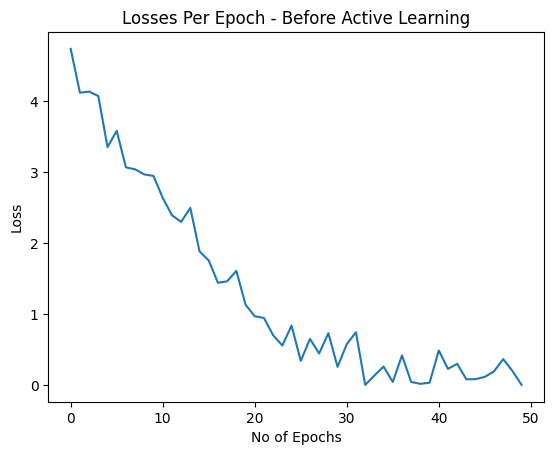

In [50]:
plt.plot(losses_p)
plt.title('Losses Per Epoch - Before Active Learning')
plt.xlabel('No of Epochs')
plt.ylabel('Loss');

In [51]:
nlp.to_disk('my_model_200_data_points')

#### Prediction using GPT-4.0

In [101]:
class GPT_Preds:

    def prepare_prompt(self, ip):
        # Prepare full prompt
        # starter_prompt = """You are to behave as a Medical Search Engine API. Each query shall be a natural-language patient workup in a JSON format. Each workup could contain spelling mistakes and common medical shorthand. You are to return a JSON response that contains a list of signs and symptoms extracted from the patient workup. For example: {'query': 'Coming from home, C/o bilateral leg pain and inability to walk X 2 days, Denies injury, Lives alone with aide service'} and {“response”: [“bilateral leg pain”, “inability to walk”, “2 days”]}"""
        starter_prompt = """You are supposed to behave as a binary text classification machine learning algorithm capable of identifying whether a particular code comment is a Techincal Debt or not. Your answer should be either of just two words 'Yes' or 'No'. 'Yes' would mean that you have classified the given example as a Technical Debt whereas 'No' would mean otherwise. Kindly do not include any other textual commentaries in your answer and just output a 'Yes' or a 'No'"""

        query = f'{{"query":{ip}}}'

        return starter_prompt, query

    def prompt_gpt(self, query):
        API_KEY = os.getenv('OPENAI_API_KEY')
        API_ENDPOINT = "https://api.openai.com/v1/chat/completions" 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {API_KEY}",
        }

        data = {
            "model" : "gpt-4",
            "messages" : query,
            "temperature" : 1,
            "max_tokens" : None,
        }

        response = requests.post(API_ENDPOINT, headers=headers, data=json.dumps(data))

        if response.status_code == 200:
            return response.json()["choices"][0]["message"]["content"]
        else:
            raise Exception(f"Error {response.status_code}: {response.text}")

    def ask_chatgpt(self, input_prompt):
        patient_workup = input_prompt;
        prompt = self.prepare_prompt(patient_workup);

        messages = [
            {"role": "system", "content": prompt[0]},
            {"role": "user", "content": prompt[1]}
        ]

        ans = self.prompt_gpt(messages)

        return ans

    def main_module(self, query):
        extracted_entities = self.ask_chatgpt(query)
        return extracted_entities;

####  Fetching the predictions from GPT-4.0


In [85]:
apps = pd.read_csv('13-apps.csv', header=None)
tools = pd.read_csv('13-tools.csv', header=None)


In [107]:
main_data = pd.concat([apps, tools], axis=0)

In [108]:
main_data

0                   1                                  2  \
0      aaacgchgc     ealcobaca/pymfe                pymfe/complexity.py   
1      aaacgchge     ealcobaca/pymfe                pymfe/complexity.py   
2      aaacgchgg     ealcobaca/pymfe                pymfe/complexity.py   
3      aaacgchha     ealcobaca/pymfe                pymfe/complexity.py   
4      aaacgdhci     ealcobaca/pymfe                pymfe/complexity.py   
...          ...                 ...                                ...   
27823  aajdfhhha  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27824  aajdfhhhb  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27825  aajdfhhhe  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27826  aajdfibig  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27827  aajdficbe  PaddlePaddle/ERNIE  propeller/paddle/data/__init__.py   

                                              3  \
0      2f9f04b156b38211e1c7e4dd83d89b293536e638   
1      2f9f04b156b38211e1c7e4dd83d89b293536e638   
2      55be17a227ae8d93ccaa4f43de33077068dd695b   
3      9349988f7ff657c015c832b69a6db1a24bb4675d   
4      70e58ce4494a521fabb30b96657629b9542b63f1   
...                                         ...   
27823  defa38e7c4e7da8c05626569f17f80eac518a088   
27824  defa38e7c4e7da8c05626569f17f80eac518a088   
27825  defa38e7c4e7da8c05626569f17f80eac518a088   
27826  3b9d92fcb83ac08420c22858f353256fe7fe0630   
27827  3b9d92fcb83ac08420c22858f353256fe7fe0630   

                                              4  \
0      ef0851ba097fb99a539bd52a6cf0a6baa90e32d5   
1      ef0851ba097fb99a539bd52a6cf0a6baa90e32d5   
2                                  STILL_EXISTS   
3                                  STILL_EXISTS   
4      2d382ec699f34b2b76c1b4be235f4fab426ba594   
...                                         ...   
27823                              STILL_EXISTS   
27824                              STILL_EXISTS   
27825                              STILL_EXISTS   
27826                              STILL_EXISTS   
27827                              STILL_EXISTS   

                                                       5  
0                   get min max for all columns by class  
1                                  columns. --> features  
2         I think we could improve this part of the code  
3                    removing the most efficient feature  
4      TODO: the MFE (R version) implements the non-o...  
...                                                  ...  
27823  F.io.load_program_state(param_path) #buggy in ...  
27824            FIXME: no need to do this in the future  
27825                                         maybe not?  
27826                                  FIXME:remove this  
27827                                            columns  

[68820 rows x 6 columns]

In [109]:
main_data[main_data[5].isin(all_data['Comment'].tolist())]

0                1  \
6      aaacgdhdh  ealcobaca/pymfe   
8      aaacgdheb  ealcobaca/pymfe   
9      aaacgdhgf  ealcobaca/pymfe   
12     aaacgdhhj  ealcobaca/pymfe   
14     aaacgdhid  ealcobaca/pymfe   
...          ...              ...   
27704  aajaeabbh  chainer/chainer   
27767  aajahagfi  chainer/chainer   
27768  aajahcjgc  chainer/chainer   
27771  aajahdebc  chainer/chainer   
27772  aajahdgff  chainer/chainer   

                                                       2  \
6                                    pymfe/complexity.py   
8                                    pymfe/complexity.py   
9                                    pymfe/complexity.py   
12                                   pymfe/complexity.py   
14                                   pymfe/complexity.py   
...                                                  ...   
27704               chainerx/python/chainerx/__init__.py   
27767  tests/chainer_tests/links_tests/loss_tests/tes...   
27768  tests/chainer_tests/links_tests/loss_tests/tes...   
27771  tests/chainer_tests/links_tests/loss_tests/tes...   
27772  tests/chainer_tests/links_tests/loss_tests/tes...   

                                              3  \
6      70e58ce4494a521fabb30b96657629b9542b63f1   
8      70e58ce4494a521fabb30b96657629b9542b63f1   
9      2d382ec699f34b2b76c1b4be235f4fab426ba594   
12     8354becab0e8b59bb7f39fe792b9fe5a08399b7b   
14     8354becab0e8b59bb7f39fe792b9fe5a08399b7b   
...                                         ...   
27704  37aae99064f0fbaf5794a51bd2413ec3ff07b5eb   
27767  8eacd20e35f31f124da36759953a21b29871e72f   
27768  d16abee4b4272ccfdbaa7b846cd39d365f8c42be   
27771  401040aa701eaf2466a3d5f2bd4ed8236710759f   
27772  302686e849f68c2106398fabb54c7217b93fb7e1   

                                              4  \
6      2d382ec699f34b2b76c1b4be235f4fab426ba594   
8                                  STILL_EXISTS   
9                                  STILL_EXISTS   
12                                 STILL_EXISTS   
14                                 STILL_EXISTS   
...                                         ...   
27704                              STILL_EXISTS   
27767                              STILL_EXISTS   
27768                              STILL_EXISTS   
27771                              STILL_EXISTS   
27772                              STILL_EXISTS   

                                                       5  
6      TODO: This feature seems to be a normalized ve...  
8      TODO: If the categorical attributes are consid...  
9      TODO: If the categorical attributes are consid...  
12     TODO: This feature seems to be a normalized ve...  
14     TODO: If the categorical attributes are consid...  
...                                                  ...  
27704  `testing` needs to be imported before `_core`;...  
27767  Fix this test. The code seems to fix the sampl...  
27768  Fix this test. The code seems to fix the sampl...  
27771  Fix this test. The code seems to fix the sampl...  
27772  Fix this test. The code seems to fix the sampl...  

[5254 rows x 6 columns]

In [110]:
all_data.drop_duplicates(inplace=True)

In [112]:
annotated_data = all_data

In [118]:
unannotated_data = main_data[~(main_data[5].isin(annotated_data['Comment'].tolist()))]

In [124]:
unannotated_data = unannotated_data[[5]]

In [126]:
unannotated_data.rename(columns={5:'Comment'}, inplace=True)

/var/folders/3q/dw048hjx6d775m1t6pn8lf5h0000gs/T/ipykernel_24936/1066302286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data.rename(columns={5:'Comment'}, inplace=True)


In [128]:
unannotated_data['GPT_4_Predicted_MLTD_label'] = ''
unannotated_data['spaCy_Predicted_MLTD_label'] = ''
unannotated_data['actual_MLTD_label'] = ''

/var/folders/3q/dw048hjx6d775m1t6pn8lf5h0000gs/T/ipykernel_24936/308368120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['GPT_4_Predicted_MLTD_label'] = ''
/var/folders/3q/dw048hjx6d775m1t6pn8lf5h0000gs/T/ipykernel_24936/308368120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['spaCy_Predicted_MLTD_label'] = ''
/var/folders/3q/dw048hjx6d775m1t6pn8lf5h0000gs/T/ipykernel_24936/308368120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [129]:
unannotated_data = unannotated_data.reset_index()
unannotated_data

index                                            Comment  \
0          0               get min max for all columns by class   
1          1                              columns. --> features   
2          2     I think we could improve this part of the code   
3          3                removing the most efficient feature   
4          4  TODO: the MFE (R version) implements the non-o...   
...      ...                                                ...   
63561  27823  F.io.load_program_state(param_path) #buggy in ...   
63562  27824            FIXME: no need to do this in the future   
63563  27825                                         maybe not?   
63564  27826                                  FIXME:remove this   
63565  27827                                            columns   

      GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label actual_MLTD_label  
0                                                                              
1                                                                              
2                                                                              
3                                                                              
4                                                                              
...                          ...                        ...               ...  
63561                                                                          
63562                                                                          
63563                                                                          
63564                                                                          
63565                                                                          

[63566 rows x 5 columns]

In [177]:
for idx, row in unannotated_data.iloc[:, :].iterrows():
    try:
        print(idx)
        data_point = row['Comment']
        gpt_pred = gpt_class.main_module(data_point)
        print(gpt_pred)
        unannotated_data.loc[idx, 'GPT_4_Predicted_MLTD_label'] = gpt_pred
        print('='*100)
    except:
        time.sleep(60)

653
Yes
654
No
655
Yes
656
Yes
657
Yes
658
Yes
659
Yes
660
Yes
661
Yes
662
Yes
663
Yes
664
Yes
665
Yes
666
Yes
667
Yes
668
No
669
Yes
670
Yes
671
Yes
672
Yes
673
Yes
674
Yes
675
Yes
676
Yes
677
Yes
678
Yes
679
Yes
680
Yes
681
Yes
682
Yes
683
Yes
684
Yes
685
Yes
686
Yes
687
Yes
688
Yes
689
Yes
690
Yes
691
Yes
692
Yes
693
Yes
694
Yes
695
Yes
696
Yes
697
Yes
698
No
699
Yes
700
Yes
701
Yes
702
No
703
No
704
Yes
705
Yes
706
Yes
707
Yes
708
Yes
709
Yes
710
Yes
711
Yes
712
No
713
No
714
No
715
No
716
No
717
No
718
No
719
No
720
No
721
No
722
No
723
Yes
724
Yes
725
Yes
726
Yes
727
No
728
Yes
729


No
730
No
731
Yes
732
Yes
733
Yes
734
Yes
735
Yes
736
No
737
No
738
No
739
Yes
740
No
741
No
742
No
743
Yes
744
Yes
745
No
746
No
747
No
748
No
749
No
750
Yes
751
No
752
No
753
Yes
754
No
755
No
756
Yes
757
Yes
758
Yes
759
No
760
No
761
Yes
762
No
763
No
764
No
765
Yes
766
No
767
No
768
Yes
769
Yes
770
Yes
771
Yes
772
Yes
773
Yes
774
Yes
775
Yes
776
Yes
777
Yes
778
Yes
779
Yes
780
Yes
781
Yes
782
Yes
783
Yes
784
Yes
785
Yes
786
Yes
787
Yes
788
Yes
789
Yes
790
Yes
791
Yes
792
Yes
793
Yes
794
Yes
795
Yes
796
No
797
No
798
No
799
Yes
800
No
801
No
802
No
803
No
804
Yes
805


No
806
Yes
807
No
808
Yes
809
No
810
No
811
No
812
No
813
No
814
Yes
815
No
816
No
817
No
818
No
819
No
820
No
821
No
822
No
823
Yes
824
Yes
825
Yes
826
No
827
No
828
No
829
No
830
No
831
No
832
No
833
No
834
No
835
No
836
No
837
No
838
No
839
No
840
No
841
No
842
No
843
No
844
No
845
No
846
Yes
847
No
848
Yes
849
No
850
No
851
Yes
852
Yes
853
No
854
No
855
No
856
No
857
Yes
858
No
859
No
860
Yes
861
Yes
862
Yes
863
Yes
864
No
865
No
866
Yes
867
868
Yes
869
No
870
No
871
No
872
No
873
No
874
Yes
875
No
876
Yes
877
No
878
Yes
879
Yes
880
Yes
881
Yes
882


Yes
883
Yes
884
Yes
885
Yes
886
Yes
887
Yes
888
No
889
Yes
890
Yes
891
Yes
892
Yes
893
No
894
No
895
No
896
Yes
897
Yes
898
Yes
899
Yes
900
Yes
901
Yes
902
Yes
903
No
904
Yes
905
No
906
Yes
907
Yes
908
Yes
909
Yes
910
Yes
911
Yes
912
No
913
Yes
914
Yes
915
Yes
916
Yes
917
Yes
918
Yes
919
Yes
920
No
921
Yes
922
Yes
923
Yes
924
Yes
925
Yes
926
Yes
927
No
928
No
929
No
930
Yes
931
Yes
932
Yes
933
Yes
934
Yes
935
Yes
936
No
937
Yes
938
No
939
No
940
Yes
941
Yes
942
No
943
Yes
944
No
945
No
946
No
947
No
948
No
949
No
950
Yes
951
Yes
952
Yes
953
No
954
No
955
Yes
956
No
957
Yes
958


Yes
959
Yes
960
No
961
No
962
No
963
No
964
Yes
965
Yes
966
No
967
Yes
968
No
969
No
970
No
971
No
972
Yes
973
Yes
974
No
975
Yes
976
Yes
977
Yes
978
No
979
No
980
No
981
No
982
Yes
983
No
984
Yes
985
Yes
986
Yes
987
Yes
988
No
989
No
990
No
991
Yes
992
Yes
993
Yes
994
Yes
995
Yes
996
Yes
997
Yes
998
Yes
999
Yes
1000
Yes
1001
Yes
1002
Yes
1003
Yes
1004
Yes
1005
Yes
1006
Yes
1007
Yes
1008
Yes
1009
Yes
1010
Yes
1011
Yes
1012
Yes
1013
Yes
1014
Yes
1015
Yes
1016
Yes
1017
Yes
1018
Yes
1019
Yes
1020
Yes
1021
Yes
1022
Yes
1023
Yes
1024
Yes
1025
Yes
1026
Yes
1027
Yes
1028
Yes
1029
Yes
1030
No
1031
Yes
1032
Yes
1033
Yes
1034


Yes
1035
Yes
1036
Yes
1037
Yes
1038
Yes
1039
Yes
1040
Yes
1041
Yes
1042
Yes
1043
Yes
1044
Yes
1045
No
1046
Yes
1047
Yes
1048
Yes
1049
Yes
1050
Yes
1051
No
1052
Yes
1053
Yes
1054
Yes
1055
Yes
1056
Yes
1057
Yes
1058
Yes
1059
Yes
1060
Yes
1061
Yes
1062
Yes
1063
No
1064
Yes
1065
Yes
1066
Yes
1067
Yes
1068
Yes
1069
Yes
1070
Yes
1071
Yes
1072
Yes
1073
Yes
1074
Yes
1075
Yes
1076
Yes
1077
Yes
1078
Yes
1079
No
1080
Yes
1081
No
1082
No
1083
Yes
1084
No
1085
Yes
1086
No
1087
No
1088
Yes
1089
Yes
1090
Yes
1091
1092
Yes
1093
Yes
1094
Yes
1095
Yes
1096
Yes
1097
No
1098
Yes
1099
Yes
1100
Yes
1101
Yes
1102
Yes
1103
Yes
1104
Yes
1105
Yes
1106
Yes
1107
Yes
1108
Yes
1109
Yes
1110


Yes
1111
Yes
1112
Yes
1113
Yes
1114
Yes
1115
Yes
1116
Yes
1117
Yes
1118
Yes
1119
Yes
1120
Yes
1121
Yes
1122
Yes
1123
Yes
1124
Yes
1125
Yes
1126
Yes
1127
Yes
1128
Yes
1129
Yes
1130
Yes
1131
Yes
1132
Yes
1133
Yes
1134
Yes
1135
Yes
1136
Yes
1137
Yes
1138
Yes
1139
Yes
1140
Yes
1141
Yes
1142
Yes
1143
Yes
1144
Yes
1145
Yes
1146
Yes
1147
Yes
1148
Yes
1149
Yes
1150
Yes
1151
Yes
1152
Yes
1153
Yes
1154
Yes
1155
Yes
1156
Yes
1157
Yes
1158
Yes
1159
Yes
1160
Yes
1161
Yes
1162
Yes
1163
Yes
1164
Yes
1165
Yes
1166
Yes
1167
Yes
1168
Yes
1169
Yes
1170
Yes
1171
No
1172
Yes
1173
Yes
1174
Yes
1175
Yes
1176
Yes
1177
Yes
1178
No
1179
Yes
1180
Yes
1181
Yes
1182
Yes
1183
Yes
1184
No
1185


No
1186
Yes
1187
Yes
1188
No
1189
Yes
1190
Yes
1191
Yes
1192
No
1193
No
1194
Yes
1195
Yes
1196
Yes
1197
Yes
1198
Yes
1199
Yes
1200
Yes
1201
Yes
1202
Yes
1203
Yes
1204
Yes
1205
Yes
1206
Yes
1207
Yes
1208
Yes
1209
Yes
1210
Yes
1211
Yes
1212
Yes
1213
Yes
1214
Yes
1215
Yes
1216
Yes
1217
Yes
1218
No
1219
No
1220
No
1221
No
1222
No
1223
No
1224
No
1225
No
1226
No
1227
Yes
1228
Yes
1229
No
1230
No
1231
Yes
1232
Yes
1233
No
1234
No
1235
Yes
1236
Yes
1237
No
1238
Yes
1239
Yes
1240
Yes
1241
Yes
1242
Yes
1243
Yes
1244
No
1245
No
1246
Yes
1247
Yes
1248
Yes
1249
No
1250
No
1251
Yes
1252
Yes
1253
No
1254
Yes
1255
Yes
1256
Yes
1257
Yes
1258
No
1259
Yes
1260


No
1261
Yes
1262
Yes
1263
No
1264
No
1265
No
1266
Yes
1267
No
1268
No
1269
No
1270
Yes
1271
Yes
1272
No
1273
No
1274
Yes
1275
Yes
1276
Yes
1277
Yes
1278
Yes
1279
Yes
1280
Yes
1281
Yes
1282
Yes
1283
Yes
1284
Yes
1285
Yes
1286
Yes
1287
Yes
1288
Yes
1289
Yes
1290
Yes
1291
Yes
1292
Yes
1293
Yes
1294
Yes
1295
Yes
1296
Yes
1297
Yes
1298
Yes
1299
Yes
1300
Yes
1301
Yes
1302
Yes
1303
Yes
1304
Yes
1305
Yes
1306
1307
Yes
1308
Yes
1309
Yes
1310
Yes
1311
Yes
1312
Yes
1313
Yes
1314
Yes
1315
Yes
1316
Yes
1317
Yes
1318
Yes
1319
Yes
1320
Yes
1321
Yes
1322
Yes
1323
Yes
1324
Yes
1325
Yes
1326
Yes
1327
Yes
1328
No
1329
Yes
1330
Yes
1331
Yes
1332
Yes
1333
Yes
1334
Yes
1335
Yes
1336


Yes
1337
Yes
1338
Yes
1339
Yes
1340
Yes
1341
Yes
1342
Yes
1343
Yes
1344
Yes
1345
Yes
1346
No
1347
Yes
1348
Yes
1349
No
1350
Yes
1351
Yes
1352
Yes
1353
Yes
1354
Yes
1355
Yes
1356
Yes
1357
Yes
1358
Yes
1359
Yes
1360
No
1361
No
1362
Yes
1363
No
1364
No
1365
No
1366
No
1367
No
1368
Yes
1369
Yes
1370
No
1371
Yes
1372
No
1373
Yes
1374
No
1375
No
1376
Yes
1377
No
1378
No
1379
Yes
1380
Yes
1381
Yes
1382
Yes
1383
Yes
1384
Yes
1385
Yes
1386
Yes
1387
Yes
1388
Yes
1389
Yes
1390
Yes
1391
Yes
1392
Yes
1393
Yes
1394
Yes
1395
Yes
1396
Yes
1397
Yes
1398
Yes
1399
Yes
1400
Yes
1401
No
1402
Yes
1403
Yes
1404
Yes
1405
No
1406
No
1407
No
1408
No
1409
No
1410
No
1411


Yes
1412
No
1413
Yes
1414
No
1415
Yes
1416
Yes
1417
Yes
1418
Yes
1419
Yes
1420
Yes
1421
Yes
1422
No
1423
Yes
1424
Yes
1425
No
1426
No
1427
Yes
1428
Yes
1429
Yes
1430
Yes
1431
Yes
1432
Yes
1433
No
1434
No
1435
No
1436
Yes
1437
No
1438
No
1439
Yes
1440
Yes
1441
Yes
1442
Yes
1443
No
1444
No
1445
No
1446
No
1447
No
1448
Yes
1449
No
1450
Yes
1451
Yes
1452
Yes
1453
Yes
1454
Yes
1455
Yes
1456
No
1457
Yes
1458
Yes
1459
No
1460
No
1461
Yes
1462
Yes
1463
Yes
1464
No
1465
Yes
1466
Yes
1467
Yes
1468
Yes
1469
Yes
1470
Yes
1471
Yes
1472
Yes
1473
Yes
1474
Yes
1475
No
1476
Yes
1477
Yes
1478
Yes
1479
Yes
1480
No
1481
No
1482
No
1483
No
1484
No
1485
Yes
1486


Yes
1487
Yes
1488
Yes
1489
Yes
1490
Yes
1491
Yes
1492
Yes
1493
Yes
1494
Yes
1495
No
1496
1497
No
1498
Yes
1499
No
1500
No
1501
No
1502
No
1503
Yes
1504
No
1505
Yes
1506
Yes
1507
Yes
1508
Yes
1509
No
1510
No
1511
Yes
1512
Yes
1513
Yes
1514
Yes
1515
No
1516
No
1517
No
1518
No
1519
No
1520
No
1521
Yes
1522
Yes
1523
Yes
1524
Yes
1525
No
1526
No
1527
No
1528
No
1529
Yes
1530
Yes
1531
Yes
1532
Yes
1533
Yes
1534
Yes
1535
Yes
1536
Yes
1537
Yes
1538
Yes
1539
Yes
1540
Yes
1541
Yes
1542
Yes
1543
Yes
1544
Yes
1545
No
1546
Yes
1547
Yes
1548
Yes
1549
No
1550
No
1551
No
1552
No
1553
No
1554
No
1555
No
1556
No
1557
No
1558
Yes
1559
No
1560
No
1561
Yes
1562


Yes
1563
Yes
1564
No
1565
Yes
1566
No
1567
No
1568
No
1569
No
1570
No
1571
No
1572
No
1573
No
1574
No
1575
No
1576
No
1577
Yes
1578
No
1579
No
1580
No
1581
No
1582
No
1583
No
1584
No
1585
No
1586
No
1587
Yes
1588
No
1589
No
1590
No
1591
No
1592
No
1593
No
1594
No
1595
No
1596
No
1597
Yes
1598
Yes
1599
No
1600
No
1601
No
1602
Yes
1603
Yes
1604
No
1605
Yes
1606
No
1607
No
1608
No
1609
No
1610
No
1611
No
1612
No
1613
No
1614
Yes
1615
No
1616
Yes
1617
Yes
1618
No
1619
Yes
1620
No
1621
No
1622
Yes
1623
No
1624
No
1625
Yes
1626
Yes
1627
Yes
1628
No
1629
No
1630
No
1631
Yes
1632
No
1633
Yes
1634
No
1635
Yes
1636
No
1637


No
1638
Yes
1639
No
1640
No
1641
No
1642
No
1643
No
1644
Yes
1645
Yes
1646
Yes
1647
Yes
1648
Yes
1649
Yes
1650
Yes
1651
Yes
1652
Yes
1653
Yes
1654
Yes
1655
Yes
1656
Yes
1657
Yes
1658
Yes
1659
Yes
1660
Yes
1661
Yes
1662
Yes
1663
Yes
1664
Yes
1665
Yes
1666
Yes
1667
Yes
1668
Yes
1669
Yes
1670
Yes
1671
Yes
1672
Yes
1673
Yes
1674
Yes
1675
Yes
1676
Yes
1677
Yes
1678
No
1679
Yes
1680
No
1681
Yes
1682
Yes
1683
No
1684
No
1685
No
1686
No
1687
No
1688
No
1689
Yes
1690
Yes
1691
Yes
1692
Yes
1693
Yes
1694
No
1695
Yes
1696
Yes
1697
Yes
1698
Yes
1699
No
1700
No
1701
No
1702
No
1703
Yes
1704
Yes
1705
Yes
1706
Yes
1707
Yes
1708
No
1709
Yes
1710
No
1711
1712
No
1713


No
1714
No
1715
Yes
1716
Yes
1717
No
1718
No
1719
Yes
1720
Yes
1721
Yes
1722
Yes
1723
Yes
1724
No
1725
Yes
1726
No
1727
Yes
1728
Yes
1729
No
1730
No
1731
No
1732
No
1733
Yes
1734
Yes
1735
Yes
1736
No
1737
No
1738
No
1739
Yes
1740
No
1741
Yes
1742
No
1743
No
1744
No
1745
Yes
1746
Yes
1747
No
1748
No
1749
Yes
1750
Yes
1751
Yes
1752
Yes
1753
Yes
1754
Yes
1755
Yes
1756
Yes
1757
Yes
1758
No
1759
Yes
1760
Yes
1761
Yes
1762
Yes
1763
Yes
1764
Yes
1765
Yes
1766
Yes
1767
Yes
1768
Yes
1769
Yes
1770
Yes
1771
Yes
1772
No
1773
Yes
1774
Yes
1775
No
1776
No
1777
No
1778
No
1779
Yes
1780
Yes
1781
Yes
1782
Yes
1783
Yes
1784
No
1785
Yes
1786
Yes
1787
Yes
1788


Yes
1789
No
1790
Yes
1791
Yes
1792
No
1793
Yes
1794
Yes
1795
Yes
1796
No
1797
No
1798
No
1799
Yes
1800
Yes
1801
Yes
1802
Yes
1803
No
1804
Yes
1805
Yes
1806
Yes
1807
Yes
1808
Yes
1809
Yes
1810
Yes
1811
Yes
1812
Yes
1813
Yes
1814
Yes
1815
Yes
1816
Yes
1817
Yes
1818
Yes
1819
Yes
1820
Yes
1821
Yes
1822
Yes
1823
Yes
1824
Yes
1825
Yes
1826
Yes
1827
Yes
1828
Yes
1829
No
1830
Yes
1831
Yes
1832
Yes
1833
Yes
1834
No
1835
Yes
1836
Yes
1837
Yes
1838
Yes
1839
Yes
1840
Yes
1841
Yes
1842
Yes
1843
Yes
1844
Yes
1845
Yes
1846
Yes
1847
Yes
1848
Yes
1849
No
1850
No
1851
Yes
1852
Yes
1853
Yes
1854
Yes
1855
Yes
1856
Yes
1857
Yes
1858
Yes
1859
Yes
1860
Yes
1861
Yes
1862
Yes
1863


Yes
1864
Yes
1865
Yes
1866
Yes
1867
Yes
1868
Yes
1869
Yes
1870
Yes
1871
No
1872
Yes
1873
Yes
1874
Yes
1875
Yes
1876
Yes
1877
Yes
1878
Yes
1879
Yes
1880
Yes
1881
Yes
1882
Yes
1883
Yes
1884
Yes
1885
Yes
1886
Yes
1887
Yes
1888
Yes
1889
Yes
1890
Yes
1891
Yes
1892
Yes
1893
Yes
1894
Yes
1895
Yes
1896
Yes
1897
Yes
1898
Yes
1899
Yes
1900
Yes
1901
Yes
1902
Yes
1903
Yes
1904
Yes
1905
Yes
1906
Yes
1907
Yes
1908
Yes
1909
Yes
1910
Yes
1911
Yes
1912
Yes
1913
Yes
1914
Yes
1915
Yes
1916
Yes
1917
Yes
1918
Yes
1919
No
1920
Yes
1921
Yes
1922
Yes
1923
Yes
1924
Yes
1925
Yes
1926
Yes
1927
Yes
1928
Yes
1929
Yes
1930
Yes
1931
Yes
1932
No
1933
Yes
1934
Yes
1935
No
1936
Yes
1937
Yes
1938


Yes
1939
Yes
1940
Yes
1941
No
1942
Yes
1943
Yes
1944
Yes
1945
Yes
1946
Yes
1947
No
1948
Yes
1949
No
1950
Yes
1951
Yes
1952
Yes
1953
Yes
1954
Yes
1955
Yes
1956
No
1957
Yes
1958
Yes
1959
Yes
1960
Yes
1961
Yes
1962
1963
No
1964
No
1965
No
1966
No
1967
No
1968
No
1969
No
1970
No
1971
No
1972
No
1973
Yes
1974
Yes
1975
No
1976
No
1977
Yes
1978
Yes
1979
Yes
1980
No
1981
Yes
1982
No
1983
Yes
1984
Yes
1985
Yes
1986
Yes
1987
Yes
1988
Yes
1989
Yes
1990
Yes
1991
Yes
1992
Yes
1993
Yes
1994
Yes
1995
Yes
1996
Yes
1997
Yes
1998
Yes
1999
Yes
2000
Yes
2001
Yes
2002
Yes
2003
Yes
2004
Yes
2005
Yes
2006
Yes
2007
Yes
2008
Yes
2009
Yes
2010
Yes
2011
Yes
2012
Yes
2013
Yes
2014


Yes
2015
Yes
2016
Yes
2017
Yes
2018
No
2019
No
2020
No
2021
No
2022
No
2023
No
2024
Yes
2025
Yes
2026
No
2027
Yes
2028
No
2029
Yes
2030
Yes
2031
Yes
2032
Yes
2033
No
2034
Yes
2035
Yes
2036
Yes
2037
No
2038
Yes
2039
Yes
2040
No
2041
Yes
2042
No
2043
Yes
2044
No
2045
Yes
2046
Yes
2047
No
2048
No
2049
No
2050
No
2051
No
2052
No
2053
No
2054
No
2055
No
2056
No
2057
Yes
2058
No
2059
Yes
2060
Yes
2061
Yes
2062
Yes
2063
Yes
2064
No
2065
Yes
2066
No
2067
No
2068
No
2069
Yes
2070
Yes
2071
No
2072
Yes
2073
Yes
2074
Yes
2075
Yes
2076
Yes
2077
Yes
2078
Yes
2079
No
2080
Yes
2081
Yes
2082
No
2083
No
2084
Yes
2085
No
2086
No
2087
No
2088
Yes
2089


No
2090
Yes
2091
Yes
2092
Yes
2093
Yes
2094
Yes
2095
No
2096
Yes
2097
No
2098
Yes
2099
Yes
2100
Yes
2101
Yes
2102
Yes
2103
Yes
2104
No
2105
No
2106
No
2107
Yes
2108
No
2109
Yes
2110
Yes
2111
No
2112
Yes
2113
Yes
2114
Yes
2115
No
2116
Yes
2117
Yes
2118
Yes
2119
Yes
2120
Yes
2121
Yes
2122
Yes
2123
Yes
2124
Yes
2125
Yes
2126
Yes
2127
Yes
2128
Yes
2129
Yes
2130
Yes
2131
No
2132
Yes
2133
Yes
2134
Yes
2135
No
2136
Yes
2137
Yes
2138
Yes
2139
Yes
2140
Yes
2141
Yes
2142
Yes
2143
Yes
2144
Yes
2145
No
2146
No
2147
Yes
2148
Yes
2149
Yes
2150
Yes
2151
Yes
2152
Yes
2153
Yes
2154
Yes
2155
Yes
2156
Yes
2157
Yes
2158
Yes
2159
Yes
2160
Yes
2161
Yes
2162
Yes
2163
Yes
2164


Yes
2165
Yes
2166
Yes
2167
Yes
2168
Yes
2169
Yes
2170
Yes
2171
Yes
2172
No
2173
Yes
2174
Yes
2175
Yes
2176
Yes
2177
No
2178
Yes
2179
Yes
2180
Yes
2181
Yes
2182
Yes
2183
Yes
2184
Yes
2185
Yes
2186
Yes
2187
Yes
2188
Yes
2189
Yes
2190
Yes
2191
Yes
2192
Yes
2193
No
2194
Yes
2195
Yes
2196
Yes
2197
Yes
2198
No
2199
Yes
2200
Yes
2201
Yes
2202
Yes
2203
No
2204
No
2205
Yes
2206
Yes
2207
Yes
2208
Yes
2209
Yes
2210
Yes
2211
Yes
2212
2213
Yes
2214
Yes
2215
Yes
2216
Yes
2217
No
2218
No
2219
Yes
2220
Yes
2221
Yes
2222
No
2223
Yes
2224
Yes
2225
Yes
2226
No
2227
Yes
2228
No
2229
Yes
2230
Yes
2231
Yes
2232
Yes
2233
Yes
2234
Yes
2235
Yes
2236
Yes
2237
No
2238
Yes
2239
No
2240


No
2241
No
2242
No
2243
No
2244
No
2245
No
2246
No
2247
No
2248
No
2249
No
2250
No
2251
No
2252
No
2253
Yes
2254
No
2255
No
2256
No
2257
No
2258
No
2259
No
2260
No
2261
No
2262
No
2263
No
2264
No
2265
No
2266
Yes
2267
No
2268
No
2269
No
2270
No
2271
Yes
2272
No
2273
Yes
2274
No
2275
No
2276
Yes
2277
Yes
2278
Yes
2279
Yes
2280
No
2281
No
2282
Yes
2283
No
2284
No
2285
Yes
2286
No
2287
No
2288
No
2289
No
2290
Yes
2291
Yes
2292
Yes
2293
Yes
2294
No
2295
No
2296
No
2297
No
2298
No
2299
No
2300
Yes
2301
No
2302
Yes
2303
No
2304
Yes
2305
Yes
2306
No
2307
No
2308
No
2309
No
2310
No
2311
No
2312
No
2313
No
2314
Yes
2315


Yes
2316
Yes
2317
Yes
2318
No
2319
No
2320
No
2321
No
2322
No
2323
No
2324
No
2325
Yes
2326
Yes
2327
No
2328
Yes
2329
No
2330
Yes
2331
Yes
2332
Yes
2333
Yes
2334
Yes
2335
No
2336
No
2337
No
2338
No
2339
No
2340
No
2341
No
2342
No
2343
Yes
2344
Yes
2345
No
2346
Yes
2347
No
2348
No
2349
Yes
2350
Yes
2351
No
2352
Yes
2353
No
2354
Yes
2355
Yes
2356
No
2357
No
2358
Yes
2359
Yes
2360
Yes
2361
Yes
2362
Yes
2363
Yes
2364
Yes
2365
Yes
2366
No
2367
Yes
2368
Yes
2369
Yes
2370
No
2371
Yes
2372
No
2373
Yes
2374
Yes
2375
Yes
2376
Yes
2377
No
2378
Yes
2379
Yes
2380
Yes
2381
No
2382
2383
No
2384
Yes
2385
No
2386
Yes
2387
No
2388
No
2389
Yes
2390
Yes
2391


Yes
2392
Yes
2393
No
2394
Yes
2395
No
2396
Yes
2397
Yes
2398
No
2399
No
2400
No
2401
Yes
2402
Yes
2403
No
2404
Yes
2405
Yes
2406
Yes
2407
Yes
2408
Yes
2409
Yes
2410
Yes
2411
Yes
2412
Yes
2413
Yes
2414
Yes
2415
Yes
2416
No
2417
Yes
2418
Yes
2419
No
2420
Yes
2421
Yes
2422
Yes
2423
No
2424
No
2425
No
2426
Yes
2427
Yes
2428
No
2429
Yes
2430
Yes
2431
Yes
2432
Yes
2433
Yes
2434
Yes
2435
No
2436
Yes
2437
Yes
2438
Yes
2439
Yes
2440
No
2441
Yes
2442
No
2443
Yes
2444
Yes
2445
Yes
2446
Yes
2447
No
2448
Yes
2449
Yes
2450
Yes
2451
Yes
2452
Yes
2453
Yes
2454
Yes
2455
Yes
2456
Yes
2457
Yes
2458
Yes
2459
Yes
2460
Yes
2461
Yes
2462
Yes
2463
Yes
2464
Yes
2465
Yes
2466


No
2467
Yes
2468
No
2469
Yes
2470
Yes
2471
Yes
2472
Yes
2473
Yes
2474
Yes
2475
Yes
2476
Yes
2477
Yes
2478
Yes
2479
Yes
2480
Yes
2481
No
2482
Yes
2483
No
2484
Yes
2485
No
2486
No
2487
No
2488
Yes
2489
Yes
2490
Yes
2491
Yes
2492
Yes
2493
No
2494
No
2495
Yes
2496
Yes
2497
Yes
2498
Yes
2499
No
2500
Yes
2501
Yes
2502
Yes
2503
Yes
2504
Yes
2505
Yes
2506
Yes
2507
Yes
2508
No
2509
Yes
2510
Yes
2511
Yes
2512
Yes
2513
Yes
2514
Yes
2515
Yes
2516
Yes
2517
Yes
2518
Yes
2519
Yes
2520
Yes
2521
Yes
2522
Yes
2523
No
2524
Yes
2525
Yes
2526
No
2527
Yes
2528
Yes
2529
Yes
2530
Yes
2531
No
2532
Yes
2533
Yes
2534
Yes
2535
Yes
2536
Yes
2537
Yes
2538
Yes
2539
Yes
2540
No
2541


Yes
2542
Yes
2543
Yes
2544
No
2545
No
2546
Yes
2547
Yes
2548
Yes
2549
Yes
2550
Yes
2551
Yes
2552
Yes
2553
Yes
2554
No
2555
Yes
2556
No
2557
No
2558
Yes
2559
Yes
2560
Yes
2561
No
2562
Yes
2563
Yes
2564
No
2565
Yes
2566
Yes
2567
Yes
2568
Yes
2569
Yes
2570
Yes
2571
No
2572
Yes
2573
Yes
2574
Yes
2575
No
2576
Yes
2577
Yes
2578
No
2579
Yes
2580
Yes
2581
Yes
2582
Yes
2583
Yes
2584
No
2585
Yes
2586
Yes
2587
No
2588
Yes
2589
No
2590
Yes
2591
Yes
2592
No
2593
No
2594
Yes
2595
Yes
2596
Yes
2597
Yes
2598
Yes
2599
Yes
2600
Yes
2601
Yes
2602
Yes
2603
Yes
2604
Yes
2605
Yes
2606
Yes
2607
Yes
2608
Yes
2609
No
2610
No
2611
Yes
2612
Yes
2613
No
2614
No
2615
No
2616


No
2617
No
2618
No
2619
No
2620
No
2621
No
2622
No
2623
Yes
2624
Yes
2625
Yes
2626
Yes
2627
Yes
2628
No
2629
Yes
2630
No
2631
Yes
2632
Yes
2633
2634
No
2635
Yes
2636
Yes
2637
Yes
2638
Yes
2639
No
2640
Yes
2641
Yes
2642
Yes
2643
Yes
2644
No
2645
Yes
2646
Yes
2647
Yes
2648
No
2649
No
2650
No
2651
No
2652
No
2653
No
2654
No
2655
Yes
2656
No
2657
No
2658
Yes
2659
Yes
2660
No
2661
Yes
2662
Yes
2663
Yes
2664
No
2665
No
2666
Yes
2667
Yes
2668
No
2669
No
2670
Yes
2671
No
2672
No
2673
Yes
2674
No
2675
No
2676
No
2677
No
2678
No
2679
No
2680
No
2681
No
2682
No
2683
No
2684
No
2685
No
2686
No
2687
No
2688
No
2689
No
2690
Yes
2691
Yes
2692


Yes
2693
Yes
2694
Yes
2695
Yes
2696
Yes
2697
Yes
2698
Yes
2699
Yes
2700
Yes
2701
Yes
2702
Yes
2703
Yes
2704
Yes
2705
Yes
2706
Yes
2707
Yes
2708
Yes
2709
Yes
2710
Yes
2711
Yes
2712
Yes
2713
Yes
2714
Yes
2715
Yes
2716
Yes
2717
Yes
2718
Yes
2719
Yes
2720
Yes
2721
Yes
2722
Yes
2723
Yes
2724
Yes
2725
Yes
2726
Yes
2727
Yes
2728
Yes
2729
Yes
2730
Yes
2731
Yes
2732
Yes
2733
Yes
2734
Yes
2735
Yes
2736
Yes
2737
No
2738
Yes
2739
Yes
2740
Yes
2741
Yes
2742
Yes
2743
No
2744
Yes
2745
Yes
2746
No
2747
No
2748
No
2749
No
2750
No
2751
No
2752
Yes
2753
Yes
2754
Yes
2755
No
2756
Yes
2757
No
2758
No
2759
Yes
2760
Yes
2761
Yes
2762
Yes
2763
No
2764
Yes
2765
No
2766
No
2767


Yes
2768
No
2769
No
2770
No
2771
Yes
2772
No
2773
No
2774
Yes
2775
Yes
2776
No
2777
Yes
2778
No
2779
No
2780
No
2781
No
2782
Yes
2783
No
2784
No
2785
Yes
2786
No
2787
No
2788
No
2789
No
2790
No
2791
No
2792
No
2793
Yes
2794
No
2795
No
2796
No
2797
No
2798
No
2799
No
2800
No
2801
Yes
2802
Yes
2803
Yes
2804
Yes
2805
Yes
2806
Yes
2807
Yes
2808
Yes
2809
Yes
2810
No
2811
No
2812
No
2813
Yes
2814
Yes
2815
Yes
2816
Yes
2817
No
2818
Yes
2819
Yes
2820
Yes
2821
Yes
2822
Yes
2823
No
2824
No
2825
Yes
2826
No
2827
Yes
2828
No
2829
No
2830
Yes
2831
Yes
2832
No
2833
No
2834
No
2835
No
2836
No
2837
No
2838
No
2839
No
2840
No
2841
No
2842


No
2843
No
2844
No
2845
2846
Yes
2847
Yes
2848
No
2849
Yes
2850
No
2851
Yes
2852
Yes
2853
Yes
2854
Yes
2855
No
2856
Yes
2857
No
2858
No
2859
Yes
2860
No
2861
Yes
2862
Yes
2863
No
2864
Yes
2865
Yes
2866
No
2867
Yes
2868
Yes
2869
Yes
2870
Yes
2871
Yes
2872
Yes
2873
Yes
2874
Yes
2875
Yes
2876
No
2877
No
2878
No
2879
Yes
2880
No
2881
No
2882
No
2883
Yes
2884
Yes
2885
Yes
2886
No
2887
No
2888
Yes
2889
Yes
2890
Yes
2891
Yes
2892
No
2893
No
2894
No
2895
Yes
2896
No
2897
No
2898
No
2899
No
2900
No
2901
No
2902
No
2903
No
2904
No
2905
No
2906
No
2907
No
2908
No
2909
No
2910
No
2911
Yes
2912
Yes
2913
No
2914
No
2915
No
2916
No
2917
Yes
2918


No
2919
Yes
2920
No
2921
No
2922
Yes
2923
Yes
2924
No
2925
Yes
2926
Yes
2927
No
2928
No
2929
No
2930
No
2931
No
2932
Yes
2933
Yes
2934
Yes
2935
Yes
2936
No
2937
Yes
2938
Yes
2939
Yes
2940
Yes
2941
Yes
2942
No
2943
Yes
2944
Yes
2945
Yes
2946
No
2947
Yes
2948
Yes
2949
No
2950
Yes
2951
Yes
2952
Yes
2953
Yes
2954
Yes
2955
Yes
2956
Yes
2957
No
2958
Yes
2959
Yes
2960
No
2961
No
2962
No
2963
No
2964
No
2965
Yes
2966
Yes
2967
No
2968
Yes
2969
No
2970
No
2971
No
2972
No
2973
Yes
2974
Yes
2975
Yes
2976
No
2977
Yes
2978
Yes
2979
No
2980
No
2981
No
2982
No
2983
Yes
2984
No
2985
Yes
2986
No
2987
Yes
2988
Yes
2989
Yes
2990
No
2991
No
2992
No
2993


No
2994
No
2995
No
2996
Yes
2997
No
2998
No
2999
Yes
3000
No
3001
Yes
3002
Yes
3003
No
3004
No
3005
Yes
3006
Yes
3007
No
3008
Yes
3009
Yes
3010
Yes
3011
Yes
3012
No
3013
No
3014
Yes
3015
Yes
3016
Yes
3017
Yes
3018
Yes
3019
Yes
3020
Yes
3021
Yes
3022
Yes
3023
Yes
3024
No
3025
No
3026
No
3027
No
3028
No
3029
No
3030
No
3031
No
3032
Yes
3033
No
3034
No
3035
No
3036
Yes
3037
Yes
3038
No
3039
No
3040
No
3041
No
3042
No
3043
Yes
3044
No
3045
No
3046
No
3047
No
3048
No
3049
No
3050
Yes
3051
No
3052
No
3053
No
3054
No
3055
No
3056
No
3057
No
3058
Yes
3059
No
3060
Yes
3061
No
3062
No
3063
Yes
3064
Yes
3065
Yes
3066
No
3067
Yes
3068


No
3069
Yes
3070
No
3071
No
3072
No
3073
No
3074
No
3075
No
3076
No
3077
No
3078
No
3079
Yes
3080
No
3081
No
3082
No
3083
No
3084
No
3085
No
3086
3087
No
3088
No
3089
Yes
3090
No
3091
No
3092
No
3093
No
3094
No
3095
No
3096
No
3097
No
3098
No
3099
Yes
3100
Yes
3101
No
3102
No
3103
No
3104
Yes
3105
No
3106
No
3107
Yes
3108
No
3109
No
3110
No
3111
No
3112
No
3113
No
3114
No
3115
No
3116
Yes
3117
No
3118
Yes
3119
Yes
3120
No
3121
Yes
3122
No
3123
No
3124
Yes
3125
No
3126
No
3127
Yes
3128
Yes
3129
Yes
3130
No
3131
No
3132
No
3133
Yes
3134
No
3135
Yes
3136
No
3137
Yes
3138
No
3139
No
3140
Yes
3141
No
3142
No
3143
No
3144


Yes
3145
No
3146
No
3147
Yes
3148
No
3149
No
3150
Yes
3151
Yes
3152
No
3153
No
3154
No
3155
No
3156
Yes
3157
Yes
3158
No
3159
Yes
3160
Yes
3161
No
3162
No
3163
Yes
3164
No
3165
Yes
3166
No
3167
No
3168
No
3169
Yes
3170
Yes
3171
No
3172
No
3173
Yes
3174
No
3175
Yes
3176
Yes
3177
Yes
3178
Yes
3179
Yes
3180
Yes
3181
No
3182
Yes
3183
Yes
3184
Yes
3185
Yes
3186
Yes
3187
Yes
3188
Yes
3189
Yes
3190
Yes
3191
Yes
3192
Yes
3193
Yes
3194
Yes
3195
No
3196
Yes
3197
Yes
3198
Yes
3199
Yes
3200
Yes
3201
Yes
3202
Yes
3203
Yes
3204
No
3205
Yes
3206
No
3207
No
3208
Yes
3209
Yes
3210
Yes
3211
No
3212
No
3213
No
3214
No
3215
No
3216
Yes
3217
Yes
3218
No
3219


Yes
3220
Yes
3221
Yes
3222
No
3223
No
3224
No
3225
Yes
3226
No
3227
No
3228
Yes
3229
Yes
3230
No
3231
Yes
3232
Yes
3233
Yes
3234
Yes
3235
Yes
3236
No
3237
No
3238
No
3239
Yes
3240
Yes
3241
Yes
3242
No
3243
No
3244
No
3245
No
3246
No
3247
No
3248
No
3249
Yes
3250
Yes
3251
Yes
3252
Yes
3253
Yes
3254
Yes
3255
Yes
3256
Yes
3257
Yes
3258
Yes
3259
Yes
3260
Yes
3261
Yes
3262
Yes
3263
Yes
3264
Yes
3265
Yes
3266
Yes
3267
Yes
3268
Yes
3269
Yes
3270
Yes
3271
Yes
3272
Yes
3273
Yes
3274
Yes
3275
Yes
3276
Yes
3277
Yes
3278
Yes
3279
No
3280
No
3281
No
3282
Yes
3283
No
3284
No
3285
No
3286
No
3287
Yes
3288
Yes
3289
Yes
3290
Yes
3291
No
3292
Yes
3293
Yes
3294


Yes
3295
Yes
3296
No
3297
Yes
3298
No
3299
No
3300
3301
Yes
3302
Yes
3303
Yes
3304
Yes
3305
Yes
3306
Yes
3307
Yes
3308
Yes
3309
Yes
3310
Yes
3311
No
3312
No
3313
No
3314
Yes
3315
Yes
3316
Yes
3317
Yes
3318
Yes
3319
Yes
3320
Yes
3321
Yes
3322
Yes
3323
Yes
3324
No
3325
Yes
3326
Yes
3327
Yes
3328
Yes
3329
No
3330
Yes
3331
Yes
3332
Yes
3333
No
3334
Yes
3335
Yes
3336
Yes
3337
Yes
3338
Yes
3339
Yes
3340
Yes
3341
Yes
3342
No
3343
Yes
3344
Yes
3345
No
3346
No
3347
No
3348
No
3349
No
3350
No
3351
No
3352
No
3353
No
3354
Yes
3355
Yes
3356
Yes
3357
Yes
3358
Yes
3359
Yes
3360
Yes
3361
No
3362
No
3363
Yes
3364
Yes
3365
No
3366
No
3367
No
3368
No
3369
Yes
3370


Yes
3371
No
3372
No
3373
Yes
3374
Yes
3375
No
3376
Yes
3377
No
3378
Yes
3379
Yes
3380
Yes
3381
Yes
3382
Yes
3383
No
3384
No
3385
Yes
3386
No
3387
Yes
3388
Yes
3389
Yes
3390
Yes
3391
Yes
3392
Yes
3393
Yes
3394
No
3395
Yes
3396
Yes
3397
No
3398
Yes
3399
Yes
3400
Yes
3401
Yes
3402
Yes
3403
Yes
3404
No
3405
Yes
3406
Yes
3407
No
3408
Yes
3409
Yes
3410
Yes
3411
Yes
3412
No
3413
Yes
3414
Yes
3415
No
3416
Yes
3417
No
3418
Yes
3419
Yes
3420
Yes
3421
Yes
3422
Yes
3423
No
3424
Yes
3425
No
3426
Yes
3427
Yes
3428
Yes
3429
Yes
3430
Yes
3431
Yes
3432
Yes
3433
No
3434
Yes
3435
Yes
3436
No
3437
Yes
3438
Yes
3439
Yes
3440
No
3441
No
3442
No
3443
No
3444
Yes
3445


No
3446
Yes
3447
No
3448
Yes
3449
No
3450
Yes
3451
Yes
3452
No
3453
No
3454
Yes
3455
No
3456
Yes
3457
Yes
3458
No
3459
Yes
3460
Yes
3461
No
3462
No
3463
No
3464
Yes
3465
Yes
3466
Yes
3467
No
3468
Yes
3469
No
3470
No
3471
Yes
3472
Yes
3473
Yes
3474
Yes
3475
Yes
3476
Yes
3477
No
3478
No
3479
No
3480
No
3481
Yes
3482
Yes
3483
Yes
3484
Yes
3485
No
3486
Yes
3487
Yes
3488
Yes
3489
Yes
3490
No
3491
No
3492
No
3493
No
3494
No
3495
No
3496
Yes
3497
No
3498
No
3499
No
3500
No
3501
Yes
3502
Yes
3503
Yes
3504
No
3505
No
3506
Yes
3507
No
3508
Yes
3509
Yes
3510
Yes
3511
Yes
3512
Yes
3513
Yes
3514
No
3515
Yes
3516
Yes
3517
No
3518
Yes
3519
No
3520


Yes
3521
No
3522
No
3523
No
3524
Yes
3525
Yes
3526
No
3527
No
3528
No
3529
3530
Yes
3531
Yes
3532
Yes
3533
Yes
3534
No
3535
Yes
3536
Yes
3537
No
3538
Yes
3539
Yes
3540
Yes
3541
No
3542
Yes
3543
Yes
3544
Yes
3545
Yes
3546
No
3547
Yes
3548
No
3549
Yes
3550
No
3551
Yes
3552
Yes
3553
Yes
3554
Yes
3555
Yes
3556
Yes
3557
No
3558
Yes
3559
Yes
3560
Yes
3561
Yes
3562
No
3563
Yes
3564
Yes
3565
Yes
3566
Yes
3567
No
3568
No
3569
Yes
3570
Yes
3571
Yes
3572
Yes
3573
No
3574
No
3575
No
3576
Yes
3577
No
3578
Yes
3579
Yes
3580
No
3581
No
3582
No
3583
No
3584
Yes
3585
Yes
3586
Yes
3587
Yes
3588
No
3589
Yes
3590
Yes
3591
No
3592
No
3593
Yes
3594
Yes
3595
No
3596


No
3597
No
3598
No
3599
Yes
3600
Yes
3601
Yes
3602
No
3603
No
3604
Yes
3605
Yes
3606
Yes
3607
No
3608
No
3609
No
3610
Yes
3611
Yes
3612
Yes
3613
Yes
3614
No
3615
Yes
3616
No
3617
No
3618
Yes
3619
No
3620
No
3621
Yes
3622
Yes
3623
No
3624
No
3625
No
3626
No
3627
Yes
3628
Yes
3629
Yes
3630
No
3631
No
3632
No
3633
No
3634
Yes
3635
No
3636
No
3637
No
3638
No
3639
No
3640
No
3641
No
3642
Yes
3643
Yes
3644
Yes
3645
Yes
3646
No
3647
No
3648
No
3649
No
3650
No
3651
No
3652
No
3653
No
3654
No
3655
No
3656
No
3657
No
3658
No
3659
No
3660
No
3661
No
3662
No
3663
No
3664
No
3665
No
3666
No
3667
No
3668
No
3669
No
3670
No
3671


No
3672
Yes
3673
No
3674
No
3675
No
3676
No
3677
No
3678
No
3679
No
3680
Yes
3681
No
3682
No
3683
No
3684
No
3685
No
3686
No
3687
No
3688
No
3689
Yes
3690
No
3691
No
3692
Yes
3693
Yes
3694
No
3695
No
3696
No
3697
No
3698
No
3699
Yes
3700
Yes
3701
No
3702
Yes
3703
Yes
3704
No
3705
No
3706
No
3707
Yes
3708
Yes
3709
Yes
3710
No
3711
Yes
3712
No
3713
No
3714
No
3715
No
3716
No
3717
Yes
3718
No
3719
No
3720
No
3721
No
3722
No
3723
Yes
3724
No
3725
No
3726
No
3727
3728
No
3729
No
3730
Yes
3731
No
3732
No
3733
Yes
3734
Yes
3735
No
3736
No
3737
Yes
3738
Yes
3739
No
3740
No
3741
No
3742
No
3743
No
3744
Yes
3745
Yes
3746
Yes
3747


No
3748
Yes
3749
No
3750
No
3751
No
3752
No
3753
No
3754
No
3755
No
3756
No
3757
No
3758
No
3759
No
3760
No
3761
Yes
3762
No
3763
No
3764
Yes
3765
Yes
3766
Yes
3767
No
3768
No
3769
Yes
3770
No
3771
Yes
3772
Yes
3773
No
3774
Yes
3775
Yes
3776
No
3777
No
3778
Yes
3779
Yes
3780
Yes
3781
Yes
3782
Yes
3783
No
3784
No
3785
No
3786
Yes
3787
No
3788
No
3789
No
3790
No
3791
No
3792
No
3793
No
3794
No
3795
No
3796
No
3797
No
3798
Yes
3799
No
3800
No
3801
No
3802
No
3803
No
3804
Yes
3805
No
3806
No
3807
No
3808
Yes
3809
No
3810
Yes
3811
Yes
3812
No
3813
Yes
3814
Yes
3815
Yes
3816
Yes
3817
Yes
3818
No
3819
Yes
3820
Yes
3821
No
3822


No
3823
Yes
3824
No
3825
Yes
3826
No
3827
No
3828
No
3829
No
3830
Yes
3831
No
3832
Yes
3833
No
3834
No
3835
Yes
3836
No
3837
No
3838
No
3839
No
3840
No
3841
No
3842
No
3843
No
3844
No
3845
No
3846
No
3847
Yes
3848
No
3849
No
3850
No
3851
No
3852
No
3853
No
3854
No
3855
Yes
3856
Yes
3857
No
3858
Yes
3859
No
3860
Yes
3861
Yes
3862
Yes
3863
Yes
3864
No
3865
Yes
3866
No
3867
No
3868
No
3869
No
3870
Yes
3871
Yes
3872
Yes
3873
No
3874
No
3875
No
3876
No
3877
No
3878
No
3879
No
3880
Yes
3881
Yes
3882
No
3883
No
3884
No
3885
No
3886
No
3887
Yes
3888
Yes
3889
No
3890
Yes
3891
No
3892
Yes
3893
No
3894
Yes
3895
No
3896
No
3897


Yes
3898
Yes
3899
Yes
3900
Yes
3901
No
3902
No
3903
Yes
3904
Yes
3905
Yes
3906
No
3907
Yes
3908
No
3909
Yes
3910
No
3911
Yes
3912
Yes
3913
Yes
3914
Yes
3915
3916
No
3917
No
3918
Yes
3919
No
3920
No
3921
No
3922
No
3923
No
3924
Yes
3925
Yes
3926
No
3927
No
3928
No
3929
No
3930
Yes
3931
Yes
3932
No
3933
No
3934
No
3935
Yes
3936
Yes
3937
Yes
3938
Yes
3939
No
3940
No
3941
No
3942
Yes
3943
Yes
3944
Yes
3945
No
3946
No
3947
No
3948
Yes
3949
Yes
3950
Yes
3951
Yes
3952
No
3953
Yes
3954
No
3955
No
3956
Yes
3957
No
3958
No
3959
Yes
3960
Yes
3961
No
3962
No
3963
Yes
3964
No
3965
No
3966
Yes
3967
Yes
3968
Yes
3969
Yes
3970
Yes
3971
No
3972
No
3973


No
3974
Yes
3975
Yes
3976
Yes
3977
Yes
3978
No
3979
No
3980
No
3981
Yes
3982
No
3983
No
3984
Yes
3985
No
3986
Yes
3987
No
3988
Yes
3989
Yes
3990
Yes
3991
Yes
3992
Yes
3993
Yes
3994
Yes
3995
Yes
3996
No
3997
Yes
3998
Yes
3999
Yes
4000
Yes
4001
Yes
4002
Yes
4003
No
4004
No
4005
Yes
4006
Yes
4007
Yes
4008
Yes
4009
Yes
4010
No
4011
No
4012
No
4013
No
4014
No
4015
Yes
4016
Yes
4017
Yes
4018
No
4019
Yes
4020
No
4021
No
4022
No
4023
No
4024
Yes
4025
Yes
4026
Yes
4027
Yes
4028
Yes
4029
No
4030
No
4031
No
4032
Yes
4033
No
4034
Yes
4035
Yes
4036
Yes
4037
Yes
4038
Yes
4039
Yes
4040
Yes
4041
Yes
4042
Yes
4043
No
4044
Yes
4045
Yes
4046
No
4047
No
4048


No
4049
No
4050
Yes
4051
Yes
4052
No
4053
Yes
4054
No
4055
No
4056
No
4057
No
4058
No
4059
No
4060
No
4061
Yes
4062
No
4063
No
4064
Yes
4065
No
4066
Yes
4067
Yes
4068
Yes
4069
Yes
4070
Yes
4071
No
4072
4073
Yes
4074
Yes
4075
Yes
4076
Yes
4077
Yes
4078
Yes
4079
Yes
4080
Yes
4081
Yes
4082
Yes
4083
Yes
4084
Yes
4085
Yes
4086
Yes
4087
Yes
4088
Yes
4089
Yes
4090
No
4091
No
4092
No
4093
No
4094
Yes
4095
Yes
4096
Yes
4097
Yes
4098
Yes
4099
No
4100
Yes
4101
Yes
4102
Yes
4103
No
4104
Yes
4105
Yes
4106
Yes
4107
Yes
4108
Yes
4109
Yes
4110
Yes
4111
Yes
4112
Yes
4113
Yes
4114
Yes
4115
Yes
4116
No
4117
Yes
4118
Yes
4119
Yes
4120
Yes
4121
Yes
4122
Yes
4123
Yes
4124


Yes
4125
Yes
4126
Yes
4127
Yes
4128
Yes
4129
Yes
4130
Yes
4131
Yes
4132
Yes
4133
Yes
4134
Yes
4135
Yes
4136
Yes
4137
No
4138
No
4139
No
4140
No
4141
Yes
4142
No
4143
No
4144
No
4145
Yes
4146
No
4147
No
4148
Yes
4149
Yes
4150
Yes
4151
Yes
4152
Yes
4153
Yes
4154
Yes
4155
Yes
4156
Yes
4157
Yes
4158
Yes
4159
Yes
4160
Yes
4161
Yes
4162
Yes
4163
Yes
4164
Yes
4165
Yes
4166
Yes
4167
Yes
4168
Yes
4169
Yes
4170
No
4171
No
4172
No
4173
Yes
4174
Yes
4175
Yes
4176
Yes
4177
No
4178
Yes
4179
Yes
4180
Yes
4181
Yes
4182
No
4183
Yes
4184
No
4185
Yes
4186
Yes
4187
Yes
4188
Yes
4189
Yes
4190
Yes
4191
Yes
4192
Yes
4193
Yes
4194
Yes
4195
Yes
4196
Yes
4197
Yes
4198
No
4199


No
4200
No
4201
No
4202
No
4203
No
4204
No
4205
No
4206
Yes
4207
No
4208
No
4209
Yes
4210
Yes
4211
Yes
4212
No
4213
No
4214
No
4215
No
4216
No
4217
No
4218
No
4219
No
4220
No
4221
No
4222
No
4223
No
4224
Yes
4225
No
4226
Yes
4227
Yes
4228
No
4229
No
4230
Yes
4231
No
4232
Yes
4233
No
4234
No
4235
No
4236
Yes
4237
Yes
4238
Yes
4239
Yes
4240
No
4241
No
4242
Yes
4243
No
4244
Yes
4245
No
4246
Yes
4247
No
4248
Yes
4249
Yes
4250
Yes
4251
Yes
4252
Yes
4253
No
4254
No
4255
No
4256
Yes
4257
No
4258
No
4259
No
4260
Yes
4261
No
4262
Yes
4263
Yes
4264
Yes
4265
Yes
4266
Yes
4267
Yes
4268
Yes
4269
Yes
4270
No
4271
Yes
4272
No
4273
No
4274


No
4275
Yes
4276
Yes
4277
Yes
4278
Yes
4279
No
4280
Yes
4281
Yes
4282
Yes
4283
No
4284
Yes
4285
No
4286
Yes
4287
No
4288
No
4289
No
4290
Yes
4291
Yes
4292
Yes
4293
No
4294
Yes
4295
Yes
4296
Yes
4297
No
4298
No
4299
No
4300
No
4301
No
4302
No
4303
No
4304
4305
No
4306
No
4307
No
4308
Yes
4309
No
4310
Yes
4311
No
4312
Yes
4313
No
4314
Yes
4315
Yes
4316
No
4317
Yes
4318
Yes
4319
Yes
4320
No
4321
Yes
4322
Yes
4323
Yes
4324
No
4325
No
4326
Yes
4327
Yes
4328
Yes
4329
Yes
4330
Yes
4331
No
4332
No
4333
No
4334
No
4335
No
4336
No
4337
No
4338
No
4339
No
4340
No
4341
No
4342
Yes
4343
Yes
4344
Yes
4345
Yes
4346
Yes
4347
Yes
4348
Yes
4349
Yes
4350


Yes
4351
Yes
4352
Yes
4353
Yes
4354
Yes
4355
Yes
4356
Yes
4357
Yes
4358
Yes
4359
Yes
4360
No
4361
Yes
4362
Yes
4363
Yes
4364
No
4365
Yes
4366
Yes
4367
Yes
4368
Yes
4369
Yes
4370
Yes
4371
Yes
4372
Yes
4373
Yes
4374
Yes
4375
Yes
4376
No
4377
Yes
4378
No
4379
Yes
4380
Yes
4381
Yes
4382
No
4383
Yes
4384
No
4385
No
4386
Yes
4387
No
4388
No
4389
No
4390
Yes
4391
No
4392
No
4393
Yes
4394
No
4395
Yes
4396
Yes
4397
Yes
4398
No
4399
Yes
4400
Yes
4401
Yes
4402
Yes
4403
No
4404
No
4405
Yes
4406
Yes
4407
No
4408
No
4409
Yes
4410
No
4411
No
4412
No
4413
No
4414
No
4415
No
4416
No
4417
Yes
4418
Yes
4419
Yes
4420
Yes
4421
Yes
4422
Yes
4423
Yes
4424
Yes
4425


No
4426
No
4427
Yes
4428
No
4429
Yes
4430
Yes
4431
Yes
4432
Yes
4433
Yes
4434
Yes
4435
Yes
4436
No
4437
No
4438
Yes
4439
Yes
4440
Yes
4441
Yes
4442
Yes
4443
Yes
4444
Yes
4445
Yes
4446
Yes
4447
Yes
4448
Yes
4449
Yes
4450
Yes
4451
Yes
4452
Yes
4453
Yes
4454
Yes
4455
Yes
4456
Yes
4457
Yes
4458
Yes
4459
Yes
4460
Yes
4461
Yes
4462
Yes
4463
Yes
4464
Yes
4465
Yes
4466
No
4467
No
4468
No
4469
No
4470
No
4471
No
4472
No
4473
Yes
4474
No
4475
No
4476
No
4477
Yes
4478
Yes
4479
Yes
4480
Yes
4481
Yes
4482
Yes
4483
Yes
4484
Yes
4485
No
4486
Yes
4487
Yes
4488
Yes
4489
No
4490
No
4491
No
4492
Yes
4493
Yes
4494
No
4495
No
4496
No
4497
No
4498
Yes
4499
No
4500


Yes
4501
Yes
4502
Yes
4503
Yes
4504
Yes
4505
No
4506
Yes
4507
Yes
4508
Yes
4509
Yes
4510
No
4511
Yes
4512
Yes
4513
Yes
4514
Yes
4515
Yes
4516
Yes
4517
Yes
4518
Yes
4519
Yes
4520
Yes
4521
Yes
4522
4523
Yes
4524
Yes
4525
Yes
4526
Yes
4527
Yes
4528
Yes
4529
Yes
4530
Yes
4531
No
4532
Yes
4533
Yes
4534
Yes
4535
Yes
4536
Yes
4537
Yes
4538
Yes
4539
Yes
4540
Yes
4541
Yes
4542
Yes
4543
Yes
4544
Yes
4545
Yes
4546
Yes
4547
Yes
4548
Yes
4549
No
4550
No
4551
Yes
4552
Yes
4553
Yes
4554
Yes
4555
Yes
4556
Yes
4557
No
4558
No
4559
No
4560
Yes
4561
No
4562
Yes
4563
Yes
4564
Yes
4565
Yes
4566
Yes
4567
Yes
4568
Yes
4569
Yes
4570
No
4571
Yes
4572
Yes
4573
Yes
4574
Yes
4575
Yes
4576


Yes
4577
Yes
4578
Yes
4579
Yes
4580
Yes
4581
Yes
4582
No
4583
No
4584
No
4585
No
4586
No
4587
Yes
4588
No
4589
Yes
4590
Yes
4591
Yes
4592
No
4593
Yes
4594
Yes
4595
Yes
4596
Yes
4597
Yes
4598
Yes
4599
Yes
4600
Yes
4601
Yes
4602
No
4603
No
4604
Yes
4605
No
4606
No
4607
Yes
4608
Yes
4609
Yes
4610
No
4611
No
4612
No
4613
No
4614
No
4615
No
4616
No
4617
No
4618
Yes
4619
No
4620
No
4621
Yes
4622
Yes
4623
Yes
4624
Yes
4625
Yes
4626
Yes
4627
Yes
4628
No
4629
No
4630
Yes
4631
No
4632
No
4633
No
4634
No
4635
Yes
4636
No
4637
No
4638
No
4639
No
4640
Yes
4641
Yes
4642
No
4643
No
4644
Yes
4645
Yes
4646
No
4647
Yes
4648
No
4649
No
4650
No
4651


Yes
4652
No
4653
Yes
4654
Yes
4655
Yes
4656
No
4657
No
4658
Yes
4659
Yes
4660
Yes
4661
No
4662
No
4663
Yes
4664
No
4665
No
4666
No
4667
Yes
4668
Yes
4669
Yes
4670
Yes
4671
Yes
4672
Yes
4673
Yes
4674
Yes
4675
Yes
4676
Yes
4677
Yes
4678
No
4679
Yes
4680
No
4681
Yes
4682
Yes
4683
Yes
4684
Yes
4685
Yes
4686
Yes
4687
Yes
4688
Yes
4689
Yes
4690
Yes
4691
Yes
4692
Yes
4693
Yes
4694
No
4695
No
4696
No
4697
No
4698
Yes
4699
No
4700
No
4701
Yes
4702
Yes
4703
No
4704
Yes
4705
No
4706
No
4707
No
4708
No
4709
Yes
4710
Yes
4711
4712
Yes
4713
Yes
4714
Yes
4715
Yes
4716
Yes
4717
Yes
4718
No
4719
Yes
4720
Yes
4721
Yes
4722
Yes
4723
Yes
4724
Yes
4725
Yes
4726
Yes
4727


Yes
4728
Yes
4729
Yes
4730
No
4731
Yes
4732
Yes
4733
Yes
4734
Yes
4735
Yes
4736
Yes
4737
Yes
4738
Yes
4739
Yes
4740
Yes
4741
Yes
4742
No
4743
No
4744
Yes
4745
Yes
4746
Yes
4747
Yes
4748
Yes
4749
Yes
4750
Yes
4751
Yes
4752
Yes
4753
Yes
4754
Yes
4755
Yes
4756
Yes
4757
Yes
4758
Yes
4759
Yes
4760
Yes
4761
Yes
4762
Yes
4763
Yes
4764
Yes
4765
No
4766
No
4767
Yes
4768
Yes
4769
No
4770
No
4771
No
4772
No
4773
No
4774
No
4775
Yes
4776
Yes
4777
Yes
4778
Yes
4779
No
4780
No
4781
No
4782
Yes
4783
Yes
4784
No
4785
No
4786
Yes
4787
No
4788
No
4789
No
4790
No
4791
No
4792
Yes
4793
Yes
4794
Yes
4795
Yes
4796
No
4797
Yes
4798
Yes
4799
Yes
4800
Yes
4801
Yes
4802


Yes
4803
Yes
4804
Yes
4805
No
4806
No
4807
No
4808
Yes
4809
Yes
4810
Yes
4811
No
4812
No
4813
No
4814
No
4815
Yes
4816
Yes
4817
Yes
4818
Yes
4819
Yes
4820
Yes
4821
Yes
4822
Yes
4823
Yes
4824
Yes
4825
Yes
4826
Yes
4827
Yes
4828
Yes
4829
Yes
4830
Yes
4831
Yes
4832
Yes
4833
Yes
4834
Yes
4835
Yes
4836
Yes
4837
Yes
4838
Yes
4839
Yes
4840
Yes
4841
No
4842
No
4843
No
4844
Yes
4845
Yes
4846
Yes
4847
No
4848
No
4849
Yes
4850
No
4851
No
4852
Yes
4853
No
4854
No
4855
No
4856
Yes
4857
No
4858
No
4859
No
4860
Yes
4861
Yes
4862
Yes
4863
Yes
4864
Yes
4865
No
4866
Yes
4867
Yes
4868
No
4869
Yes
4870
Yes
4871
No
4872
Yes
4873
Yes
4874
Yes
4875
No
4876
No
4877


Yes
4878
Yes
4879
No
4880
Yes
4881
No
4882
Yes
4883
No
4884
No
4885
No
4886
No
4887
Yes
4888
No
4889
No
4890
Yes
4891
No
4892
No
4893
No
4894
Yes
4895
No
4896
Yes
4897
Yes
4898
Yes
4899
Yes
4900
No
4901
Yes
4902
Yes
4903
No
4904
Yes
4905
Yes
4906
Yes
4907
Yes
4908
Yes
4909
Yes
4910
Yes
4911
Yes
4912
Yes
4913
Yes
4914
Yes
4915
4916
Yes
4917
No
4918
No
4919
Yes
4920
Yes
4921
Yes
4922
Yes
4923
Yes
4924
Yes
4925
No
4926
No
4927
Yes
4928
Yes
4929
Yes
4930
Yes
4931
Yes
4932
Yes
4933
No
4934
No
4935
Yes
4936
Yes
4937
Yes
4938
Yes
4939
No
4940
Yes
4941
No
4942
Yes
4943
Yes
4944
Yes
4945
Yes
4946
No
4947
Yes
4948
No
4949
Yes
4950
Yes
4951
Yes
4952
Yes
4953


Yes
4954
Yes
4955
No
4956
Yes
4957
Yes
4958
Yes
4959
Yes
4960
Yes
4961
Yes
4962
Yes
4963
Yes
4964
Yes
4965
No
4966
No
4967
Yes
4968
No
4969
Yes
4970
Yes
4971
Yes
4972
No
4973
No
4974
No
4975
Yes
4976
Yes
4977
No
4978
Yes
4979
Yes
4980
Yes
4981
Yes
4982
Yes
4983
Yes
4984
Yes
4985
Yes
4986
Yes
4987
Yes
4988
Yes
4989
Yes
4990
No
4991
Yes
4992
Yes
4993
Yes
4994
Yes
4995
Yes
4996
Yes
4997
Yes
4998
Yes
4999
Yes
5000
Yes
5001
No
5002
Yes
5003
Yes
5004
Yes
5005



KeyboardInterrupt



In [178]:
unannotated_data = unannotated_data[unannotated_data['GPT_4_Predicted_MLTD_label']!=""]

index                                            Comment  \
867      914                                             unused   
1091    1162                                     TODO Implement   
1306    1388  TODO - \u0434\u043E\u0431\u0430\u0432\u0438\u0...   
1496    1593  Moving averages ends up in the trainable varia...   
1711    1812   load candidate set for efficient cs@N validation   
...      ...                                                ...   
63561  27823  F.io.load_program_state(param_path) #buggy in ...   
63562  27824            FIXME: no need to do this in the future   
63563  27825                                         maybe not?   
63564  27826                                  FIXME:remove this   
63565  27827                                            columns   

      GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label actual_MLTD_label  
867                                                                            
1091                                                                           
1306                                                                           
1496                                                                           
1711                                                                           
...                          ...                        ...               ...  
63561                                                                          
63562                                                                          
63563                                                                          
63564                                                                          
63565                                                                          

[58581 rows x 5 columns]

#### Predicting using spaCy model

In [229]:
for idx, row in unannotated_data.iterrows():
    doc = model(row['Comment'])
    preds = sorted(doc.cats.items(), key = lambda kv: -kv[1])[0][0]
    unannotated_data.loc[idx, 'spaCy_Predicted_MLTD_label'] = preds

In [234]:
unannotated_data[(unannotated_data['GPT_4_Predicted_MLTD_label']=="No") & (unannotated_data['spaCy_Predicted_MLTD_label']=="No")].to_csv('negative_preds.csv', index=False)
unannotated_data[(unannotated_data['GPT_4_Predicted_MLTD_label']=="Yes") & (unannotated_data['spaCy_Predicted_MLTD_label']=="Yes")].to_csv('positive_preds.csv', index=False)


In [ ]:
positive = pd.read_csv('positive_preds.csv')
negative = pd.read_csv('negative_preds.csv')
verify_data = unannotated_data[~(unannotated_data['Comment'].isin(positive['Comment'])) & ~(unannotated_data['Comment'].isin(negative['Comment']))].index.tolist()

In [ ]:
# n_count = 0;
for idx in verify_data:
    print(idx, unannotated_data.loc[idx, 'Comment'])
    label = input('Label: ')
    if label != '' and label == 'n':
        unannotated_data.loc[idx, 'actual_MLTD_label'] = label
        n_count += 1

In [ ]:
unannotated_data.to_csv('GPT-annotated-points_2.csv', index=False)

In [92]:
df = pd.read_csv('GPT-annotated-points_2.csv')
df.shape

(13326, 6)

In [93]:
df['Comment'] = df['Comment'].apply(lambda x:x.translate({ord(c): " " for c in """!@#$%^&*()[]{};:,./<>?\|`~-"'=_+"""}))

In [94]:
df['Comment']= df['Comment'].apply(lambda x:x.lower())

In [95]:
df = df[~((df['GPT_4_Predicted_MLTD_label']=='Yes') & (df['spaCy_Predicted_MLTD_label']=='Yes'))]
print(df.shape[0])
df = df[~((df['GPT_4_Predicted_MLTD_label']=='No') & (df['spaCy_Predicted_MLTD_label']=='No'))]
print(df.shape[0])

7420
6086


In [96]:
df['actual_MLTD_label'] = df['actual_MLTD_label'].replace('y', 'Yes').replace('n', 'No')

In [97]:
# train_data = []

for idx, row in df.iterrows():
    labels = {"Yes":False, "No":False}
    if row['actual_MLTD_label'] == "Yes":
        labels['Yes'] = True
    else:
        labels['No'] = True
    tup = (row['Comment'], {"cats":labels})
    train_data.append(tup)

In [98]:
# train_examples = []

for text, annotations in train_data:
    train_examples.append(Example.from_dict(nlp.make_doc(text), annotations))

In [99]:
len(train_examples)

6434

In [100]:
# Train the model
nlp.initialize()

In [101]:
df['actual_MLTD_label'].value_counts()/df['actual_MLTD_label'].value_counts().sum()

Yes    0.922938
No     0.077062
Name: actual_MLTD_label, dtype: float64

In [102]:
losses_p = []
for i in range(50): # Number of training iterations
    random.shuffle(train_examples)
    losses = {}
    for batch in minibatch(train_examples, size=8): # Batch size
        nlp.update(batch, drop=0.5, losses=losses) # Dropout rate
    print(i, "<---->", losses)
    losses_p.append(losses['textcat'])

0 <----> {'textcat': 56.85898718912995}
1 <----> {'textcat': 45.6987119322979}
2 <----> {'textcat': 45.29628634048237}
3 <----> {'textcat': 45.17712113055764}
4 <----> {'textcat': 41.633459265989956}
5 <----> {'textcat': 43.16357455007585}
6 <----> {'textcat': 39.19694753557348}
7 <----> {'textcat': 36.842368641208296}
8 <----> {'textcat': 33.34242774109856}
9 <----> {'textcat': 32.06034430781753}
10 <----> {'textcat': 31.704459011213057}
11 <----> {'textcat': 27.527274887631272}
12 <----> {'textcat': 26.779551140486653}
13 <----> {'textcat': 26.14691497078421}
14 <----> {'textcat': 26.11902133459806}
15 <----> {'textcat': 24.143880847328205}
16 <----> {'textcat': 22.561133392669113}
17 <----> {'textcat': 22.36344702984506}
18 <----> {'textcat': 20.888331831337222}
19 <----> {'textcat': 20.515811295538025}
20 <----> {'textcat': 18.753484172475183}
21 <----> {'textcat': 18.380157576488163}
22 <----> {'textcat': 19.565073936996168}
23 <----> {'textcat': 17.427241522466087}
24 <----> {'te

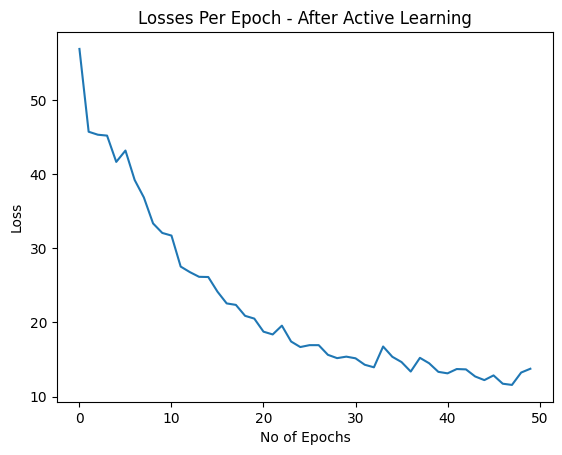

In [103]:
plt.plot(losses_p)
plt.title('Losses Per Epoch - After Active Learning')
plt.xlabel('No of Epochs')
plt.ylabel('Loss');

In [104]:
nlp.to_disk('my_model_aal')

#### Checking the accuracy on the test dataset

In [235]:
positive = pd.read_csv('positive_preds.csv')
negative = pd.read_csv('negative_preds.csv')

In [239]:
negative[negative['Comment'].str.contains('todo')]['Comment'].tolist()

['if true   todo  and  todolist  produce output  else they produce nothing ',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'todo  hassan',
 'encoder grads g   g grads 22     todo hard coded split between gan grads and encoder grads',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'todo  tabulate   plot',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'if true   todo  and  todolist  produce output  else they produce nothing ',
 'todo      tag uc778  uac83 uc740  uc560 ucd08 uc5d0  ub2f4 uc9c0 ub3c4  uc54a uc544 uc11c word vocab  uae38 uc774 uc758  uc808 ubc18 uc815 ub3c4 uc784',
 'if 

In [240]:
negative[negative['Comment'].str.contains('fixme')]['Comment'].tolist()

[]

In [241]:
positive[positive['Comment'].str.contains('todo')]['Comment'].tolist()

['todo  the mfe  r version  implements the non overlapping region',
 'todo  the mfe  r version  returns an boolean array marking all',
 'todo  currently  categorical variables are ignored  should we adjust',
 'todo  the mfe  r version  implements the non overlapping region',
 'todo  the mfe  r version  returns an boolean array marking all',
 'todo  currently  categorical variables are ignored  should we adjust',
 'todo  check validity ',
 'todo  absorb inner spheres',
 'todo  pre allocate numpy array',
 '       todo      improve this       ',
 '       todo      better typing for nn  weightedloss       ',
 '       todo       multithread ams calc      imporve plot colours       ',
 '       todo       add non inplace versions  options      imporve delta phi       ',
 'todo option for string lenght',
 'todo infer target type automatically',
 'todo extend to work on pt  eta  phi vectors',
 'todo  rewrite to not use a dataframe for holding parent vector',
 'todo  add inplace option',
 'todo 

In [242]:
positive[positive['Comment'].str.contains('fixme')]['Comment'].tolist()

['fixme this looks somewhat unstable  currently we schedule by',
 'fixme return only at end of method ',
 'fixme inefficient  make mdataframe a drop in replacement for any numpy ndarray',
 '  fixme this does not work',
 'fixme this is actually wrong  see df quantile   1   2  ',
 'fixme this is not working yet',
 'fixme enable cache by arguments  mnemonic   cached seconds 3600 ',
 'fixme should work with json  the default celery serializer ',
 'fixme sometimes it takes long for the nb to appear  why ',
 'fixme sometimes it takes long for the nb to appear why ',
 'fixme this is a mess',
 'fixme  remove this hard coding after debugging ',
 'todo  fixme  sehr  u00e4hnlich zu tryanalysepath aus mdbapi database  ggf irgendwie vereinen',
 'no client side cert needed      fixme',
 'fixme  invalid in multithreading env',
 'self randy addsongtoblacklist song    fixme  the web api uses this method to add random songs',
 'fixme  scan new artists for alums',
 'fixme  2  7 is not safe',
 'todo  fixm

#### Active learning on the spaCy model

In [35]:
unannotated_data = pd.read_csv('Unannotated_data.csv')

In [10]:
# Gettting the datapoints having separate predictions

active_learning_dataset = unannotated_data[((unannotated_data['GPT_4_Predicted_MLTD_label']=='No') & (unannotated_data['spaCy_Predicted_MLTD_label']=='Yes')) & (((unannotated_data['GPT_4_Predicted_MLTD_label']=='No') & (unannotated_data['spaCy_Predicted_MLTD_label']=='Yes')))]

#### Active Learning on the disagreed labels

In [11]:
gpt_4_correct = 0
spacy_correct = 0

for idx, row in active_learning_dataset.iterrows():
    dp = row['Comment']
    print(dp)
    label = input('Enter the correct label')
    if label == 'Yes' and row['GPT_4_Predicted_MLTD_label'] == "Yes":
        gpt_4_correct += 1
    elif label == 'Yes' and row['spaCy_Predicted_MLTD_label'] == "Yes":
        spacy_correct += 1
    elif label == 'No' and row['spaCy_Predicted_MLTD_label'] == "No":
        spacy_correct += 1
    else:
        gpt_4_correct += 1

In [246]:
print(positive.shape[0])
print(negative.shape[0])

2158
644


In [252]:
positive

index                                            Comment  \
0         2     i think we could improve this part of the code   
1         3                removing the most efficient feature   
2         4  todo  the mfe  r version  implements the non o...   
3         5  todo  the mfe  r version  returns an boolean a...   
4         7  todo  currently  categorical variables are ign...   
...     ...                                                ...   
2153   5304                    fixme  to be supported some day   
2154   5305                                  fixme  multilayer   
2155   5306                                              fixme   
2156   5307                                        fixme  hack   
2157   5308  2001 12 18 fl   added workaround for broken ma...   

     GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label  actual_MLTD_label  
0                           Yes                        Yes                NaN  
1                           Yes                        Yes                NaN  
2                           Yes                        Yes                NaN  
3                           Yes                        Yes                NaN  
4                           Yes                        Yes                NaN  
...                         ...                        ...                ...  
2153                        Yes                        Yes                NaN  
2154                        Yes                        Yes                NaN  
2155                        Yes                        Yes                NaN  
2156                        Yes                        Yes                NaN  
2157                        Yes                        Yes                NaN  

[2158 rows x 5 columns]

In [256]:
main_data

0                   1                                  2  \
0      aaacgchgc     ealcobaca/pymfe                pymfe/complexity.py   
1      aaacgchge     ealcobaca/pymfe                pymfe/complexity.py   
2      aaacgchgg     ealcobaca/pymfe                pymfe/complexity.py   
3      aaacgchha     ealcobaca/pymfe                pymfe/complexity.py   
4      aaacgdhci     ealcobaca/pymfe                pymfe/complexity.py   
...          ...                 ...                                ...   
27823  aajdfhhha  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27824  aajdfhhhb  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27825  aajdfhhhe  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27826  aajdfibig  PaddlePaddle/ERNIE            ernie/modeling_ernie.py   
27827  aajdficbe  PaddlePaddle/ERNIE  propeller/paddle/data/__init__.py   

                                              3  \
0      2f9f04b156b38211e1c7e4dd83d89b293536e638   
1      2f9f04b156b38211e1c7e4dd83d89b293536e638   
2      55be17a227ae8d93ccaa4f43de33077068dd695b   
3      9349988f7ff657c015c832b69a6db1a24bb4675d   
4      70e58ce4494a521fabb30b96657629b9542b63f1   
...                                         ...   
27823  defa38e7c4e7da8c05626569f17f80eac518a088   
27824  defa38e7c4e7da8c05626569f17f80eac518a088   
27825  defa38e7c4e7da8c05626569f17f80eac518a088   
27826  3b9d92fcb83ac08420c22858f353256fe7fe0630   
27827  3b9d92fcb83ac08420c22858f353256fe7fe0630   

                                              4  \
0      ef0851ba097fb99a539bd52a6cf0a6baa90e32d5   
1      ef0851ba097fb99a539bd52a6cf0a6baa90e32d5   
2                                  STILL_EXISTS   
3                                  STILL_EXISTS   
4      2d382ec699f34b2b76c1b4be235f4fab426ba594   
...                                         ...   
27823                              STILL_EXISTS   
27824                              STILL_EXISTS   
27825                              STILL_EXISTS   
27826                              STILL_EXISTS   
27827                              STILL_EXISTS   

                                                       5  
0                   get min max for all columns by class  
1                                  columns. --> features  
2         I think we could improve this part of the code  
3                    removing the most efficient feature  
4      TODO: the MFE (R version) implements the non-o...  
...                                                  ...  
27823  F.io.load_program_state(param_path) #buggy in ...  
27824            FIXME: no need to do this in the future  
27825                                         maybe not?  
27826                                  FIXME:remove this  
27827                                            columns  

[68820 rows x 6 columns]

In [258]:
annotated_data[annotated_data['Comment'].isin(unannotated_data['Comment'])]

Empty DataFrame
Columns: [Unnamed: 0, repo, filename, Commit, Comment, link, MLTD]
Index: []

In [13]:
pos = pd.read_excel('../../../Downloads/POSITIVE BY OK 1000 ENTRIES.xlsx')

In [14]:
neg = pd.read_excel('../../../Downloads/negative_preds_OK_ALL_ENTRIES.xlsx')

In [18]:
pos['actual_MLTD_label'].isnull().sum()/pos['actual_MLTD_label'].shape[0]

0.9459459459459459

In [19]:
neg['actual_MLTD_label'].isnull().sum()/neg['actual_MLTD_label'].shape[0]

0.9440993788819876

In [21]:
pos['actual_MLTD_label'] = pos['actual_MLTD_label'].replace('F', 'No')

In [22]:
neg['actual_MLTD_label'] = neg['actual_MLTD_label'].replace('F', 'Yes')

In [26]:
pos['actual_MLTD_label'].fillna('Yes', inplace=True)
neg['actual_MLTD_label'].fillna('No', inplace=True)

In [27]:
pos

index                                            Comment  \
0        2     i think we could improve this part of the code   
1        3                removing the most efficient feature   
2        4  todo  the mfe  r version  implements the non o...   
3        5  todo  the mfe  r version  returns an boolean a...   
4        7  todo  currently  categorical variables are ign...   
..     ...                                                ...   
994   2279          fixme  auxiliaries should also be ignored   
995   2281  todo  only set css display  none  when js is a...   
996   2285                        todo  should be an iterator   
997   2288  todo  get full viterbi parse forest  turn into...   
998   2290                             fixme  1 is not right    

    GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label actual_MLTD_label  
0                          Yes                        Yes               Yes  
1                          Yes                        Yes               Yes  
2                          Yes                        Yes               Yes  
3                          Yes                        Yes                No  
4                          Yes                        Yes               Yes  
..                         ...                        ...               ...  
994                        Yes                        Yes               Yes  
995                        Yes                        Yes               Yes  
996                        Yes                        Yes               Yes  
997                        Yes                        Yes               Yes  
998                        Yes                        Yes               Yes  

[999 rows x 5 columns]

In [30]:
pos['actual_MLTD_label'].value_counts()/pos['actual_MLTD_label'].value_counts().sum()

Yes    0.945946
No     0.054054
Name: actual_MLTD_label, dtype: float64

In [28]:
neg

index                                            Comment  \
0       15  because we needed to calculate  absolute bar  ...   
1       16  because we needed to calculate  absolute bar  ...   
2       21           how it seems to be implemented in r mfe    
3      115  what we really want to return is   steve smith      
4      117  add additional embeddings for special tokens i...   
..     ...                                                ...   
639   5274  best way to identify mic files  but what the  ...   
640   5276     1997 01 22 fl   fixed 64 bit portability quirk   
641   5280    if this document and functionality of the so...   
642   5281  the actual functionality of the software repre...   
643   5298  params          predictor 15   columns  d     ...   

    GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label actual_MLTD_label  
0                           No                         No                No  
1                           No                         No                No  
2                           No                         No                No  
3                           No                         No                No  
4                           No                         No               Yes  
..                         ...                        ...               ...  
639                         No                         No                No  
640                         No                         No                No  
641                         No                         No                No  
642                         No                         No                No  
643                         No                         No                No  

[644 rows x 5 columns]

In [31]:
neg['actual_MLTD_label'].value_counts()/neg['actual_MLTD_label'].value_counts().sum()

No     0.944099
Yes    0.055901
Name: actual_MLTD_label, dtype: float64

In [33]:
unannotated_dataset

index                                            Comment  \
0          0               get min max for all columns by class   
1          1                              columns. --> features   
2          2     I think we could improve this part of the code   
3          3                removing the most efficient feature   
4          4  TODO: the MFE (R version) implements the non-o...   
...      ...                                                ...   
63561  27823  F.io.load_program_state(param_path) #buggy in ...   
63562  27824            FIXME: no need to do this in the future   
63563  27825                                         maybe not?   
63564  27826                                  FIXME:remove this   
63565  27827                                            columns   

      GPT_4_Predicted_MLTD_label  spaCy_Predicted_MLTD_label  \
0                             No                         NaN   
1                             No                         NaN   
2                            Yes                         NaN   
3                            Yes                         NaN   
4                            Yes                         NaN   
...                          ...                         ...   
63561                        NaN                         NaN   
63562                        NaN                         NaN   
63563                        NaN                         NaN   
63564                        NaN                         NaN   
63565                        NaN                         NaN   

       actual_MLTD_label  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
63561                NaN  
63562                NaN  
63563                NaN  
63564                NaN  
63565                NaN  

[63566 rows x 5 columns]

In [34]:
unannotated_dataset['GPT_4_Predicted_MLTD_label'].isnull().sum()

58581

In [36]:
unannotated_data

index                                            Comment  \
0          0               get min max for all columns by class   
1          1                              columns. --> features   
2          2     I think we could improve this part of the code   
3          3                removing the most efficient feature   
4          4  TODO: the MFE (R version) implements the non-o...   
...      ...                                                ...   
63561  27823  F.io.load_program_state(param_path) #buggy in ...   
63562  27824            FIXME: no need to do this in the future   
63563  27825                                         maybe not?   
63564  27826                                  FIXME:remove this   
63565  27827                                            columns   

      GPT_4_Predicted_MLTD_label  spaCy_Predicted_MLTD_label  \
0                             No                         NaN   
1                             No                         NaN   
2                            Yes                         NaN   
3                            Yes                         NaN   
4                            Yes                         NaN   
...                          ...                         ...   
63561                        NaN                         NaN   
63562                        NaN                         NaN   
63563                        NaN                         NaN   
63564                        NaN                         NaN   
63565                        NaN                         NaN   

       actual_MLTD_label  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
63561                NaN  
63562                NaN  
63563                NaN  
63564                NaN  
63565                NaN  

[63566 rows x 5 columns]

In [37]:
58581 * 0.6

35148.6

In [47]:
unannotated_dataset['GPT_4_Predicted_MLTD_label'].notnull().sum()

4985

In [69]:
count = 0;
for idx, row in unannotated_data.iterrows():
    if str(unannotated_data.loc[idx, 'GPT_4_Predicted_MLTD_label']) != 'nan':
        comment = unannotated_data.loc[idx, 'Comment']
        doc = model(comment)
        preds = sorted(doc.cats.items(), key = lambda kv: -kv[1])[0][0]
        unannotated_data.loc[idx, 'spaCy_Predicted_MLTD_label'] = preds

In [70]:
unannotated_data

index                                            Comment  \
0          0               get min max for all columns by class   
1          1                              columns. --> features   
2          2     I think we could improve this part of the code   
3          3                removing the most efficient feature   
4          4  TODO: the MFE (R version) implements the non-o...   
...      ...                                                ...   
63561  27823  F.io.load_program_state(param_path) #buggy in ...   
63562  27824            FIXME: no need to do this in the future   
63563  27825                                         maybe not?   
63564  27826                                  FIXME:remove this   
63565  27827                                            columns   

      GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label  actual_MLTD_label  
0                             No                        Yes                NaN  
1                             No                        Yes                NaN  
2                            Yes                        Yes                NaN  
3                            Yes                        Yes                NaN  
4                            Yes                        Yes                NaN  
...                          ...                        ...                ...  
63561                        NaN                        NaN                NaN  
63562                        NaN                        NaN                NaN  
63563                        NaN                        NaN                NaN  
63564                        NaN                        NaN                NaN  
63565                        NaN                        NaN                NaN  

[63566 rows x 5 columns]

In [72]:
train_val_test = unannotated_data[(unannotated_data['GPT_4_Predicted_MLTD_label'].isnull()==True) & (unannotated_data['spaCy_Predicted_MLTD_label'].isnull()==True)]

In [77]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_val_test, test_size=0.4, random_state=42)

In [80]:
val, test = train_test_split(val, test_size=0.5, random_state=42)

In [81]:
val.shape

(11716, 5)

In [82]:
test.shape

(11717, 5)

In [88]:
train_indices = list(train.index)
val_indices = list(val.index)
test_indices = list(test.index)

In [106]:
for idx, row in unannotated_data.iterrows():
    try:
        if idx in train_indices:
            print(idx)
            comment = unannotated_data.loc[idx, 'Comment']
            pred = gpt_class.main_module(comment)
            print(pred)
            unannotated_data.loc[idx, 'GPT_4_Predicted_MLTD_label'] = pred
            print('='*100)
    except:
        time.sleep(60)

1306
Yes
1496
No
1962
No
2633
Yes
2845
No
3086
No
3529
No
3915
No
4072
No
4304
No
4711
Yes
4915
Yes
5005
Yes
5006
Yes
5007
Yes
5009
Yes
5010
No
5011
Yes
5012
Yes
5013
Yes
5014
No
5017
No
5021
No
5022
No
5024
No
5027
No
5029
No
5030
No
5031
Yes
5032
Yes
5033
No
5035
No
5036
No
5038
Yes
5040
No
5041
No
5042
No
5043
No
5044
No
5045
Yes
5048
No
5049
No
5051
Yes
5052
Yes
5053
Yes
5057
No
5058
Yes
5059
Yes
5061
Yes
5062
Yes
5063
No
5064
Yes
5066
Yes
5067
Yes
5069
Yes
5070
Yes
5072
Yes
5073
Yes
5074
No
5077
No
5078
No
5079
Yes
5082
Yes
5084
No
5085
No
5086
No
5087
No
5089
No
5090
No
5091
Yes
5096
No
5097
No
5098
Yes
5100
Yes
5102
Yes
5108


Yes
5110
Yes
5111
Yes
5112
No
5114
Yes
5116
Yes
5117
No
5118
Yes
5120
No
5121
Yes
5122
Yes
5123
No
5125
Yes
5126
Yes
5127
Yes
5128
Yes
5130
No
5131
Yes
5133
Yes
5136
Yes
5138
No
5139
Yes
5140
No
5141
No
5144
Yes
5145
Yes
5146
Yes
5147
Yes
5148
Yes
5149
Yes
5151
Yes
5153
No
5154
No
5157
No
5159
No
5160
Yes
5162
Yes
5163
Yes
5164
Yes
5168
Yes
5169
Yes
5170
Yes
5172
Yes
5173
Yes
5174
No
5175
No
5176
No
5177
Yes
5178
Yes
5182
Yes
5187
Yes
5188
Yes
5190
Yes
5191
Yes
5192
Yes
5193
Yes
5194
Yes
5196
Yes
5198
Yes
5200
Yes
5203
Yes
5205
Yes
5207
Yes
5208
No
5212
Yes
5213
Yes
5214
Yes
5215
Yes
5219
Yes
5220
Yes
5221
Yes
5223
Yes
5225
Yes
5229
Yes
5230
Yes
5231


No
5232
Yes
5234
No
5239
No
5240
Yes
5241
No
5242
No
5243
No
5244
No
5245
No
5250
Yes
5254
Yes
5255
Yes
5256
Yes
5257
No
5261
No
5266
No
5267
No
5269
No
5271
No
5272
Yes
5273
Yes
5275
No
5276
Yes
5278
Yes
5279
Yes
5281
No
5283
Yes
5284
No
5285
No
5286
No
5287
Yes
5288
Yes
5290
No
5291
No
5292
No
5295
No
5300
No
5303
Yes
5304
No
5305
No
5306
Yes
5312
Yes
5313
No
5314
No
5316
No
5318
No
5319
No
5321
Yes
5322
Yes
5323
Yes
5324
Yes
5325
Yes
5330
No
5331
No
5332
Yes
5333
Yes
5335
Yes
5337
Yes
5340
Yes
5341
No
5342
Yes
5343
Yes
5344
No
5345
No
5346
Yes
5347
Yes
5348
Yes
5349
No
5350
No
5351
No
5352
No
5353
Yes
5355
Yes
5356
Yes
5357


No
5360
Yes
5364
Yes
5365
Yes
5367
No
5369
No
5371
Yes
5373
No
5374
No
5375
Yes
5378
Yes
5379
Yes
5380
Yes
5382
No
5385
No
5386
Yes
5387
Yes
5389
Yes
5390
No
5391
Yes
5396
Yes
5397
No
5399
Yes
5400
Yes
5402
Yes
5405
Yes
5406
Yes
5407
Yes
5409
Yes
5410
Yes
5412
Yes
5417
No
5419
No
5420
No
5425
Yes
5427
Yes
5428
Yes
5430
Yes
5431
Yes
5433
Yes
5434
Yes
5435
Yes
5436
Yes
5438
No
5441
Yes
5443
No
5444
Yes
5446
Yes
5448
Yes
5452
Yes
5457
No
5458
No
5462
Yes
5463
Yes
5466
Yes
5468
Yes
5470
Yes
5471
Yes
5472
Yes
5473
Yes
5474
Yes
5475
Yes
5477
Yes
5478
Yes
5480
Yes
5481
Yes
5482
Yes
5485
Yes
5487
Yes
5488
Yes
5489
Yes
5491
Yes
5492
Yes
5495
Yes
5496
Yes
5498


Yes
5499
Yes
5500
Yes
5503
Yes
5504
Yes
5505
Yes
5507
Yes
5509
Yes
5510
Yes
5511
Yes
5512
Yes
5513
Yes
5514
Yes
5515
Yes
5516
Yes
5518
Yes
5519
Yes
5520
Yes
5522
Yes
5524
Yes
5526
Yes
5529
Yes
5530
Yes
5532
Yes
5533
Yes
5534
Yes
5536
Yes
5537
Yes
5538
Yes
5540
Yes
5541
Yes
5542
No
5544
Yes
5545
No
5546
Yes
5547
No
5548
No
5550
No
5552
Yes
5553
No
5554
Yes
5555
No
5556
Yes
5557
Yes
5560
Yes
5561
No
5562
Yes
5565
Yes
5567
No
5568
No
5572
Yes
5574
No
5575
Yes
5576
Yes
5579
Yes
5580
Yes
5582
Yes
5583
No
5584
No
5586
Yes
5587
No
5588
Yes
5590
Yes
5592
No
5595
No
5598
No
5599
No
5600
No
5602
No
5604
Yes
5605
No
5607
Yes
5612
Yes
5614
No
5617
Yes
5618


Yes
5619
Yes
5620
Yes
5621
Yes
5622
Yes
5623
Yes
5624
Yes
5626
Yes
5627
Yes
5630
Yes
5635
Yes
5637
Yes
5638
Yes
5639
No
5641
No
5643
Yes
5645
No
5646
No
5647
No
5648
Yes
5650
Yes
5651
Yes
5652
Yes
5653
No
5654
No
5655
No
5656
No
5663
No
5664
No
5665
No
5668
Yes
5669
Yes
5670
No
5673
No
5674
No
5675
Yes
5676
No
5677
No
5678
Yes
5679
No
5680
Yes
5683
Yes
5684
Yes
5685
Yes
5686
No
5689
Yes
5690
No
5691
No
5692
No
5696
Yes
5698
Yes
5699
Yes
5700
Yes
5701
Yes
5702
Yes
5703
Yes
5704
No
5705
Yes
5706
Yes
5707
Yes
5711
No
5712
Yes
5713
No
5715
No
5716
Yes
5720
No
5722
Yes
5724
No
5729
Yes
5734
Yes
5736
5738
Yes
5740
No
5742
Yes
5745
Yes
5746
Yes
5748


No
5750
No
5751
Yes
5752
Yes
5754
Yes
5762
Yes
5763
No
5766
Yes
5767
No
5768
No
5769
No
5770
No
5771
No
5772
Yes
5773
No
5774
Yes
5775
No
5777
No
5779
Yes
5780
No
5781
No
5782
No
5783
Yes
5784
No
5786
Yes
5788
Yes
5789
No
5791
Yes
5793
Yes
5794
No
5798
No
5799
Yes
5800
Yes
5803
Yes
5804
No
5805
Yes
5807
No
5808
Yes
5809
No
5811
No
5817
Yes
5819
No
5820
Yes
5822
Yes
5825
Yes
5826
Yes
5830
Yes
5831
Yes
5836
Yes
5839
Yes
5840
No
5841
Yes
5843
Yes
5844
No
5845
Yes
5848
Yes
5849
Yes
5850
Yes
5852
Yes
5853
Yes
5854
No
5855
Yes
5857
No
5860
No
5861
Yes
5862
Yes
5863
Yes
5865
Yes
5866
No
5867
No
5870
Yes
5871
No
5872
No
5873
No
5874
No
5876


No
5878
No
5879
Yes
5880
No
5882
No
5884
No
5885
No
5886
Yes
5888
Yes
5890
Yes
5892
No
5893
Yes
5894
No
5895
No
5897
No
5900
No
5901
No
5902
No
5906
No
5907
No
5909
Yes
5910
Yes
5914
Yes
5916
Yes
5918
Yes
5919
Yes
5920
No
5922
Yes
5926
No
5929
No
5930
Yes
5931
Yes
5932
Yes
5939
No
5941
No
5943
No
5949
Yes
5953
Yes
5954
Yes
5955
Yes
5957
Yes
5958
Yes
5959
Yes
5960
No
5961
Yes
5965
Yes
5966
No
5967
No
5969
No
5972
Yes
5977
Yes
5980
Yes
5981
Yes
5982
Yes
5984
Yes
5986
Yes
5987
Yes
5989
Yes
5991
Yes
5992
Yes
5995
Yes
5996
Yes
5998
Yes
5999
Yes
6000
Yes
6001
Yes
6002
Yes
6003
Yes
6004
Yes
6005
Yes
6006
No
6007
Yes
6010
No
6012
Yes
6013
Yes
6014


Yes
6016
No
6020
Yes
6021
Yes
6022
Yes
6023
Yes
6025
Yes
6026
Yes
6027
Yes
6029
Yes
6031
Yes
6034
No
6035
Yes
6036
No
6040
Yes
6041
Yes
6043
No
6045
Yes
6047
Yes
6048
Yes
6049
No
6051
Yes
6052
Yes
6054
Yes
6055
No
6056
No
6058
No
6059
Yes
6060
No
6061
Yes
6064
Yes
6065
Yes
6066
Yes
6067
Yes
6068
Yes
6069
Yes
6070
Yes
6072
No
6073
Yes
6074
No
6076
Yes
6078
No
6079
Yes
6080
Yes
6083
Yes
6084
No
6086
Yes
6087
No
6088
No
6089
No
6090
Yes
6095
Yes
6097
No
6100
Yes
6101
Yes
6102
No
6104
Yes
6105
Yes
6108
Yes
6110
No
6113
No
6114
No
6115
Yes
6117
Yes
6119
Yes
6120
Yes
6121
No
6122
Yes
6125
No
6126
Yes
6127
Yes
6129
No
6130
No
6133
Yes
6134
Yes
6135


No
6136
Yes
6137
No
6138
Yes
6139
Yes
6140
No
6144
No
6145
Yes
6146
Yes
6152
Yes
6153
Yes
6155
No
6156
Yes
6157
Yes
6158
Yes
6162
Yes
6163
Yes
6169
Yes
6172
Yes
6176
No
6177
Yes
6178
No
6180
No
6181
Yes
6183
No
6184
No
6185
Yes
6186
No
6187
No
6190
Yes
6191
Yes
6192
No
6193
Yes
6194
Yes
6196
Yes
6197
Yes
6199
Yes
6200
Yes
6201
Yes
6202
No
6203
No
6205
Yes
6207
Yes
6208
Yes
6209
Yes
6210
No
6213
No
6214
Yes
6215
Yes
6218
Yes
6219
No
6220
No
6221
No
6222
Yes
6223
6224
Yes
6226
Yes
6227
Yes
6229
Yes
6230
Yes
6232
Yes
6234
Yes
6235
Yes
6237
Yes
6239
Yes
6240
Yes
6242
Yes
6243
No
6244
No
6246
Yes
6247
Yes
6248
No
6249
Yes
6250
No
6251
No
6252
No
6253


No
6254
No
6258
No
6264
Yes
6265
Yes
6268
Yes
6271
Yes
6272
Yes
6275
Yes
6277
No
6278
No
6279
No
6282
Yes
6284
No
6285
No
6286
No
6287
No
6289
Yes
6290
No
6291
No
6292
No
6293
No
6294
Yes
6295
No
6296
No
6297
No
6298
Yes
6300
No
6301
No
6305
No
6307
No
6309
No
6310
No
6312
No
6313
No
6314
No
6315
Yes
6318
No
6323
Yes
6325
Yes
6326
No
6327
Yes
6336
No
6337
Yes
6338
Yes
6339
Yes
6340
Yes
6341
Yes
6343
Yes
6344
Yes
6345
No
6346
Yes
6348
No
6349
Yes
6350
No
6351
No
6352
No
6353
Yes
6354
Yes
6356
Yes
6358
Yes
6359
Yes
6360
Yes
6361
No
6363
Yes
6364
Yes
6365
Yes
6366
Yes
6367
Yes
6369
No
6370
No
6371
Yes
6376
No
6378
Yes
6379
Yes
6384


Yes
6386
Yes
6388
Yes
6389
Yes
6390
Yes
6392
Yes
6393
Yes
6394
Yes
6400
Yes
6405
No
6406
No
6409
Yes
6410
Yes
6416
Yes
6417
No
6420
Yes
6421
Yes
6422
Yes
6424
Yes
6430
Yes
6432
Yes
6434
Yes
6435
Yes
6437
Yes
6439
Yes
6440
Yes
6444
No
6445
Yes
6446
Yes
6447
No
6451
No
6453
No
6454
Yes
6456
No
6457
No
6458
Yes
6460
Yes
6461
No
6464
Yes
6466
No
6467
No
6470
No
6477
No
6478
Yes
6479
Yes
6484
Yes
6487
No
6489
No
6490
Yes
6491
Yes
6494
No
6496
Yes
6498
Yes
6500
Yes
6502
No
6503
No
6504
No
6505
Yes
6507
No
6508
No
6509
No
6510
No
6512
No
6513
No
6514
No
6515
No
6516
Yes
6517
Yes
6520
Yes
6522
No
6523
No
6524
No
6525
No
6526
No
6527
No
6530


No
6531
No
6532
No
6533
Yes
6536
Yes
6537
No
6541
Yes
6544
Yes
6545
Yes
6546
Yes
6552
Yes
6553
No
6554
No
6556
No
6558
No
6562
No
6563
No
6564
Yes
6566
Yes
6567
Yes
6570
Yes
6571
No
6572
Yes
6574
Yes
6576
Yes
6580
Yes
6582
Yes
6583
Yes
6585
Yes
6586
Yes
6589
Yes
6590
Yes
6592
No
6594
Yes
6595
No
6596
Yes
6597
No
6599
Yes
6600
No
6602
Yes
6604
No
6605
Yes
6607
Yes
6609
Yes
6610
No
6611
No
6612
Yes
6613
No
6614
No
6615
Yes
6618
No
6619
No
6621
Yes
6622
No
6627
Yes
6628
Yes
6630
No
6631
No
6633
No
6634
Yes
6635
Yes
6636
No
6637
No
6642
Yes
6643
Yes
6644
Yes
6645
No
6647
No
6648
No
6649
No
6650
No
6651
No
6652
No
6654
No
6657
No
6659


No
6661
Yes
6662
No
6663
Yes
6664
No
6670
No
6671
Yes
6673
No
6675
Yes
6676
Yes
6677
Yes
6678
Yes
6679
Yes
6680
Yes
6685
Yes
6686
Yes
6687
Yes
6690
Yes
6691
Yes
6693
No
6696
Yes
6697
Yes
6698
Yes
6699
Yes
6700
Yes
6701
Yes
6703
Yes
6707
No
6709
Yes
6710
No
6711
No
6712
Yes
6713
No
6714
Yes
6715
No
6718
Yes
6719
No
6720
No
6722
Yes
6724
Yes
6725
No
6727
No
6729
No
6730
No
6731
Yes
6732
No
6734
No
6735
No
6737
No
6738
Yes
6739
No
6740
Yes
6741
No
6742
Yes
6744
Yes
6745
Yes
6747
Yes
6749
Yes
6750
Yes
6751
Yes
6752
Yes
6753
Yes
6754
Yes
6755
Yes
6757
No
6758
Yes
6759
Yes
6761



KeyboardInterrupt



In [92]:
gpt_class.main_module('get min max for all columns by class')

NameError: name 'gpt_class' is not defined

In [108]:
unannotated_data[unannotated_data['GPT_4_Predicted_MLTD_label'].isnull()==True]

index                                            Comment  \
867      914                                             unused   
1091    1162                                     TODO Implement   
1711    1812   load candidate set for efficient cs@N validation   
2212    2351                TODO: allow regex labels: \/label\/   
2382    2536                           TODO: return better info   
...      ...                                                ...   
63561  27823  F.io.load_program_state(param_path) #buggy in ...   
63562  27824            FIXME: no need to do this in the future   
63563  27825                                         maybe not?   
63564  27826                                  FIXME:remove this   
63565  27827                                            columns   

      GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label  actual_MLTD_label  
867                          NaN                        NaN                NaN  
1091                         NaN                        NaN                NaN  
1711                         NaN                        NaN                NaN  
2212                         NaN                        NaN                NaN  
2382                         NaN                        NaN                NaN  
...                          ...                        ...                ...  
63561                        NaN                        NaN                NaN  
63562                        NaN                        NaN                NaN  
63563                        NaN                        NaN                NaN  
63564                        NaN                        NaN                NaN  
63565                        NaN                        NaN                NaN  

[57539 rows x 5 columns]

In [114]:
count = 0
for idx, row in unannotated_data.iterrows():
    try:
        if idx in train_indices and idx>=6858:
            print(idx)
            count += 1
            print('Count value: ', count);
            comment = unannotated_data.loc[idx, 'Comment']
            pred = gpt_class.main_module(comment)
            print(pred)
            unannotated_data.loc[idx, 'GPT_4_Predicted_MLTD_label'] = pred
            print('='*100)
    except:
        print("="*20, 'Rate limit hit!', "="*20)
        time.sleep(60)
        count = 0;

6858
Count value:  1
No
6859
Count value:  2
No
6860
Count value:  3
Yes
6866
Count value:  4
No
6868
Count value:  5
Yes
6870
Count value:  6
Yes
6871
Count value:  7
No
6872
Count value:  8
Yes
6875
Count value:  9
Yes
6876
Count value:  10
No
6877
Count value:  11
Yes
6878
Count value:  12
Yes
6879
Count value:  13
Yes
6882
Count value:  14
No
6883
Count value:  15
No
6884
Count value:  16
Yes
6887
Count value:  17
Yes
6888
Count value:  18
Yes
6891
Count value:  19
Yes
6892
Count value:  20
Yes
6893
Count value:  21
Yes
6894
Count value:  22
Yes
6895
Count value:  23
Yes
6898
Count value:  24
No
6899
Count value:  25
No
6900
Count value:  26
Yes
6902
Count value:  27
No
6903
Count value:  28
Yes
6904
Count value:  29
Yes
6905
Count value:  30
Yes
6906
Count value:  31
Yes
6907
Count value:  32
Yes
6908
Count value:  33
Yes
6909
Count value:  34
Yes
6910
Count value:  35
Yes
6911
Count value:  36
Yes
6912
Count value:  37
Yes
6914
Count value:  38
Yes
6916
Count value:  39
Yes
6917


No
6954
Count value:  67
No
6955
Count value:  68
No
6956
Count value:  69
No
6958
Count value:  70
No
6964
Count value:  71
Yes
6965
Count value:  72
No
6966
Count value:  73
No
6967
Count value:  74
No
6968
Count value:  75
No
6971
Count value:  76
No
6972
Count value:  77
No
6973
Count value:  78
No
6974
Count value:  79
No
6975
Count value:  80
No
6980
Count value:  81
No
6981
Count value:  82
No
6983
Count value:  83
No
6984
Count value:  84
No
6987
Count value:  85
No
6988
Count value:  86
No
6990
Count value:  87
Yes
6991
Count value:  88
Yes
6995
Count value:  89
Yes
6996
Count value:  90
Yes
6998
Count value:  91
Yes
6999
Count value:  92
Yes
7000
Count value:  93
Yes
7001
Count value:  94
Yes
7002
Count value:  95
Yes
7003
Count value:  96
Yes
7004
Count value:  97
Yes
7006
Count value:  98
Yes
7008
Count value:  99
Yes
7009
Count value:  100
Yes
7010
Count value:  101
Yes
7011
Count value:  102
Yes
7012
Count value:  103
Yes
7013
Count value:  104
Yes
7016
Count value:  105


Yes
7053
Count value:  132
Yes
7055
Count value:  133
Yes
7058
Count value:  134
Yes
7061
Count value:  135
No
7062
Count value:  136
Yes
7063
Count value:  137
Yes
7064
Count value:  138
No
7065
Count value:  139
Yes
7067
Count value:  140
Yes
7068
Count value:  141
Yes
7070
Count value:  142
Yes
7074
Count value:  143
Yes
7075
Count value:  144
Yes
7077
Count value:  145
Yes
7078
Count value:  146
Yes
7081
Count value:  147
Yes
7084
Count value:  148
Yes
7085
Count value:  149
Yes
7087
Count value:  150
Yes
7088
Count value:  151
Yes
7090
Count value:  152
Yes
7091
Count value:  153
Yes
7092
Count value:  154
Yes
7093
Count value:  155
Yes
7097
Count value:  156
No
7098
Count value:  157
No
7099
Count value:  158
Yes
7103
Count value:  159
Yes
7105
Count value:  160
Yes
7106
Count value:  161
No
7108
Count value:  162
Yes
7109
Count value:  163
Yes
7110
Count value:  164
Yes
7112
Count value:  165
No
7113
Count value:  166
No
7115
Count value:  167
Yes
7116
Count value:  168
No
7119


No
7164
Count value:  197
No
7168
Count value:  198
Yes
7169
Count value:  199
No
7172
Count value:  200
No
7175
Count value:  201
No
7177
Count value:  202
No
7181
Count value:  203
Yes
7182
Count value:  204
Yes
7183
Count value:  205
Yes
7184
Count value:  206
No
7185
Count value:  207
No
7186
Count value:  208
Yes
7187
Count value:  209
Yes
7188
Count value:  210
Yes
7189
Count value:  211
Yes
7190
Count value:  212
No
7193
Count value:  213
Yes
7194
Count value:  214
Yes
7197
Count value:  215
No
7199
Count value:  216
No
7201
Count value:  217
Yes
7202
Count value:  218
No
7203
Count value:  219
Yes
7204
Count value:  220
Yes
7206
Count value:  221
Yes
7208
Count value:  222
Yes
7209
Count value:  223
No
7211
Count value:  224
No
7213
Count value:  225
Yes
7215
Count value:  226
No
7219
Count value:  227
No
7221
Count value:  228
No
7226
Count value:  229
Yes
7227
Count value:  230
No
7228
Count value:  231
Yes
7229
Count value:  232
Yes
7231
Count value:  233
Yes
7233
Count valu

Yes
7292
Count value:  262
Yes
7296
Count value:  263
Yes
7299
Count value:  264
Yes
7300
Count value:  265
Yes
7301
Count value:  266
Yes
7302
Count value:  267
Yes
7303
Count value:  268
Yes
7304
Count value:  269
Yes
7305
Count value:  270
Yes
7306
Count value:  271
Yes
7312
Count value:  272
No
7314
Count value:  273
Yes
7317
Count value:  274
Yes
7319
Count value:  275
Yes
7320
Count value:  276
Yes
7321
Count value:  277
Yes
7324
Count value:  278
Yes
7325
Count value:  279
Yes
7326
Count value:  280
Yes
7331
Count value:  281
Yes
7332
Count value:  282
Yes
7337
Count value:  283
Yes
7338
Count value:  284
Yes
7340
Count value:  285
Yes
7341
Count value:  286
Yes
7343
Count value:  287
Yes
7346
Count value:  288
Yes
7349
Count value:  289
No
7350
Count value:  290
Yes
7351
Count value:  291
Yes
7353
Count value:  292
Yes
7354
Count value:  293
Yes
7355
Count value:  294
Yes
7356
Count value:  295
Yes
7362
Count value:  296
Yes
7363
Count value:  297
Yes
7364
Count value:  298
Yes

Yes
7405
Count value:  327
Yes
7406
Count value:  328
Yes
7407
Count value:  329
Yes
7408
Count value:  330
Yes
7409
Count value:  331
No
7410
Count value:  332
Yes
7411
Count value:  333
Yes
7412
Count value:  334
Yes
7414
Count value:  335
Yes
7415
Count value:  336
Yes
7416
Count value:  337
Yes
7418
Count value:  338
Yes
7420
Count value:  339
Yes
7423
Count value:  340
Yes
7424
Count value:  341
No
7428
Count value:  342
Yes
7429
Count value:  343
Yes
7431
Count value:  344
Yes
7432
Count value:  345
No
7435
Count value:  346
Yes
7436
Count value:  347
Yes
7437
Count value:  348
Yes
7439
Count value:  349
Yes
7441
Count value:  350
Yes
7443
Count value:  351
Yes
7444
Count value:  352
Yes
7445
Count value:  353
Yes
7446
Count value:  354
Yes
7447
Count value:  355
Yes
7451
Count value:  356
Yes
7453
Count value:  357
Yes
7454
Count value:  358
Yes
7455
Count value:  359
Yes
7456
Count value:  360
Yes
7457
Count value:  361
Yes
7458
Count value:  362
Yes
7460
Count value:  363
Yes


Yes
7506
Count value:  392
Yes
7508
Count value:  393
Yes
7511
Count value:  394
No
7518
Count value:  395
Yes
7519
Count value:  396
Yes
7520
Count value:  397
Yes
7521
Count value:  398
Yes
7522
Count value:  399
Yes
7523
Count value:  400
Yes
7524
Count value:  401
Yes
7525
Count value:  402
Yes
7527
Count value:  403
Yes
7528
Count value:  404
Yes
7530
Count value:  405
Yes
7531
Count value:  406
Yes
7532
Count value:  407
Yes
7535
Count value:  408
Yes
7536
Count value:  409
No
7537
Count value:  410
Yes
7538
Count value:  411
Yes
7540
Count value:  412
No
7541
Count value:  413
Yes
7542
Count value:  414
Yes
7544
Count value:  415
Yes
7545
Count value:  416
Yes
7548
Count value:  417
Yes
7550
Count value:  418
Yes
7551
Count value:  419
Yes
7552
Count value:  420
Yes
7553
Count value:  421
No
7555
Count value:  422
Yes
7557
Count value:  423
No
7558
Count value:  424
Yes
7560
Count value:  425
Yes
7561
Count value:  426
No
7565
Count value:  427
Yes
7566
Count value:  428
Yes
756

Yes
7614
Count value:  457
Yes
7616
Count value:  458
No
7617
Count value:  459
Yes
7619
Count value:  460
No
7621
Count value:  461
Yes
7622
Count value:  462
No
7624
Count value:  463
No
7626
Count value:  464
No
7627
Count value:  465
No
7628
Count value:  466
Yes
7633
Count value:  467
Yes
7636
Count value:  468
Yes
7638
Count value:  469
Yes
7639
Count value:  470
Yes
7640
Count value:  471
Yes
7641
Count value:  472
Yes
7642
Count value:  473
No
7644
Count value:  474
No
7645
Count value:  475
Yes
7646
Count value:  476
No
7648
Count value:  477
Yes
7650
Count value:  478
Yes
7652
Count value:  479
Yes
7654
Count value:  480
Yes
7655
Count value:  481
Yes
7656
Count value:  482
Yes
7658
Count value:  483
Yes
7659
Count value:  484
Yes
7660
Count value:  485
Yes
7662
Count value:  486
Yes
7667
Count value:  487
Yes
7669
Count value:  488
Yes
7670
Count value:  489
Yes
7671
Count value:  490
No
7673
Count value:  491
Yes
7674
Count value:  492
Yes
7675
Count value:  493
Yes
7678
Co

No
7723
Count value:  522
Yes
7724
Count value:  523
No
7730
Count value:  524
No
7732
Count value:  525
Yes
7734
Count value:  526
Yes
7736
Count value:  527
Yes
7737
Count value:  528
Yes
7738
Count value:  529
Yes
7744
Count value:  530
Yes
7748
Count value:  531
Yes
7749
Count value:  532
No
7750
Count value:  533
Yes
7751
Count value:  534
Yes
7753
Count value:  535
Yes
7754
Count value:  536
Yes
7755
Count value:  537
Yes
7756
Count value:  538
Yes
7758
Count value:  539
No
7759
Count value:  540
Yes
7760
Count value:  541
No
7761
Count value:  542
Yes
7764
Count value:  543
Yes
7766
Count value:  544
No
7768
Count value:  545
Yes
7769
Count value:  546
Yes
7770
Count value:  547
Yes
7771
Count value:  548
No
7772
Count value:  549
Yes
7773
Count value:  550
Yes
7775
Count value:  551
Yes
7777
Count value:  552
Yes
7779
Count value:  553
Yes
7780
Count value:  554
Yes
7781
Count value:  555
No
7782
Count value:  556
Yes
7783
Count value:  557
Yes
7785
Count value:  558
Yes
7786
C

Yes
7826
Count value:  587
Yes
7827
Count value:  588
No
7828
Count value:  589
No
7829
Count value:  590
Yes
7831
Count value:  591
Yes
7834
Count value:  592
Yes
7835
Count value:  593
Yes
7837
Count value:  594
Yes
7838
Count value:  595
Yes
7840
Count value:  596
Yes
7844
Count value:  597
Yes
7845
Count value:  598
Yes
7847
Count value:  599
Yes
7851
Count value:  600
Yes
7854
Count value:  601
No
7855
Count value:  602
Yes
7856
Count value:  603
Yes
7857
Count value:  604
Yes
7858
Count value:  605
Yes
7861
Count value:  606
Yes
7863
Count value:  607
Yes
7865
Count value:  608
No
7866
Count value:  609
No
7867
Count value:  610
No
7869
Count value:  611
Yes
7871
Count value:  612
Yes
7872
Count value:  613
Yes
7874
Count value:  614
Yes
7875
Count value:  615
Yes
7877
Count value:  616
Yes
7880
Count value:  617
No
7888
Count value:  618
Yes
7889
Count value:  619
Yes
7894
Count value:  620
Yes
7895
Count value:  621
Yes
7896
Count value:  622
Yes
7897
Count value:  623
Yes
7898

Yes
7936
Count value:  652
Yes
7938
Count value:  653
Yes
7941
Count value:  654
Yes
7942
Count value:  655
Yes
7943
Count value:  656
Yes
7944
Count value:  657
No
7946
Count value:  658
Yes
7947
Count value:  659
Yes
7948
Count value:  660
Yes
7949
Count value:  661
Yes
7951
Count value:  662
Yes
7952
Count value:  663
Yes
7955
Count value:  664
No
7957
Count value:  665
Yes
7958
Count value:  666
No
7961
Count value:  667
Yes
7962
Count value:  668
Yes
7963
Count value:  669
Yes
7964
Count value:  670
Yes
7966
Count value:  671
Yes
7968
Count value:  672
Yes
7970
Count value:  673
No
7971
Count value:  674
No
7973
Count value:  675
Yes
7976
Count value:  676
Yes
7979
Count value:  677
Yes
7980
Count value:  678
Yes
7983
Count value:  679
Yes
7984
Count value:  680
Yes
7990
Count value:  681
No
7991
Count value:  682
Yes
7994
Count value:  683
Yes
7995
Count value:  684
Yes
7997
Count value:  685
No
7998
Count value:  686
Yes
7999
Count value:  687
Yes
8000
Count value:  688
Yes
8002

Yes
8051
Count value:  717
No
8054
Count value:  718
Yes
8055
Count value:  719
No
8056
Count value:  720
Yes
8057
Count value:  721
No
8063
Count value:  722
Yes
8064
Count value:  723
Yes
8066
Count value:  724
Yes
8067
Count value:  725
Yes
8068
Count value:  726
Yes
8069
Count value:  727
Yes
8071
Count value:  728
Yes
8072
Count value:  729
Yes
8073
Count value:  730
Yes
8074
Count value:  731
Yes
8075
Count value:  732
Yes
8076
Count value:  733
No
8077
Count value:  734
No
8078
Count value:  735
Yes
8082
Count value:  736
Yes
8083
Count value:  737
No
8086
Count value:  738
Yes
8088
Count value:  739
No
8092
Count value:  740
No
8096
Count value:  741
No
8097
Count value:  742
Yes
8099
Count value:  743
No
8102
Count value:  744
Yes
8104
Count value:  745
Yes
8106
Count value:  746
Yes
8107
Count value:  747
Yes
8108
Count value:  748
Yes
8112
Count value:  749
Yes
8114
Count value:  750
Yes
8115
Count value:  751
No
8117
Count value:  752
Yes
8118
Count value:  753
Yes
8119
Cou

Yes
8163
Count value:  782
Yes
8164
Count value:  783
No
8167
Count value:  784
Yes
8168
Count value:  785
Yes
8170
Count value:  786
Yes
8172
Count value:  787
Yes
8173
Count value:  788
Yes
8175
Count value:  789
Yes
8176
Count value:  790
Yes
8177
Count value:  791
Yes
8179
Count value:  792
No
8180
Count value:  793
Yes
8181
Count value:  794
No
8183
Count value:  795
Yes
8184
Count value:  796
Yes
8186
Count value:  797
Yes
8188
Count value:  798
Yes
8189
Count value:  799
No
8190
Count value:  800
Yes
8191
Count value:  801
Yes
8192
Count value:  802
Yes
8194
Count value:  803
Yes
8197
Count value:  804
No
8198
Count value:  805
Yes
8201
Count value:  806
Yes
8202
Count value:  807
Yes
8203
Count value:  808
Yes
8208
Count value:  809
Yes
8209
Count value:  810
Yes
8210
Count value:  811
Yes
8213
Count value:  812
Yes
8217
Count value:  813
Yes
8218
Count value:  814
Yes
8219
Count value:  815
Yes
8220
Count value:  816
Yes
8221
Count value:  817
Yes
8222
Count value:  818
Yes
82

Yes
8270
Count value:  847
Yes
8276
Count value:  848
Yes
8277
Count value:  849
Yes
8278
Count value:  850
Yes
8279
Count value:  851
Yes
8280
Count value:  852
Yes
8282
Count value:  853
Yes
8284
Count value:  854
Yes
8285
Count value:  855
Yes
8286
Count value:  856
Yes
8287
Count value:  857
Yes
8289
Count value:  858
Yes
8291
Count value:  859
Yes
8292
Count value:  860
Yes
8295
Count value:  861
Yes
8296
Count value:  862
Yes
8297
Count value:  863
Yes
8298
Count value:  864
Yes
8299
Count value:  865
Yes
8302
Count value:  866
Yes
8304
Count value:  867
Yes
8305
Count value:  868
Yes
8306
Count value:  869
Yes
8307
Count value:  870
Yes
8308
Count value:  871
Yes
8309
Count value:  872
Yes
8310
Count value:  873
Yes
8311
Count value:  874
Yes
8312
Count value:  875
No
8313
Count value:  876
Yes
8314
Count value:  877
Yes
8315
Count value:  878
Yes
8316
Count value:  879
Yes
8317
Count value:  880
Yes
8318
Count value:  881
Yes
8319
Count value:  882
Yes
8321
Count value:  883
Ye

Yes
8364
Count value:  912
Yes
8365
Count value:  913
Yes
8366
Count value:  914
No
8368
Count value:  915
No
8369
Count value:  916
Yes
8370
Count value:  917
Yes
8371
Count value:  918
Yes
8372
Count value:  919
No
8374
Count value:  920
Yes
8375
Count value:  921
Yes
8377
Count value:  922
Yes
8380
Count value:  923
Yes
8382
Count value:  924
Yes
8383
Count value:  925
Yes
8384
Count value:  926
Yes
8385
Count value:  927
Yes
8389
Count value:  928
Yes
8390
Count value:  929
No
8392
Count value:  930
Yes
8394
Count value:  931
Yes
8395
Count value:  932
Yes
8396
Count value:  933
Yes
8397
Count value:  934
Yes
8398
Count value:  935
Yes
8399
Count value:  936
No
8400
Count value:  937
Yes
8402
Count value:  938
Yes
8405
Count value:  939
Yes
8406
Count value:  940
Yes
8408
Count value:  941
Yes
8409
Count value:  942
No
8412
Count value:  943
Yes
8414
Count value:  944
No
8415
Count value:  945
Yes
8417
Count value:  946
Yes
8420
Count value:  947
No
8421
Count value:  948
Yes
8424


Yes
8481
Count value:  977
Yes
8482
Count value:  978
Yes
8483
Count value:  979
Yes
8484
Count value:  980
Yes
8486
Count value:  981
Yes
8490
Count value:  982
No
8491
Count value:  983
No
8493
Count value:  984
No
8494
Count value:  985
No
8496
Count value:  986
No
8497
Count value:  987
No
8498
Count value:  988
Yes
8499
Count value:  989
No
8500
Count value:  990
No
8501
Count value:  991
Yes
8502
Count value:  992
No
8503
Count value:  993
No
8506
Count value:  994
No
8507
Count value:  995
No
8511
Count value:  996
Yes
8512
Count value:  997
Yes
8513
Count value:  998
Yes
8516
Count value:  999
Yes
8517
Count value:  1000
Yes
8518
Count value:  1001
Yes
8519
Count value:  1002
Yes
8520
Count value:  1003
Yes
8521
Count value:  1004
Yes
8522
Count value:  1005
No
8523
Count value:  1006
Yes
8525
Count value:  1007
Yes
8528
Count value:  1008
Yes
8529
Count value:  1009
Yes
8530
Count value:  1010
Yes
8531
Count value:  1011
Yes
8534
Count value:  1012
Yes
8535
Count value:  1013


Yes
8581
Count value:  1041
Yes
8583
Count value:  1042
Yes
8584
Count value:  1043
Yes
8588
Count value:  1044
Yes
8591
Count value:  1045
Yes
8593
Count value:  1046
Yes
8601
Count value:  1047
No
8605
Count value:  1048
No
8606
Count value:  1049
No
8610
Count value:  1050
Yes
8611
Count value:  1051
Yes
8612
Count value:  1052
Yes
8614
Count value:  1053
No
8615
Count value:  1054
Yes
8616
Count value:  1055
Yes
8617
Count value:  1056
Yes
8619
Count value:  1057
Yes
8621
Count value:  1058
Yes
8622
Count value:  1059
Yes
8626
Count value:  1060
Yes
8627
Count value:  1061
No
8629
Count value:  1062
Yes
8631
Count value:  1063
No
8633
Count value:  1064
Yes
8635
Count value:  1065
Yes
8636
Count value:  1066
Yes
8637
Count value:  1067
No
8639
Count value:  1068
Yes
8640
Count value:  1069
No
8641
Count value:  1070
No
8642
Count value:  1071
No
8643
Count value:  1072
Yes
8644
Count value:  1073
Yes
8649
Count value:  1074
No
8650
Count value:  1075
No
8651
Count value:  1076
No
8

No
8691
Count value:  1105
No
8694
Count value:  1106
No
8695
Count value:  1107
No
8697
Count value:  1108
Yes
8698
Count value:  1109
Yes
8701
Count value:  1110
No
8702
Count value:  1111
Yes
8703
Count value:  1112
Yes
8705
Count value:  1113
Yes
8707
Count value:  1114
Yes
8709
Count value:  1115
Yes
8710
Count value:  1116
Yes
8711
Count value:  1117
Yes
8712
Count value:  1118
Yes
8713
Count value:  1119
Yes
8714
Count value:  1120
No
8715
Count value:  1121
No
8716
Count value:  1122
Yes
8718
Count value:  1123
Yes
8721
Count value:  1124
No
8723
Count value:  1125
Yes
8725
Count value:  1126
Yes
8726
Count value:  1127
Yes
8727
Count value:  1128
No
8728
Count value:  1129
Yes
8729
Count value:  1130
Yes
8730
Count value:  1131
Yes
8731
Count value:  1132
Yes
8732
Count value:  1133
Yes
8733
Count value:  1134
Yes
8734
Count value:  1135
Yes
8735
Count value:  1136
Yes
8737
Count value:  1137
Yes
8739
Count value:  1138
Yes
8741
Count value:  1139
Yes
8742
Count value:  1140
Y

Yes
8792
Count value:  1169
Yes
8793
Count value:  1170
Yes
8794
Count value:  1171
Yes
8795
Count value:  1172
Yes
8796
Count value:  1173
Yes
8797
Count value:  1174
Yes
8799
Count value:  1175
Yes
8800
Count value:  1176
Yes
8801
Count value:  1177
Yes
8802
Count value:  1178
Yes
8804
Count value:  1179
Yes
8806
Count value:  1180
Yes
8807
Count value:  1181
Yes
8808
Count value:  1182
Yes
8809
Count value:  1183
Yes
8810
Count value:  1184
No
8812
Count value:  1185
No
8813
Count value:  1186
Yes
8815
Count value:  1187
Yes
8817
Count value:  1188
Yes
8822
Count value:  1189
Yes
8823
Count value:  1190
Yes
8826
Count value:  1191
Yes
8830
Count value:  1192
Yes
8831
Count value:  1193
Yes
8833
Count value:  1194
Yes
8834
Count value:  1195
Yes
8836
Count value:  1196
Yes
8839
Count value:  1197
Yes
8841
Count value:  1198
No
8842
Count value:  1199
Yes
8845
Count value:  1200
Yes
8849
Count value:  1201
Yes
8850
Count value:  1202
Yes
8851
Count value:  1203
Yes
8853
Count value:  

No
8894
Count value:  1233
Yes
8896
Count value:  1234
Yes
8898
Count value:  1235
Yes
8900
Count value:  1236
No
8902
Count value:  1237
Yes
8905
Count value:  1238
No
8906
Count value:  1239
Yes
8909
Count value:  1240
No
8910
Count value:  1241
No
8911
Count value:  1242
No
8912
Count value:  1243
No
8917
Count value:  1244
Yes
8919
Count value:  1245
No
8921
Count value:  1246
No
8922
Count value:  1247
Yes
8926
Count value:  1248
Yes
8928
Count value:  1249
Yes
8932
Count value:  1250
Yes
8933
Count value:  1251
No
8934
Count value:  1252
Yes
8936
Count value:  1253
Yes
8937
Count value:  1254
Yes
8939
Count value:  1255
Yes
8941
Count value:  1256
Yes
8943
Count value:  1257
No
8944
Count value:  1258
No
8945
Count value:  1259
No
8946
Count value:  1260
No
8947
Count value:  1261
No
8948
Count value:  1262
No
8949
Count value:  1263
No
8951
Count value:  1264
No
8952
Count value:  1265
Yes
8953
Count value:  1266
No
8954
Count value:  1267
No
8955
Count value:  1268
No
8956
Coun

Yes
8993
Count value:  1297
Yes
8996
Count value:  1298
Yes
8998
Count value:  1299
Yes
8999
Count value:  1300
Yes
9000
Count value:  1301
Yes
9002
Count value:  1302
Yes
9003
Count value:  1303
Yes
9004
Count value:  1304
Yes
9007
Count value:  1305
Yes
9008
Count value:  1306
Yes
9009
Count value:  1307
No
9010
Count value:  1308
Yes
9011
Count value:  1309
No
9012
Count value:  1310
Yes
9015
Count value:  1311
Yes
9018
Count value:  1312
Yes
9022
Count value:  1313
Yes
9023
Count value:  1314
Yes
9027
Count value:  1315
Yes
9028
Count value:  1316
Yes
9034
Count value:  1317
No
9035
Count value:  1318
Yes
9036
Count value:  1319
Yes
9037
Count value:  1320
Yes
9039
Count value:  1321
No
9040
Count value:  1322
No
9046
Count value:  1323
Yes
9048
Count value:  1324
Yes
9050
Count value:  1325
Yes
9051
Count value:  1326
Yes
9052
Count value:  1327
Yes
9054
Count value:  1328
Yes
9057
Count value:  1329
Yes
9058
Count value:  1330
Yes
9059
Count value:  1331
No
9061
Count value:  133

Yes
9106
Count value:  1361
Yes
9107
Count value:  1362
Yes
9108
Count value:  1363
Yes
9110
Count value:  1364
Yes
9116
Count value:  1365
Yes
9117
Count value:  1366
No
9118
Count value:  1367
No
9119
Count value:  1368
No
9120
Count value:  1369
No
9121
Count value:  1370
Yes
9122
Count value:  1371
No
9123
Count value:  1372
Yes
9125
Count value:  1373
Yes
9126
Count value:  1374
Yes
9127
Count value:  1375
No
9128
Count value:  1376
Yes
9130
Count value:  1377
Yes
9132
Count value:  1378
Yes
9135
Count value:  1379
Yes
9136
Count value:  1380
Yes
9138
Count value:  1381
Yes
9139
Count value:  1382
Yes
9143
Count value:  1383
Yes
9146
Count value:  1384
Yes
9148
Count value:  1385
No
9149
Count value:  1386
Yes
9151
Count value:  1387
Yes
9152
Count value:  1388
Yes
9156
Count value:  1389
Yes
9158
Count value:  1390
Yes
9159
Count value:  1391
No
9160
Count value:  1392
Yes
9161
Count value:  1393
Yes
9162
Count value:  1394
Yes
9164
Count value:  1395
Yes
9169
Count value:  1396


Yes
9234
Count value:  1425
Yes
9235
Count value:  1426
Yes
9240
Count value:  1427
Yes
9242
Count value:  1428
Yes
9243
Count value:  1429
Yes
9244
Count value:  1430
Yes
9245
Count value:  1431
Yes
9246
Count value:  1432
Yes
9248
Count value:  1433
Yes
9251
Count value:  1434
Yes
9252
Count value:  1435
Yes
9255
Count value:  1436
Yes
9256
Count value:  1437
Yes
9259
Count value:  1438
Yes
9260
Count value:  1439
Yes
9261
Count value:  1440
Yes
9263
Count value:  1441
Yes
9264
Count value:  1442
Yes
9266
Count value:  1443
Yes
9267
Count value:  1444
Yes
9269
Count value:  1445
Yes
9271
Count value:  1446
Yes
9272
Count value:  1447
Yes
9273
Count value:  1448
No
9275
Count value:  1449
Yes
9279
Count value:  1450
Yes
9280
Count value:  1451
Yes
9282
Count value:  1452
Yes
9283
Count value:  1453
Yes
9284
Count value:  1454
Yes
9285
Count value:  1455
Yes
9286
Count value:  1456
Yes
9287
Count value:  1457
Yes
9292
Count value:  1458
Yes
9294
Count value:  1459
No
9296
Count value: 

Yes
9342
Count value:  1489
Yes
9343
Count value:  1490
Yes
9344
Count value:  1491
Yes
9345
Count value:  1492
Yes
9348
Count value:  1493
Yes
9350
Count value:  1494
Yes
9351
Count value:  1495
Yes
9352
Count value:  1496
Yes
9353
Count value:  1497
Yes
9354
Count value:  1498
Yes
9355
Count value:  1499
Yes
9356
Count value:  1500
Yes
9358
Count value:  1501
Yes
9360
Count value:  1502
Yes
9361
Count value:  1503
Yes
9363
Count value:  1504
Yes
9364
Count value:  1505
Yes
9366
Count value:  1506
Yes
9367
Count value:  1507
Yes
9368
Count value:  1508
No
9371
Count value:  1509
Yes
9373
Count value:  1510
Yes
9374
Count value:  1511
Yes
9375
Count value:  1512
Yes
9376
Count value:  1513
Yes
9377
Count value:  1514
Yes
9379
Count value:  1515
No
9380
Count value:  1516
Yes
9382
Count value:  1517
Yes
9383
Count value:  1518
Yes
9388
Count value:  1519
Yes
9391
Count value:  1520
Yes
9394
Count value:  1521
No
9399
Count value:  1522
No
9400
Count value:  1523
Yes
9403
Count value:  1

No
9453
Count value:  1553
No
9455
Count value:  1554
No
9457
Count value:  1555
No
9458
Count value:  1556
No
9459
Count value:  1557
Yes
9461
Count value:  1558
No
9462
Count value:  1559
No
9463
Count value:  1560
No
9464
Count value:  1561
Yes
9466
Count value:  1562
No
9467
Count value:  1563
No
9469
Count value:  1564
No
9470
Count value:  1565
No
9471
Count value:  1566
No
9472
Count value:  1567
Yes
9475
Count value:  1568
Yes
9476
Count value:  1569
No
9477
Count value:  1570
No
9478
Count value:  1571
No
9479
Count value:  1572
No
9480
Count value:  1573
No
9483
Count value:  1574
No
9484
Count value:  1575
No
9486
Count value:  1576
No
9487
Count value:  1577
No
9490
Count value:  1578
No
9492
Count value:  1579
Yes
9494
Count value:  1580
Yes
9496
Count value:  1581
No
9497
Count value:  1582
No
9500
Count value:  1583
Yes
9501
Count value:  1584
Yes
9502
Count value:  1585
Yes
9506
Count value:  1586
No
9507
Count value:  1587
Yes
9510
Count value:  1588
Yes
9512
Count val

No
9560
Count value:  1617
No
9561
Count value:  1618
No
9562
Count value:  1619
No
9563
Count value:  1620
Yes
9566
Count value:  1621
No
9567
Count value:  1622
No
9568
Count value:  1623
Yes
9569
Count value:  1624
No
9571
Count value:  1625
No
9572
Count value:  1626
Yes
9573
Count value:  1627
Yes
9575
Count value:  1628
Yes
9579
Count value:  1629
Yes
9580
Count value:  1630
Yes
9581
Count value:  1631
No
9582
Count value:  1632
No
9583
Count value:  1633
No
9584
Count value:  1634
No
9585
Count value:  1635
No
9586
Count value:  1636
Yes
9588
Count value:  1637
Yes
9591
Count value:  1638
Yes
9592
Count value:  1639
No
9595
Count value:  1640
Yes
9596
Count value:  1641
Yes
9597
Count value:  1642
Yes
9601
Count value:  1643
Yes
9602
Count value:  1644
Yes
9603
Count value:  1645
No
9606
Count value:  1646
Yes
9609
Count value:  1647
Yes
9610
Count value:  1648
No
9611
Count value:  1649
No
9612
Count value:  1650
No
9613
Count value:  1651
No
9614
Count value:  1652
No
9616
Cou

Yes
9662
Count value:  1681
No
9665
Count value:  1682
Yes
9666
Count value:  1683
Yes
9667
Count value:  1684
No
9668
Count value:  1685
No
9669
Count value:  1686
No
9670
Count value:  1687
Yes
9671
Count value:  1688
No
9672
Count value:  1689
Yes
9673
Count value:  1690
Yes
9676
Count value:  1691
Yes
9678
Count value:  1692
Yes
9679
Count value:  1693
Yes
9680
Count value:  1694
No
9681
Count value:  1695
No
9682
Count value:  1696
Yes
9683
Count value:  1697
No
9685
Count value:  1698
No
9686
Count value:  1699
No
9688
Count value:  1700
No
9691
Count value:  1701
No
9693
Count value:  1702
Yes
9695
Count value:  1703
No
9696
Count value:  1704
No
9697
Count value:  1705
Yes
9698
Count value:  1706
No
9699
Count value:  1707
Yes
9700
Count value:  1708
No
9701
Count value:  1709
Yes
9703
Count value:  1710
No
9705
Count value:  1711
No
9706
Count value:  1712
No
9707
Count value:  1713
No
9708
Count value:  1714
No
9710
Count value:  1715
Yes
9712
Count value:  1716
No
9713
Count

Yes
9758
Count value:  1745
Yes
9759
Count value:  1746
Yes
9762
Count value:  1747
Yes
9763
Count value:  1748
Yes
9765
Count value:  1749
Yes
9766
Count value:  1750
Yes
9767
Count value:  1751
No
9769
Count value:  1752
No
9772
Count value:  1753
No
9774
Count value:  1754
Yes
9775
Count value:  1755
Yes
9776
Count value:  1756
No
9777
Count value:  1757
No
9778
Count value:  1758
No
9779
Count value:  1759
No
9780
Count value:  1760
No
9781
Count value:  1761
No
9782
Count value:  1762
Yes
9783
Count value:  1763
No
9784
Count value:  1764
No
9787
Count value:  1765
No
9788
Count value:  1766
No
9789
Count value:  1767
No
9791
Count value:  1768
No
9792
Count value:  1769
No
9793
Count value:  1770
No
9794
Count value:  1771
No
9797
Count value:  1772
No
9799
Count value:  1773
No
9803
Count value:  1774
No
9805
Count value:  1775
No
9806
Count value:  1776
Yes
9808
Count value:  1777
Yes
9810
Count value:  1778
Yes
9812
Count value:  1779
Yes
9815
Count value:  1780
No
9818
Count 

Yes
9856
Count value:  1809
Yes
9857
Count value:  1810
Yes
9858
Count value:  1811
Yes
9859
Count value:  1812
Yes
9860
Count value:  1813
Yes
9861
Count value:  1814
Yes
9866
Count value:  1815
Yes
9870
Count value:  1816
Yes
9871
Count value:  1817
Yes
9872
Count value:  1818
Yes
9873
Count value:  1819
No
9874
Count value:  1820
No
9876
Count value:  1821
Yes
9878
Count value:  1822
Yes
9880
Count value:  1823
Yes
9882
Count value:  1824
Yes
9883
Count value:  1825
Yes
9884
Count value:  1826
Yes
9886
Count value:  1827
Yes
9887
Count value:  1828
Yes
9889
Count value:  1829
Yes
9890
Count value:  1830
No
9891
Count value:  1831
Yes
9892
Count value:  1832
Yes
9894
Count value:  1833
Yes
9895
Count value:  1834
Yes
9897
Count value:  1835
Yes
9901
Count value:  1836
Yes
9902
Count value:  1837
Yes
9905
Count value:  1838
Yes
9907
Count value:  1839
No
9908
Count value:  1840
Yes
9909
Count value:  1841
Yes
9910
Count value:  1842
Yes
9911
Count value:  1843
Yes
9912
Count value:  1

Yes
9950
Count value:  1873
Yes
9951
Count value:  1874
Yes
9952
Count value:  1875
Yes
9955
Count value:  1876
Yes
9956
Count value:  1877
Yes
9957
Count value:  1878
Yes
9958
Count value:  1879
Yes
9960
Count value:  1880
Yes
9962
Count value:  1881
Yes
9963
Count value:  1882
Yes
9964
Count value:  1883
Yes
9968
Count value:  1884
Yes
9969
Count value:  1885
Yes
9971
Count value:  1886
Yes
9972
Count value:  1887
Yes
9974
Count value:  1888
No
9976
Count value:  1889
Yes
9977
Count value:  1890
No
9978
Count value:  1891
No
9979
Count value:  1892
No
9981
Count value:  1893
No
9982
Count value:  1894
No
9984
Count value:  1895
No
9985
Count value:  1896
No
9987
Count value:  1897
Yes
9989
Count value:  1898
Yes
9991
Count value:  1899
No
9992
Count value:  1900
Yes
9993
Count value:  1901
Yes
10000
Count value:  1902
Yes
10001
Count value:  1903
Yes
10002
Count value:  1904
Yes
10004
Count value:  1905
Yes
10006
Count value:  1906
No
10007
Count value:  1907
Yes
10008
Count value:  

Yes
10054
Count value:  1937
Yes
10059
Count value:  1938
Yes
10060
Count value:  1939
No
10061
Count value:  1940
Yes
10062
Count value:  1941
Yes
10064
Count value:  1942
No
10068
Count value:  1943
Yes
10069
Count value:  1944
Yes
10073
Count value:  1945
Yes
10076
Count value:  1946
Yes
10077
Count value:  1947
Yes
10078
Count value:  1948
Yes
10079
Count value:  1949
Yes
10080
Count value:  1950
Yes
10081
Count value:  1951
Yes
10082
Count value:  1952
Yes
10084
Count value:  1953
Yes
10086
Count value:  1954
Yes
10088
Count value:  1955
Yes
10089
Count value:  1956
Yes
10090
Count value:  1957
Yes
10093
Count value:  1958
Yes
10094
Count value:  1959
Yes
10095
Count value:  1960
Yes
10096
Count value:  1961
Yes
10097
Count value:  1962
Yes
10098
Count value:  1963
Yes
10104
Count value:  1964
Yes
10105
Count value:  1965
Yes
10107
Count value:  1966
Yes
10109
Count value:  1967
Yes
10111
Count value:  1968
Yes
10112
Count value:  1969
Yes
10116
Count value:  1970
Yes
10117
Count 

No
10176
Count value:  2001
Yes
10177
Count value:  2002
Yes
10178
Count value:  2003
Yes
10181
Count value:  2004
Yes
10182
Count value:  2005
Yes
10187
Count value:  2006
Yes
10188
Count value:  2007
Yes
10189
Count value:  2008
Yes
10191
Count value:  2009
Yes
10192
Count value:  2010
Yes
10193
Count value:  2011
Yes
10194
Count value:  2012
Yes
10195
Count value:  2013
Yes
10197
Count value:  2014
Yes
10198
Count value:  2015
Yes
10202
Count value:  2016
Yes
10209
Count value:  2017
Yes
10214
Count value:  2018
Yes
10215
Count value:  2019
No
10217
Count value:  2020
Yes
10222
Count value:  2021
Yes
10223
Count value:  2022
Yes
10224
Count value:  2023
No
10225
Count value:  2024
Yes
10226
Count value:  2025
Yes
10228
Count value:  2026
No
10229
Count value:  2027
No
10232
Count value:  2028
Yes
10233
Count value:  2029
Yes
10234
Count value:  2030
Yes
10235
Count value:  2031
Yes
10236
Count value:  2032
Yes
10237
Count value:  2033
Yes
10240
Count value:  2034
Yes
10241
Count val

Yes
10292
Count value:  2065
Yes
10294
Count value:  2066
Yes
10295
Count value:  2067
Yes
10296
Count value:  2068
Yes
10297
Count value:  2069
Yes
10298
Count value:  2070
Yes
10300
Count value:  2071
Yes
10301
Count value:  2072
No
10302
Count value:  2073
Yes
10303
Count value:  2074
No
10304
Count value:  2075
No
10305
Count value:  2076
No
10307
Count value:  2077
Yes
10312
Count value:  2078
Yes
10313
Count value:  2079
Yes
10315
Count value:  2080
Yes
10316
Count value:  2081
Yes
10317
Count value:  2082
No
10319
Count value:  2083
Yes
10320
Count value:  2084
Yes
10322
Count value:  2085
Yes
10323
Count value:  2086
No
10324
Count value:  2087
Yes
10329
Count value:  2088
No
10331
Count value:  2089
Yes
10332
Count value:  2090
Yes
10334
Count value:  2091
No
10335
Count value:  2092
No
10336
Count value:  2093
No
10338
Count value:  2094
No
10340
Count value:  2095
No
10342
Count value:  2096
No
10343
Count value:  2097
No
10346
Count value:  2098
No
10347
Count value:  2099


No
10395
Count value:  2129
Yes
10397
Count value:  2130
Yes
10398
Count value:  2131
Yes
10399
Count value:  2132
Yes
10400
Count value:  2133
Yes
10401
Count value:  2134
Yes
10402
Count value:  2135
Yes
10404
Count value:  2136
No
10405
Count value:  2137
Yes
10407
Count value:  2138
Yes
10408
Count value:  2139
Yes
10409
Count value:  2140
Yes
10410
Count value:  2141
Yes
10412
Count value:  2142
Yes
10414
Count value:  2143
No
10415
Count value:  2144
Yes
10416
Count value:  2145
Yes
10417
Count value:  2146
Yes
10418
Count value:  2147
Yes
10420
Count value:  2148
Yes
10424
Count value:  2149
Yes
10425
Count value:  2150
Yes
10426
Count value:  2151
Yes
10428
Count value:  2152
Yes
10429
Count value:  2153
Yes
10430
Count value:  2154
Yes
10431
Count value:  2155
No
10433
Count value:  2156
Yes
10436
Count value:  2157
Yes
10437
Count value:  2158
Yes
10438
Count value:  2159
No
10439
Count value:  2160
Yes
10441
Count value:  2161
Yes
10443
Count value:  2162
Yes
10446
Count val

No
10492
Count value:  2193
Yes
10494
Count value:  2194
No
10498
Count value:  2195
Yes
10499
Count value:  2196
Yes
10500
Count value:  2197
No
10501
Count value:  2198
Yes
10503
Count value:  2199
No
10504
Count value:  2200
No
10505
Count value:  2201
Yes
10506
Count value:  2202
No
10509
Count value:  2203
No
10511
Count value:  2204
Yes
10512
Count value:  2205
Yes
10514
Count value:  2206
Yes
10515
Count value:  2207
Yes
10517
Count value:  2208
Yes
10519
Count value:  2209
No
10523
Count value:  2210
No
10524
Count value:  2211
Yes
10527
Count value:  2212
Yes
10528
Count value:  2213
Yes
10529
Count value:  2214
Yes
10531
Count value:  2215
Yes
10532
Count value:  2216
Yes
10535
Count value:  2217
Yes
10537
Count value:  2218
No
10539
Count value:  2219
Yes
10540
Count value:  2220
Yes
10541
Count value:  2221
Yes
10543
Count value:  2222
Yes
10545
Count value:  2223
Yes
10550
Count value:  2224
Yes
10551
Count value:  2225
No
10554
Count value:  2226
No
10556
Count value:  22

Yes
10593
Count value:  2257
Yes
10594
Count value:  2258
Yes
10596
Count value:  2259
Yes
10597
Count value:  2260
Yes
10599
Count value:  2261
No
10600
Count value:  2262
No
10601
Count value:  2263
Yes
10602
Count value:  2264
Yes
10603
Count value:  2265
Yes
10604
Count value:  2266
Yes
10605
Count value:  2267
No
10606
Count value:  2268
Yes
10607
Count value:  2269
Yes
10608
Count value:  2270
Yes
10609
Count value:  2271
Yes
10611
Count value:  2272
Yes
10614
Count value:  2273
No
10615
Count value:  2274
Yes
10616
Count value:  2275
Yes
10619
Count value:  2276
No
10620
Count value:  2277
No
10621
Count value:  2278
No
10624
Count value:  2279
No
10629
Count value:  2280
Yes
10633
Count value:  2281
No
10634
Count value:  2282
No
10635
Count value:  2283
Yes
10636
Count value:  2284
Yes
10640
Count value:  2285
Yes
10641
Count value:  2286
No
10643
Count value:  2287
Yes
10644
Count value:  2288
No
10645
Count value:  2289
No
10648
Count value:  2290
Yes
10649
Count value:  229

Yes
10702
Count value:  2321
Yes
10704
Count value:  2322
Yes
10705
Count value:  2323
Yes
10706
Count value:  2324
Yes
10707
Count value:  2325
Yes
10708
Count value:  2326
Yes
10709
Count value:  2327
No
10710
Count value:  2328
No
10713
Count value:  2329
Yes
10715
Count value:  2330
Yes
10716
Count value:  2331
Yes
10720
Count value:  2332
Yes
10721
Count value:  2333
Yes
10722
Count value:  2334
Yes
10723
Count value:  2335
Yes
10726
Count value:  2336
Yes
10728
Count value:  2337
Yes
10729
Count value:  2338
Yes
10730
Count value:  2339
Yes
10735
Count value:  2340
Yes
10737
Count value:  2341
No
10738
Count value:  2342
Yes
10740
Count value:  2343
Yes
10744
Count value:  2344
No
10745
Count value:  2345
Yes
10750
Count value:  2346
Yes
10752
Count value:  2347
Yes
10754
Count value:  2348
No
10757
Count value:  2349
Yes
10758
Count value:  2350
Yes
10759
Count value:  2351
Yes
10761
Count value:  2352
Yes
10763
Count value:  2353
Yes
10764
Count value:  2354
Yes
10766
Count val

Yes
10814
Count value:  2385
Yes
10815
Count value:  2386
No
10817
Count value:  2387
Yes
10818
Count value:  2388
Yes
10819
Count value:  2389
Yes
10822
Count value:  2390
Yes
10823
Count value:  2391
Yes
10824
Count value:  2392
Yes
10825
Count value:  2393
Yes
10827
Count value:  2394
Yes
10829
Count value:  2395
Yes
10830
Count value:  2396
Yes
10833
Count value:  2397
Yes
10834
Count value:  2398
Yes
10835
Count value:  2399
Yes
10836
Count value:  2400
Yes
10837
Count value:  2401
Yes
10844
Count value:  2402
Yes
10852
Count value:  2403
Yes
10853
Count value:  2404
Yes
10855
Count value:  2405
Yes
10856
Count value:  2406
Yes
10862
Count value:  2407
Yes
10873
Count value:  2408
Yes
10874
Count value:  2409
Yes
10876
Count value:  2410
Yes
10877
Count value:  2411
Yes
10879
Count value:  2412
Yes
10880
Count value:  2413
Yes
10882
Count value:  2414
Yes
10883
Count value:  2415
Yes
10884
Count value:  2416
Yes
10885
Count value:  2417
Yes
10886
Count value:  2418
No
10887
Count 

Yes
10938
Count value:  2449
Yes
10941
Count value:  2450
No
10942
Count value:  2451
No
10943
Count value:  2452
No
10947
Count value:  2453
Yes
10948
Count value:  2454
Yes
10950
Count value:  2455
Yes
10952
Count value:  2456
Yes
10953
Count value:  2457
Yes
10954
Count value:  2458
No
10957
Count value:  2459
Yes
10958
Count value:  2460
Yes
10959
Count value:  2461
Yes
10963
Count value:  2462
Yes
10964
Count value:  2463
Yes
10965
Count value:  2464
Yes
10967
Count value:  2465
No
10968
Count value:  2466
Yes
10969
Count value:  2467
Yes
10970
Count value:  2468
Yes
10971
Count value:  2469
Yes
10973
Count value:  2470
Yes
10978
Count value:  2471
Yes
10980
Count value:  2472
Yes
10982
Count value:  2473
Yes
10986
Count value:  2474
Yes
10989
Count value:  2475
Yes
10990
Count value:  2476
Yes
10992
Count value:  2477
Yes
10993
Count value:  2478
Yes
10994
Count value:  2479
Yes
10996
Count value:  2480
Yes
10997
Count value:  2481
Yes
11000
Count value:  2482
No
11006
Count valu

Yes
11058
Count value:  2513
Yes
11059
Count value:  2514
Yes
11061
Count value:  2515
Yes
11062
Count value:  2516
Yes
11063
Count value:  2517
Yes
11065
Count value:  2518
Yes
11068
Count value:  2519
Yes
11070
Count value:  2520
Yes
11071
Count value:  2521
Yes
11072
Count value:  2522
Yes
11073
Count value:  2523
Yes
11074
Count value:  2524
Yes
11075
Count value:  2525
Yes
11076
Count value:  2526
Yes
11077
Count value:  2527
Yes
11078
Count value:  2528
Yes
11079
Count value:  2529
Yes
11081
Count value:  2530
Yes
11082
Count value:  2531
Yes
11084
Count value:  2532
Yes
11086
Count value:  2533
No
11087
Count value:  2534
No
11088
Count value:  2535
No
11090
Count value:  2536
Yes
11091
Count value:  2537
No
11092
Count value:  2538
No
11094
Count value:  2539
No
11099
Count value:  2540
Yes
11101
Count value:  2541
Yes
11102
Count value:  2542
No
11105
Count value:  2543
No
11106
Count value:  2544
No
11107
Count value:  2545
Yes
11108
Count value:  2546
Yes
11109
Count value: 

Yes
11159
Count value:  2577
Yes
11162
Count value:  2578
Yes
11165
Count value:  2579
Yes
11167
Count value:  2580
No
11168
Count value:  2581
No
11170
Count value:  2582
Yes
11172
Count value:  2583
Yes
11174
Count value:  2584
No
11175
Count value:  2585
Yes
11176
Count value:  2586
Yes
11177
Count value:  2587
Yes
11180
Count value:  2588
No
11185
Count value:  2589
Yes
11188
Count value:  2590
Yes
11192
Count value:  2591
No
11193
Count value:  2592
Yes
11194
Count value:  2593
Yes
11195
Count value:  2594
Yes
11197
Count value:  2595
Yes
11198
Count value:  2596
Yes
11199
Count value:  2597
Yes
11203
Count value:  2598
Yes
11204
Count value:  2599
Yes
11205
Count value:  2600
Yes
11206
Count value:  2601
Yes
11208
Count value:  2602
Yes
11211
Count value:  2603
No
11213
Count value:  2604
Yes
11214
Count value:  2605
Yes
11223
Count value:  2606
Yes
11224
Count value:  2607
Yes
11225
Count value:  2608
Yes
11226
Count value:  2609
No
11227
Count value:  2610
No
11228
Count value:

Yes
11279
Count value:  2641
Yes
11280
Count value:  2642
Yes
11281
Count value:  2643
Yes
11282
Count value:  2644
Yes
11283
Count value:  2645
Yes
11284
Count value:  2646
Yes
11285
Count value:  2647
Yes
11287
Count value:  2648
Yes
11288
Count value:  2649
No
11289
Count value:  2650
Yes
11290
Count value:  2651
No
11291
Count value:  2652
Yes
11292
Count value:  2653
Yes
11294
Count value:  2654
Yes
11295
Count value:  2655
Yes
11298
Count value:  2656
No
11302
Count value:  2657
Yes
11303
Count value:  2658
Yes
11305
Count value:  2659
Yes
11306
Count value:  2660
No
11308
Count value:  2661
No
11312
Count value:  2662
No
11316
Count value:  2663
No
11317
Count value:  2664
Yes
11318
Count value:  2665
Yes
11321
Count value:  2666
Yes
11322
Count value:  2667
Yes
11323
Count value:  2668
Yes
11326
Count value:  2669
Yes
11328
Count value:  2670
Yes
11329
Count value:  2671
Yes
11330
Count value:  2672
Yes
11334
Count value:  2673
Yes
11336
Count value:  2674
Yes
11338
Count value

Yes
11391
Count value:  2705
Yes
11393
Count value:  2706
No
11394
Count value:  2707
Yes
11395
Count value:  2708
Yes
11396
Count value:  2709
Yes
11397
Count value:  2710
No
11399
Count value:  2711
Yes
11401
Count value:  2712
No
11404
Count value:  2713
Yes
11406
Count value:  2714
Yes
11407
Count value:  2715
Yes
11415
Count value:  2716
No
11421
Count value:  2717
No
11422
Count value:  2718
Yes
11423
Count value:  2719
Yes
11424
Count value:  2720
Yes
11426
Count value:  2721
Yes
11428
Count value:  2722
No
11429
Count value:  2723
Yes
11430
Count value:  2724
No
11431
Count value:  2725
Yes
11432
Count value:  2726
No
11433
Count value:  2727
Yes
11434
Count value:  2728
Yes
11435
Count value:  2729
Yes
11436
Count value:  2730
Yes
11437
Count value:  2731
Yes
11438
Count value:  2732
No
11440
Count value:  2733
Yes
11442
Count value:  2734
Yes
11443
Count value:  2735
Yes
11445
Count value:  2736
Yes
11446
Count value:  2737
No
11447
Count value:  2738
Yes
11449
Count value:  

Yes
11495
Count value:  2769
Yes
11496
Count value:  2770
Yes
11497
Count value:  2771
Yes
11502
Count value:  2772
Yes
11503
Count value:  2773
Yes
11504
Count value:  2774
Yes
11508
Count value:  2775
Yes
11510
Count value:  2776
Yes
11515
Count value:  2777
Yes
11516
Count value:  2778
Yes
11518
Count value:  2779
Yes
11519
Count value:  2780
Yes
11523
Count value:  2781
Yes
11524
Count value:  2782
Yes
11525
Count value:  2783
Yes
11529
Count value:  2784
Yes
11531
Count value:  2785
Yes
11532
Count value:  2786
No
11533
Count value:  2787
Yes
11538
Count value:  2788
Yes
11539
Count value:  2789
Yes
11542
Count value:  2790
Yes
11544
Count value:  2791
Yes
11545
Count value:  2792
Yes
11547
Count value:  2793
Yes
11548
Count value:  2794
Yes
11550
Count value:  2795
Yes
11551
Count value:  2796
Yes
11553
Count value:  2797
Yes
11554
Count value:  2798
Yes
11555
Count value:  2799
Yes
11556
Count value:  2800
Yes
11557
Count value:  2801
Yes
11559
Count value:  2802
Yes
11560
Count

Yes
11604
Count value:  2833
Yes
11606
Count value:  2834
Yes
11607
Count value:  2835
Yes
11609
Count value:  2836
Yes
11610
Count value:  2837
No
11611
Count value:  2838
Yes
11612
Count value:  2839
Yes
11614
Count value:  2840
Yes
11615
Count value:  2841
Yes
11617
Count value:  2842
No
11619
Count value:  2843
Yes
11620
Count value:  2844
Yes
11621
Count value:  2845
Yes
11622
Count value:  2846
No
11623
Count value:  2847
Yes
11624
Count value:  2848
Yes
11625
Count value:  2849
Yes
11626
Count value:  2850
Yes
11627
Count value:  2851
Yes
11628
Count value:  2852
Yes
11629
Count value:  2853
Yes
11630
Count value:  2854
Yes
11632
Count value:  2855
No
11639
Count value:  2856
Yes
11640
Count value:  2857
Yes
11642
Count value:  2858
No
11644
Count value:  2859
No
11646
Count value:  2860
Yes
11650
Count value:  2861
No
11653
Count value:  2862
Yes
11657
Count value:  2863
Yes
11658
Count value:  2864
Yes
11659
Count value:  2865
No
11662
Count value:  2866
Yes
11663
Count value:

No
11723
Count value:  2897
No
11726
Count value:  2898
No
11728
Count value:  2899
No
11729
Count value:  2900
No
11730
Count value:  2901
No
11734
Count value:  2902
No
11736
Count value:  2903
Yes
11739
Count value:  2904
Yes
11747
Count value:  2905
No
11749
Count value:  2906
No
11750
Count value:  2907
No
11751
Count value:  2908
No
11752
Count value:  2909
Yes
11755
Count value:  2910
No
11756
Count value:  2911
No
11757
Count value:  2912
Yes
11758
Count value:  2913
No
11759
Count value:  2914
Yes
11760
Count value:  2915
Yes
11761
Count value:  2916
Yes
11762
Count value:  2917
Yes
11765
Count value:  2918
Yes
11766
Count value:  2919
No
11767
Count value:  2920
Yes
11768
Count value:  2921
No
11769
Count value:  2922
No
11770
Count value:  2923
Yes
11771
Count value:  2924
Yes
11772
Count value:  2925
Yes
11774
Count value:  2926
Yes
11775
Count value:  2927
Yes
11776
Count value:  2928
Yes
11777
Count value:  2929
No
11779
Count value:  2930
Yes
11780
Count value:  2931
Yes

Yes
11826
Count value:  2961
Yes
11827
Count value:  2962
Yes
11828
Count value:  2963
Yes
11829
Count value:  2964
Yes
11831
Count value:  2965
Yes
11834
Count value:  2966
Yes
11837
Count value:  2967
Yes
11838
Count value:  2968
Yes
11839
Count value:  2969
Yes
11840
Count value:  2970
No
11841
Count value:  2971
No
11843
Count value:  2972
Yes
11844
Count value:  2973
No
11846
Count value:  2974
Yes
11847
Count value:  2975
Yes
11849
Count value:  2976
No
11851
Count value:  2977
No
11852
Count value:  2978
Yes
11854
Count value:  2979
Yes
11858
Count value:  2980
Yes
11861
Count value:  2981
Yes
11862
Count value:  2982
Yes
11863
Count value:  2983
Yes
11865
Count value:  2984
No
11866
Count value:  2985
Yes
11868
Count value:  2986
Yes
11869
Count value:  2987
No
11871
Count value:  2988
Yes
11876
Count value:  2989
Yes
11878
Count value:  2990
Yes
11879
Count value:  2991
Yes
11880
Count value:  2992
Yes
11882
Count value:  2993
Yes
11884
Count value:  2994
Yes
11885
Count value

No
11946
Count value:  3025
Yes
11947
Count value:  3026
No
11948
Count value:  3027
Yes
11951
Count value:  3028
Yes
11952
Count value:  3029
Yes
11953
Count value:  3030
Yes
11955
Count value:  3031
Yes
11956
Count value:  3032
Yes
11962
Count value:  3033
Yes
11964
Count value:  3034
Yes
11965
Count value:  3035
Yes
11967
Count value:  3036
No
11968
Count value:  3037
Yes
11969
Count value:  3038
No
11974
Count value:  3039
No
11977
Count value:  3040
No
11981
Count value:  3041
Yes
11982
Count value:  3042
Yes
11983
Count value:  3043
Yes
11985
Count value:  3044
Yes
11989
Count value:  3045
Yes
11990
Count value:  3046
Yes
11991
Count value:  3047
Yes
11992
Count value:  3048
Yes
11993
Count value:  3049
Yes
11994
Count value:  3050
No
11995
Count value:  3051
Yes
11996
Count value:  3052
Yes
11997
Count value:  3053
Yes
11998
Count value:  3054
No
11999
Count value:  3055
Yes
12000
Count value:  3056
Yes
12001
Count value:  3057
Yes
12002
Count value:  3058
Yes
12003
Count value:

Yes
12044
Count value:  3089
No
12045
Count value:  3090
Yes
12046
Count value:  3091
No
12050
Count value:  3092
No
12051
Count value:  3093
Yes
12052
Count value:  3094
Yes
12053
Count value:  3095
Yes
12054
Count value:  3096
Yes
12056
Count value:  3097
Yes
12058
Count value:  3098
Yes
12059
Count value:  3099
Yes
12060
Count value:  3100
Yes
12061
Count value:  3101
Yes
12062
Count value:  3102
Yes
12064
Count value:  3103
No
12066
Count value:  3104
Yes
12067
Count value:  3105
Yes
12068
Count value:  3106
Yes
12069
Count value:  3107
Yes
12070
Count value:  3108
Yes
12071
Count value:  3109
No
12072
Count value:  3110
No
12073
Count value:  3111
No
12074
Count value:  3112
Yes
12078
Count value:  3113
Yes
12080
Count value:  3114
Yes
12084
Count value:  3115
No
12086
Count value:  3116
Yes
12087
Count value:  3117
No
12088
Count value:  3118
No
12092
Count value:  3119
Yes
12093
Count value:  3120
No
12096
Count value:  3121
Yes
12098
Count value:  3122
Yes
12099
Count value:  3

Yes
12156
Count value:  3153
No
12157
Count value:  3154
No
12161
Count value:  3155
Yes
12163
Count value:  3156
No
12164
Count value:  3157
Yes
12166
Count value:  3158
Yes
12170
Count value:  3159
Yes
12171
Count value:  3160
Yes
12172
Count value:  3161
Yes
12173
Count value:  3162
No
12174
Count value:  3163
No
12175
Count value:  3164
Yes
12177
Count value:  3165
Yes
12179
Count value:  3166
No
12181
Count value:  3167
Yes
12182
Count value:  3168
Yes
12183
Count value:  3169
Yes
12184
Count value:  3170
Yes
12187
Count value:  3171
No
12188
Count value:  3172
Yes
12189
Count value:  3173
No
12191
Count value:  3174
Yes
12192
Count value:  3175
No
12195
Count value:  3176
No
12196
Count value:  3177
Yes
12198
Count value:  3178
Yes
12199
Count value:  3179
Yes
12201
Count value:  3180
No
12203
Count value:  3181
Yes
12204
Count value:  3182
No
12206
Count value:  3183
Yes
12207
Count value:  3184
No
12208
Count value:  3185
No
12209
Count value:  3186
No
12211
Count value:  3187


No
12259
Count value:  3217
Yes
12261
Count value:  3218
Yes
12265
Count value:  3219
No
12267
Count value:  3220
No
12268
Count value:  3221
No
12271
Count value:  3222
No
12272
Count value:  3223
No
12273
Count value:  3224
No
12276
Count value:  3225
Yes
12277
Count value:  3226
Yes
12278
Count value:  3227
Yes
12280
Count value:  3228
Yes
12281
Count value:  3229
Yes
12282
Count value:  3230
Yes
12284
Count value:  3231
Yes
12285
Count value:  3232
Yes
12287
Count value:  3233
Yes
12289
Count value:  3234
Yes
12292
Count value:  3235
Yes
12295
Count value:  3236
Yes
12296
Count value:  3237
Yes
12297
Count value:  3238
Yes
12298
Count value:  3239
Yes
12299
Count value:  3240
Yes
12301
Count value:  3241
Yes
12302
Count value:  3242
Yes
12304
Count value:  3243
Yes
12307
Count value:  3244
Yes
12316
Count value:  3245
No
12317
Count value:  3246
No
12318
Count value:  3247
Yes
12319
Count value:  3248
Yes
12323
Count value:  3249
No
12326
Count value:  3250
Yes
12329
Count value:  

Yes
12379
Count value:  3281
Yes
12380
Count value:  3282
Yes
12381
Count value:  3283
Yes
12383
Count value:  3284
Yes
12384
Count value:  3285
Yes
12385
Count value:  3286
Yes
12388
Count value:  3287
Yes
12389
Count value:  3288
Yes
12390
Count value:  3289
Yes
12392
Count value:  3290
Yes
12393
Count value:  3291
Yes
12395
Count value:  3292
Yes
12397
Count value:  3293
Yes
12398
Count value:  3294
No
12400
Count value:  3295
No
12402
Count value:  3296
No
12403
Count value:  3297
Yes
12405
Count value:  3298
Yes
12406
Count value:  3299
Yes
12408
Count value:  3300
Yes
12409
Count value:  3301
Yes
12410
Count value:  3302
Yes
12411
Count value:  3303
Yes
12413
Count value:  3304
Yes
12414
Count value:  3305
Yes
12415
Count value:  3306
No
12417
Count value:  3307
Yes
12418
Count value:  3308
Yes
12419
Count value:  3309
Yes
12420
Count value:  3310
Yes
12421
Count value:  3311
Yes
12425
Count value:  3312
Yes
12428
Count value:  3313
Yes
12429
Count value:  3314
Yes
12430
Count va

Yes
12478
Count value:  3345
Yes
12479
Count value:  3346
No
12480
Count value:  3347
Yes
12483
Count value:  3348
Yes
12485
Count value:  3349
No
12486
Count value:  3350
Yes
12489
Count value:  3351
No
12490
Count value:  3352
No
12491
Count value:  3353
No
12492
Count value:  3354
Yes
12493
Count value:  3355
Yes
12494
Count value:  3356
Yes
12495
Count value:  3357
No
12497
Count value:  3358
No
12505
Count value:  3359
Yes
12506
Count value:  3360
Yes
12507
Count value:  3361
Yes
12508
Count value:  3362
No
12511
Count value:  3363
Yes
12512
Count value:  3364
No
12514
Count value:  3365
Yes
12516
Count value:  3366
Yes
12517
Count value:  3367
Yes
12518
Count value:  3368
No
12519
Count value:  3369
Yes
12520
Count value:  3370
Yes
12521
Count value:  3371
No
12524
Count value:  3372
Yes
12527
Count value:  3373
Yes
12528
Count value:  3374
No
12530
Count value:  3375
Yes
12531
Count value:  3376
Yes
12533
Count value:  3377
Yes
12534
Count value:  3378
Yes
12535
Count value:  33

Yes
12595
Count value:  3409
No
12597
Count value:  3410
Yes
12599
Count value:  3411
Yes
12604
Count value:  3412
Yes
12605
Count value:  3413
Yes
12607
Count value:  3414
Yes
12608
Count value:  3415
Yes
12611
Count value:  3416
Yes
12613
Count value:  3417
No
12614
Count value:  3418
No
12615
Count value:  3419
No
12616
Count value:  3420
Yes
12617
Count value:  3421
Yes
12618
Count value:  3422
Yes
12619
Count value:  3423
No
12621
Count value:  3424
No
12622
Count value:  3425
No
12626
Count value:  3426
No
12627
Count value:  3427
No
12629
Count value:  3428
Yes
12630
Count value:  3429
Yes
12634
Count value:  3430
No
12636
Count value:  3431
Yes
12640
Count value:  3432
No
12642
Count value:  3433
No
12644
Count value:  3434
No
12645
Count value:  3435
Yes
12646
Count value:  3436
Yes
12647
Count value:  3437
No
12648
Count value:  3438
No
12649
Count value:  3439
No
12651
Count value:  3440
No
12653
Count value:  3441
No
12654
Count value:  3442
No
12655
Count value:  3443
No
1

Yes
12716
Count value:  3473
Yes
12718
Count value:  3474
No
12719
Count value:  3475
No
12720
Count value:  3476
No
12721
Count value:  3477
No
12722
Count value:  3478
No
12724
Count value:  3479
No
12725
Count value:  3480
No
12726
Count value:  3481
Yes
12727
Count value:  3482
Yes
12731
Count value:  3483
Yes
12734
Count value:  3484
No
12735
Count value:  3485
Yes
12737
Count value:  3486
Yes
12739
Count value:  3487
Yes
12741
Count value:  3488
No
12742
Count value:  3489
No
12743
Count value:  3490
Yes
12746
Count value:  3491
No
12749
Count value:  3492
Yes
12750
Count value:  3493
No
12751
Count value:  3494
No
12752
Count value:  3495
No
12753
Count value:  3496
No
12755
Count value:  3497
No
12756
Count value:  3498
No
12758
Count value:  3499
No
12762
Count value:  3500
Yes
12767
Count value:  3501
No
12768
Count value:  3502
No
12769
Count value:  3503
No
12772
Count value:  3504
No
12773
Count value:  3505
No
12775
Count value:  3506
Yes
12776
Count value:  3507
Yes
1277

No
12820
Count value:  3537
No
12822
Count value:  3538
Yes
12823
Count value:  3539
No
12824
Count value:  3540
Yes
12827
Count value:  3541
Yes
12828
Count value:  3542
No
12831
Count value:  3543
Yes
12832
Count value:  3544
Yes
12833
Count value:  3545
No
12835
Count value:  3546
No
12836
Count value:  3547
Yes
12838
Count value:  3548
No
12839
Count value:  3549
Yes
12840
Count value:  3550
Yes
12841
Count value:  3551
Yes
12842
Count value:  3552
Yes
12844
Count value:  3553
Yes
12845
Count value:  3554
Yes
12847
Count value:  3555
No
12848
Count value:  3556
No
12849
Count value:  3557
Yes
12850
Count value:  3558
Yes
12851
Count value:  3559
Yes
12852
Count value:  3560
Yes
12853
Count value:  3561
Yes
12854
Count value:  3562
Yes
12856
Count value:  3563
No
12857
Count value:  3564
No
12859
Count value:  3565
No
12860
Count value:  3566
No
12863
Count value:  3567
No
12867
Count value:  3568
No
12868
Count value:  3569
No
12869
Count value:  3570
Yes
12870
Count value:  3571
Y

Yes
12916
Count value:  3601
Yes
12918
Count value:  3602
Yes
12919
Count value:  3603
No
12920
Count value:  3604
Yes
12922
Count value:  3605
Yes
12923
Count value:  3606
Yes
12924
Count value:  3607
Yes
12926
Count value:  3608
No
12927
Count value:  3609
Yes
12928
Count value:  3610
No
12929
Count value:  3611
Yes
12931
Count value:  3612
Yes
12936
Count value:  3613
Yes
12938
Count value:  3614
Yes
12939
Count value:  3615
Yes
12942
Count value:  3616
Yes
12944
Count value:  3617
Yes
12945
Count value:  3618
No
12946
Count value:  3619
Yes
12950
Count value:  3620
Yes
12951
Count value:  3621
Yes
12952
Count value:  3622
Yes
12955
Count value:  3623
No
12956
Count value:  3624
No
12957
Count value:  3625
No
12958
Count value:  3626
No
12960
Count value:  3627
Yes
12962
Count value:  3628
No
12964
Count value:  3629
No
12968
Count value:  3630
No
12972
Count value:  3631
No
12973
Count value:  3632
No
12976
Count value:  3633
No
12977
Count value:  3634
No
12978
Count value:  3635


No
13015
Count value:  3665
No
13016
Count value:  3666
No
13017
Count value:  3667
No
13018
Count value:  3668
No
13021
Count value:  3669
Yes
13023
Count value:  3670
Yes
13024
Count value:  3671
No
13026
Count value:  3672
No
13028
Count value:  3673
No
13029
Count value:  3674
No
13031
Count value:  3675
No
13033
Count value:  3676
No
13035
Count value:  3677
No
13036
Count value:  3678
No
13037
Count value:  3679
Yes
13040
Count value:  3680
Yes
13041
Count value:  3681
Yes
13043
Count value:  3682
Yes
13045
Count value:  3683
No
13046
Count value:  3684
No
13047
Count value:  3685
No
13050
Count value:  3686
Yes
13051
Count value:  3687
Yes
13052
Count value:  3688
No
13053
Count value:  3689
No
13054
Count value:  3690
No
13055
Count value:  3691
Yes
13056
Count value:  3692
No
13057
Count value:  3693
No
13058
Count value:  3694
No
13061
Count value:  3695
No
13062
Count value:  3696
No
13063
Count value:  3697
No
13064
Count value:  3698
No
13065
Count value:  3699
No
13068
Co

Yes
13115
Count value:  3729
Yes
13116
Count value:  3730
Yes
13121
Count value:  3731
Yes
13122
Count value:  3732
Yes
13123
Count value:  3733
Yes
13126
Count value:  3734
Yes
13127
Count value:  3735
Yes
13128
Count value:  3736
Yes
13131
Count value:  3737
Yes
13133
Count value:  3738
Yes
13134
Count value:  3739
Yes
13135
Count value:  3740
Yes
13136
Count value:  3741
Yes
13137
Count value:  3742
Yes
13139
Count value:  3743
No
13140
Count value:  3744
Yes
13142
Count value:  3745
Yes
13143
Count value:  3746
Yes
13144
Count value:  3747
No
13147
Count value:  3748
No
13148
Count value:  3749
Yes
13149
Count value:  3750
Yes
13152
Count value:  3751
No
13153
Count value:  3752
No
13154
Count value:  3753
No
13157
Count value:  3754
No
13158
Count value:  3755
Yes
13159
Count value:  3756
Yes
13160
Count value:  3757
Yes
13161
Count value:  3758
Yes
13162
Count value:  3759
Yes
13164
Count value:  3760
No
13166
Count value:  3761
No
13168
Count value:  3762
Yes
13169
Count value: 

No
13214
Count value:  3793
No
13217
Count value:  3794
Yes
13218
Count value:  3795
Yes
13219
Count value:  3796
No
13221
Count value:  3797
Yes
13222
Count value:  3798
Yes
13228
Count value:  3799
Yes
13229
Count value:  3800
Yes
13230
Count value:  3801
Yes
13235
Count value:  3802
Yes
13237
Count value:  3803
Yes
13238
Count value:  3804
Yes
13239
Count value:  3805
Yes
13240
Count value:  3806
Yes
13243
Count value:  3807
Yes
13244
Count value:  3808
Yes
13246
Count value:  3809
Yes
13247
Count value:  3810
Yes
13248
Count value:  3811
Yes
13249
Count value:  3812
Yes
13250
Count value:  3813
Yes
13251
Count value:  3814
Yes
13252
Count value:  3815
No
13254
Count value:  3816
No
13256
Count value:  3817
Yes
13257
Count value:  3818
Yes
13258
Count value:  3819
Yes
13260
Count value:  3820
Yes
13265
Count value:  3821
Yes
13266
Count value:  3822
Yes
13267
Count value:  3823
Yes
13268
Count value:  3824
Yes
13269
Count value:  3825
Yes
13270
Count value:  3826
Yes
13271
Count val

Yes
13317
Count value:  3857
Yes
13318
Count value:  3858
Yes
13319
Count value:  3859
Yes
13320
Count value:  3860
Yes
13321
Count value:  3861
No
13323
Count value:  3862
Yes
13327
Count value:  3863
No
13331
Count value:  3864
Yes
13332
Count value:  3865
Yes
13333
Count value:  3866
Yes
13334
Count value:  3867
No
13336
Count value:  3868
No
13338
Count value:  3869
Yes
13340
Count value:  3870
No
13341
Count value:  3871
No
13345
Count value:  3872
Yes
13346
Count value:  3873
Yes
13351
Count value:  3874
No
13352
Count value:  3875
No
13354
Count value:  3876
No
13356
Count value:  3877
Yes
13358
Count value:  3878
Yes
13363
Count value:  3879
No
13365
Count value:  3880
No
13366
Count value:  3881
No
13367
Count value:  3882
Yes
13369
Count value:  3883
Yes
13371
Count value:  3884
Yes
13372
Count value:  3885
Yes
13374
Count value:  3886
Yes
13375
Count value:  3887
Yes
13376
Count value:  3888
Yes
13377
Count value:  3889
Yes
13380
Count value:  3890
Yes
13381
Count value:  38

No
13441
Count value:  3921
Yes
13442
Count value:  3922
Yes
13443
Count value:  3923
No
13444
Count value:  3924
Yes
13445
Count value:  3925
Yes
13446
Count value:  3926
Yes
13447
Count value:  3927
No
13448
Count value:  3928
No
13449
Count value:  3929
No
13454
Count value:  3930
No
13457
Count value:  3931
Yes
13469
Count value:  3932
No
13471
Count value:  3933
No
13472
Count value:  3934
Yes
13473
Count value:  3935
No
13476
Count value:  3936
Yes
13478
Count value:  3937
No
13480
Count value:  3938
No
13481
Count value:  3939
No
13483
Count value:  3940
Yes
13487
Count value:  3941
No
13488
Count value:  3942
No
13490
Count value:  3943
No
13492
Count value:  3944
Yes
13494
Count value:  3945
Yes
13496
Count value:  3946
No
13497
Count value:  3947
Yes
13498
Count value:  3948
Yes
13499
Count value:  3949
No
13500
Count value:  3950
Yes
13501
Count value:  3951
No
13503
Count value:  3952
No
13504
Count value:  3953
No
13505
Count value:  3954
No
13506
Count value:  3955
No
135

Yes
13557
Count value:  3985
Yes
13558
Count value:  3986
Yes
13560
Count value:  3987
No
13561
Count value:  3988
Yes
13562
Count value:  3989
No
13564
Count value:  3990
Yes
13568
Count value:  3991
No
13569
Count value:  3992
No
13572
Count value:  3993
No
13574
Count value:  3994
Yes
13576
Count value:  3995
No
13578
Count value:  3996
No
13579
Count value:  3997
No
13580
Count value:  3998
No
13582
Count value:  3999
Yes
13583
Count value:  4000
No
13584
Count value:  4001
No
13586
Count value:  4002
No
13588
Count value:  4003
No
13589
Count value:  4004
No
13590
Count value:  4005
No
13591
Count value:  4006
No
13594
Count value:  4007
No
13595
Count value:  4008
No
13596
Count value:  4009
Yes
13597
Count value:  4010
No
13599
Count value:  4011
No
13601
Count value:  4012
No
13604
Count value:  4013
No
13606
Count value:  4014
No
13607
Count value:  4015
No
13608
Count value:  4016
No
13609
Count value:  4017
No
13610
Count value:  4018
No
13612
Count value:  4019
No
13614
Cou

Yes
13664
Count value:  4049
Yes
13665
Count value:  4050
Yes
13666
Count value:  4051
Yes
13667
Count value:  4052
Yes
13668
Count value:  4053
Yes
13670
Count value:  4054
Yes
13673
Count value:  4055
Yes
13674
Count value:  4056
Yes
13676
Count value:  4057
Yes
13678
Count value:  4058
Yes
13680
Count value:  4059
Yes
13681
Count value:  4060
Yes
13682
Count value:  4061
Yes
13683
Count value:  4062
Yes
13684
Count value:  4063
Yes
13685
Count value:  4064
Yes
13686
Count value:  4065
Yes
13687
Count value:  4066
Yes
13690
Count value:  4067
Yes
13691
Count value:  4068
Yes
13694
Count value:  4069
Yes
13695
Count value:  4070
Yes
13696
Count value:  4071
Yes
13697
Count value:  4072
Yes
13699
Count value:  4073
Yes
13700
Count value:  4074
Yes
13701
Count value:  4075
Yes
13702
Count value:  4076
Yes
13704
Count value:  4077
No
13705
Count value:  4078
Yes
13707
Count value:  4079
Yes
13709
Count value:  4080
Yes
13712
Count value:  4081
Yes
13713
Count value:  4082
Yes
13715
Count

Yes
13761
Count value:  4113
Yes
13763
Count value:  4114
Yes
13764
Count value:  4115
No
13767
Count value:  4116
No
13768
Count value:  4117
No
13772
Count value:  4118
No
13774
Count value:  4119
Yes
13776
Count value:  4120
Yes
13777
Count value:  4121
Yes
13778
Count value:  4122
Yes
13781
Count value:  4123
No
13783
Count value:  4124
Yes
13784
Count value:  4125
No
13785
Count value:  4126
No
13787
Count value:  4127
No
13789
Count value:  4128
No
13790
Count value:  4129
No
13791
Count value:  4130
No
13794
Count value:  4131
Yes
13796
Count value:  4132
No
13798
Count value:  4133
No
13799
Count value:  4134
Yes
13800
Count value:  4135
Yes
13801
Count value:  4136
Yes
13802
Count value:  4137
No
13803
Count value:  4138
Yes
13805
Count value:  4139
Yes
13808
Count value:  4140
Yes
13811
Count value:  4141
No
13812
Count value:  4142
No
13813
Count value:  4143
No
13815
Count value:  4144
No
13816
Count value:  4145
No
13818
Count value:  4146
No
13819
Count value:  4147
No
13

Yes
13879
Count value:  4177
Yes
13881
Count value:  4178
Yes
13883
Count value:  4179
Yes
13885
Count value:  4180
No
13888
Count value:  4181
Yes
13890
Count value:  4182
Yes
13891
Count value:  4183
Yes
13896
Count value:  4184
Yes
13897
Count value:  4185
Yes
13900
Count value:  4186
Yes
13901
Count value:  4187
Yes
13902
Count value:  4188
Yes
13906
Count value:  4189
Yes
13907
Count value:  4190
Yes
13909
Count value:  4191
No
13911
Count value:  4192
No
13912
Count value:  4193
Yes
13913
Count value:  4194
Yes
13915
Count value:  4195
Yes
13918
Count value:  4196
Yes
13923
Count value:  4197
Yes
13927
Count value:  4198
Yes
13929
Count value:  4199
Yes
13930
Count value:  4200
No
13931
Count value:  4201
Yes
13932
Count value:  4202
Yes
13933
Count value:  4203
Yes
13934
Count value:  4204
Yes
13935
Count value:  4205
Yes
13936
Count value:  4206
Yes
13938
Count value:  4207
Yes
13939
Count value:  4208
Yes
13940
Count value:  4209
Yes
13941
Count value:  4210
Yes
13943
Count va

Yes
13992
Count value:  4241
No
13994
Count value:  4242
Yes
13997
Count value:  4243
Yes
13998
Count value:  4244
Yes
14001
Count value:  4245
No
14002
Count value:  4246
Yes
14003
Count value:  4247
Yes
14006
Count value:  4248
Yes
14013
Count value:  4249
Yes
14016
Count value:  4250
Yes
14017
Count value:  4251
No
14018
Count value:  4252
Yes
14019
Count value:  4253
No
14024
Count value:  4254
Yes
14026
Count value:  4255
Yes
14030
Count value:  4256
Yes
14031
Count value:  4257
Yes
14032
Count value:  4258
Yes
14034
Count value:  4259
Yes
14035
Count value:  4260
Yes
14039
Count value:  4261
No
14048
Count value:  4262
Yes
14050
Count value:  4263
Yes
14051
Count value:  4264
Yes
14052
Count value:  4265
Yes
14055
Count value:  4266
Yes
14056
Count value:  4267
Yes
14059
Count value:  4268
Yes
14060
Count value:  4269
Yes
14061
Count value:  4270
Yes
14062
Count value:  4271
Yes
14063
Count value:  4272
Yes
14064
Count value:  4273
Yes
14065
Count value:  4274
Yes
14066
Count val

Yes
14109
Count value:  4305
No
14112
Count value:  4306
Yes
14115
Count value:  4307
No
14116
Count value:  4308
Yes
14118
Count value:  4309
Yes
14120
Count value:  4310
Yes
14121
Count value:  4311
Yes
14123
Count value:  4312
Yes
14124
Count value:  4313
Yes
14125
Count value:  4314
Yes
14127
Count value:  4315
Yes
14129
Count value:  4316
No
14130
Count value:  4317
No
14132
Count value:  4318
No
14133
Count value:  4319
No
14135
Count value:  4320
No
14136
Count value:  4321
No
14137
Count value:  4322
Yes
14138
Count value:  4323
No
14139
Count value:  4324
No
14140
Count value:  4325
No
14141
Count value:  4326
No
14142
Count value:  4327
No
14143
Count value:  4328
Yes
14145
Count value:  4329
Yes
14146
Count value:  4330
Yes
14151
Count value:  4331
Yes
14153
Count value:  4332
Yes
14156
Count value:  4333
Yes
14158
Count value:  4334
Yes
14159
Count value:  4335
Yes
14160
Count value:  4336
Yes
14161
Count value:  4337
Yes
14162
Count value:  4338
Yes
14163
Count value:  433

No
14207
Count value:  4369
No
14208
Count value:  4370
No
14212
Count value:  4371
Yes
14213
Count value:  4372
No
14215
Count value:  4373
Yes
14216
Count value:  4374
Yes
14221
Count value:  4375
Yes
14226
Count value:  4376
Yes
14228
Count value:  4377
Yes
14229
Count value:  4378
No
14230
Count value:  4379
No
14232
Count value:  4380
No
14233
Count value:  4381
No
14235
Count value:  4382
No
14236
Count value:  4383
Yes
14237
Count value:  4384
No
14240
Count value:  4385
No
14241
Count value:  4386
No
14242
Count value:  4387
No
14244
Count value:  4388
No
14245
Count value:  4389
No
14246
Count value:  4390
No
14247
Count value:  4391
Yes
14250
Count value:  4392
Yes
14253
Count value:  4393
Yes
14254
Count value:  4394
Yes
14256
Count value:  4395
No
14257
Count value:  4396
Yes
14259
Count value:  4397
Yes
14260
Count value:  4398
Yes
14262
Count value:  4399
Yes
14263
Count value:  4400
No
14265
Count value:  4401
No
14268
Count value:  4402
Yes
14271
Count value:  4403
No
1

No
14325
Count value:  4433
No
14326
Count value:  4434
Yes
14327
Count value:  4435
Yes
14328
Count value:  4436
Yes
14329
Count value:  4437
Yes
14330
Count value:  4438
Yes
14331
Count value:  4439
Yes
14332
Count value:  4440
No
14333
Count value:  4441
No
14335
Count value:  4442
Yes
14337
Count value:  4443
No
14340
Count value:  4444
No
14341
Count value:  4445
No
14342
Count value:  4446
No
14344
Count value:  4447
Yes
14345
Count value:  4448
No
14346
Count value:  4449
Yes
14347
Count value:  4450
No
14348
Count value:  4451
No
14349
Count value:  4452
Yes
14350
Count value:  4453
Yes
14353
Count value:  4454
Yes
14354
Count value:  4455
Yes
14356
Count value:  4456
Yes
14357
Count value:  4457
No
14358
Count value:  4458
No
14359
Count value:  4459
No
14360
Count value:  4460
No
14364
Count value:  4461
No
14365
Count value:  4462
No
14367
Count value:  4463
No
14368
Count value:  4464
No
14370
Count value:  4465
Yes
14371
Count value:  4466
No
14372
Count value:  4467
Yes
1

Yes
14428
Count value:  4497
No
14430
Count value:  4498
No
14431
Count value:  4499
No
14434
Count value:  4500
No
14438
Count value:  4501
Yes
14439
Count value:  4502
Yes
14440
Count value:  4503
No
14441
Count value:  4504
Yes
14442
Count value:  4505
Yes
14443
Count value:  4506
Yes
14445
Count value:  4507
Yes
14446
Count value:  4508
Yes
14448
Count value:  4509
Yes
14450
Count value:  4510
Yes
14451
Count value:  4511
Yes
14455
Count value:  4512
Yes
14456
Count value:  4513
Yes
14457
Count value:  4514
Yes
14459
Count value:  4515
No
14460
Count value:  4516
No
14461
Count value:  4517
Yes
14462
Count value:  4518
No
14464
Count value:  4519
No
14466
Count value:  4520
Yes
14467
Count value:  4521
No
14468
Count value:  4522
Yes
14469
Count value:  4523
No
14471
Count value:  4524
Yes
14472
Count value:  4525
No
14473
Count value:  4526
No
14474
Count value:  4527
Yes
14475
Count value:  4528
Yes
14476
Count value:  4529
Yes
14477
Count value:  4530
No
14478
Count value:  4531

Yes
14522
Count value:  4561
Yes
14524
Count value:  4562
Yes
14525
Count value:  4563
Yes
14527
Count value:  4564
Yes
14528
Count value:  4565
Yes
14531
Count value:  4566
Yes
14532
Count value:  4567
Yes
14535
Count value:  4568
No
14536
Count value:  4569
No
14537
Count value:  4570
No
14539
Count value:  4571
No
14541
Count value:  4572
Yes
14542
Count value:  4573
Yes
14543
Count value:  4574
Yes
14544
Count value:  4575
Yes
14545
Count value:  4576
Yes
14548
Count value:  4577
No
14551
Count value:  4578
Yes
14552
Count value:  4579
Yes
14554
Count value:  4580
Yes
14555
Count value:  4581
Yes
14558
Count value:  4582
Yes
14559
Count value:  4583
Yes
14564
Count value:  4584
No
14566
Count value:  4585
Yes
14567
Count value:  4586
Yes
14568
Count value:  4587
Yes
14570
Count value:  4588
No
14571
Count value:  4589
Yes
14572
Count value:  4590
Yes
14574
Count value:  4591
Yes
14578
Count value:  4592
No
14581
Count value:  4593
No
14582
Count value:  4594
Yes
14584
Count value: 

Yes
14635
Count value:  4625
Yes
14636
Count value:  4626
Yes
14637
Count value:  4627
Yes
14638
Count value:  4628
Yes
14640
Count value:  4629
Yes
14642
Count value:  4630
Yes
14644
Count value:  4631
Yes
14645
Count value:  4632
Yes
14647
Count value:  4633
Yes
14648
Count value:  4634
Yes
14649
Count value:  4635
Yes
14650
Count value:  4636
Yes
14653
Count value:  4637
No
14654
Count value:  4638
Yes
14656
Count value:  4639
No
14658
Count value:  4640
Yes
14659
Count value:  4641
Yes
14660
Count value:  4642
No
14661
Count value:  4643
Yes
14662
Count value:  4644
No
14663
Count value:  4645
No
14665
Count value:  4646
No
14669
Count value:  4647
Yes
14671
Count value:  4648
No
14673
Count value:  4649
Yes
14674
Count value:  4650
Yes
14676
Count value:  4651
Yes
14677
Count value:  4652
Yes
14680
Count value:  4653
Yes
14684
Count value:  4654
Yes
14685
Count value:  4655
Yes
14688
Count value:  4656
Yes
14689
Count value:  4657
Yes
14690
Count value:  4658
Yes
14691
Count value

Yes
14747
Count value:  4689
No
14749
Count value:  4690
No
14750
Count value:  4691
No
14753
Count value:  4692
No
14755
Count value:  4693
No
14757
Count value:  4694
No
14758
Count value:  4695
No
14759
Count value:  4696
No
14760
Count value:  4697
Yes
14761
Count value:  4698
Yes
14762
Count value:  4699
Yes
14763
Count value:  4700
No
14764
Count value:  4701
No
14765
Count value:  4702
Yes
14767
Count value:  4703
Yes
14768
Count value:  4704
Yes
14769
Count value:  4705
Yes
14772
Count value:  4706
Yes
14773
Count value:  4707
Yes
14779
Count value:  4708
No
14780
Count value:  4709
No
14781
Count value:  4710
Yes
14782
Count value:  4711
No
14784
Count value:  4712
Yes
14787
Count value:  4713
Yes
14790
Count value:  4714
Yes
14793
Count value:  4715
Yes
14794
Count value:  4716
Yes
14797
Count value:  4717
Yes
14799
Count value:  4718
Yes
14800
Count value:  4719
No
14801
Count value:  4720
Yes
14802
Count value:  4721
Yes
14804
Count value:  4722
Yes
14805
Count value:  4723

Yes
14853
Count value:  4753
Yes
14855
Count value:  4754
Yes
14857
Count value:  4755
No
14858
Count value:  4756
Yes
14859
Count value:  4757
Yes
14860
Count value:  4758
Yes
14861
Count value:  4759
No
14863
Count value:  4760
No
14864
Count value:  4761
Yes
14867
Count value:  4762
No
14868
Count value:  4763
Yes
14869
Count value:  4764
No
14870
Count value:  4765
No
14871
Count value:  4766
No
14873
Count value:  4767
No
14875
Count value:  4768
No
14876
Count value:  4769
No
14878
Count value:  4770
No
14879
Count value:  4771
Yes
14880
Count value:  4772
No
14881
Count value:  4773
Yes
14882
Count value:  4774
No
14883
Count value:  4775
No
14885
Count value:  4776
No
14886
Count value:  4777
No
14888
Count value:  4778
No
14889
Count value:  4779
Yes
14891
Count value:  4780
Yes
14892
Count value:  4781
No
14894
Count value:  4782
No
14895
Count value:  4783
No
14898
Count value:  4784
No
14899
Count value:  4785
No
14900
Count value:  4786
No
14901
Count value:  4787
Yes
1490

Yes
14953
Count value:  4817
Yes
14954
Count value:  4818
No
14955
Count value:  4819
Yes
14956
Count value:  4820
Yes
14957
Count value:  4821
Yes
14958
Count value:  4822
Yes
14964
Count value:  4823
Yes
14965
Count value:  4824
No
14967
Count value:  4825
Yes
14968
Count value:  4826
No
14969
Count value:  4827
No
14974
Count value:  4828
Yes
14975
Count value:  4829
No
14976
Count value:  4830
Yes
14978
Count value:  4831
Yes
14980
Count value:  4832
No
14981
Count value:  4833
No
14984
Count value:  4834
Yes
14985
Count value:  4835
Yes
14987
Count value:  4836
Yes
14989
Count value:  4837
Yes
14991
Count value:  4838
Yes
14993
Count value:  4839
Yes
14995
Count value:  4840
Yes
14996
Count value:  4841
Yes
14999
Count value:  4842
Yes
15000
Count value:  4843
Yes
15004
Count value:  4844
Yes
15007
Count value:  4845
Yes
15008
Count value:  4846
Yes
15009
Count value:  4847
Yes
15010
Count value:  4848
Yes
15012
Count value:  4849
Yes
15013
Count value:  4850
No
15015
Count value:

Yes
15067
Count value:  4881
Yes
15068
Count value:  4882
No
15069
Count value:  4883
Yes
15071
Count value:  4884
Yes
15072
Count value:  4885
No
15073
Count value:  4886
No
15075
Count value:  4887
Yes
15078
Count value:  4888
No
15079
Count value:  4889
No
15080
Count value:  4890
No
15081
Count value:  4891
No
15082
Count value:  4892
No
15085
Count value:  4893
Yes
15086
Count value:  4894
No
15088
Count value:  4895
Yes
15090
Count value:  4896
Yes
15091
Count value:  4897
Yes
15093
Count value:  4898
Yes
15094
Count value:  4899
Yes
15095
Count value:  4900
No
15097
Count value:  4901
No
15099
Count value:  4902
No
15101
Count value:  4903
Yes
15102
Count value:  4904
Yes
15104
Count value:  4905
Yes
15105
Count value:  4906
Yes
15109
Count value:  4907
Yes
15113
Count value:  4908
Yes
15114
Count value:  4909
Yes
15116
Count value:  4910
Yes
15118
Count value:  4911
Yes
15121
Count value:  4912
Yes
15123
Count value:  4913
Yes
15124
Count value:  4914
No
15125
Count value:  491

Yes
15170
Count value:  4945
Yes
15171
Count value:  4946
No
15172
Count value:  4947
No
15173
Count value:  4948
==================== Rate limit hit! ====================
15175
Count value:  1
No
15176
Count value:  2
No
15179
Count value:  3
Yes
15180
Count value:  4
Yes
15181
Count value:  5
Yes
15183
Count value:  6
Yes
15186
Count value:  7
Yes
15188
Count value:  8
Yes
15189
Count value:  9
Yes
15190
Count value:  10
Yes
15192
Count value:  11
Yes
15193
Count value:  12
No
15194
Count value:  13
Yes
15196
Count value:  14
Yes
15198
Count value:  15
No
15200
Count value:  16
No
15201
Count value:  17
Yes
15204
Count value:  18
No
15205
Count value:  19
Yes
15207
Count value:  20
Yes
15208
Count value:  21
No
15209
Count value:  22
No
15210
Count value:  23
Yes
15212
Count value:  24
Yes
15213
Count value:  25
Yes
15215
Count value:  26
Yes
15216
Count value:  27
Yes
15217
Count value:  28
Yes
15218
Count value:  29
Yes
15219
Count value:  30
Yes
15220
Count value:  31
Yes
15221
Co

Yes
15278
Count value:  62
Yes
15280
Count value:  63
No
15281
Count value:  64
Yes
15283
Count value:  65
Yes
15285
Count value:  66
Yes
15286
Count value:  67
Yes
15287
Count value:  68
No
15288
Count value:  69
No
15289
Count value:  70
No
15290
Count value:  71
Yes
15291
Count value:  72
Yes
15295
Count value:  73
No
15297
Count value:  74
Yes
15298
Count value:  75
No
15299
Count value:  76
Yes
15300
Count value:  77
Yes
15301
Count value:  78
Yes
15304
Count value:  79
Yes
15305
Count value:  80
Yes
15306
Count value:  81
Yes
15307
Count value:  82
No
15308
Count value:  83
No
15311
Count value:  84
No
15312
Count value:  85
Yes
15313
Count value:  86
No
15315
Count value:  87
Yes
15317
Count value:  88
No
15319
Count value:  89
Yes
15320
Count value:  90
Yes
15321
Count value:  91
Yes
15323
Count value:  92
Yes
15325
Count value:  93
No
15326
Count value:  94
No
15329
Count value:  95
No
15330
Count value:  96
Yes
15331
Count value:  97
Yes
15333
Count value:  98
Yes
15334
Count

Yes
15372
Count value:  126
Yes
15376
Count value:  127
Yes
15379
Count value:  128
Yes
15380
Count value:  129
Yes
15381
Count value:  130
Yes
15385
Count value:  131
Yes
15386
Count value:  132
Yes
15387
Count value:  133
No
15388
Count value:  134
No
15389
Count value:  135
No
15393
Count value:  136
Yes
15394
Count value:  137
Yes
15396
Count value:  138
No
15397
Count value:  139
Yes
15401
Count value:  140
Yes
15404
Count value:  141
No
15405
Count value:  142
No
15410
Count value:  143
No
15411
Count value:  144
Yes
15414
Count value:  145
No
15416
Count value:  146
No
15417
Count value:  147
No
15418
Count value:  148
Yes
15420
Count value:  149
Yes
15422
Count value:  150
Yes
15423
Count value:  151
Yes
15425
Count value:  152
Yes
15427
Count value:  153
Yes
15428
Count value:  154
Yes
15432
Count value:  155
Yes
15434
Count value:  156
Yes
15435
Count value:  157
Yes
15436
Count value:  158
Yes
15437
Count value:  159
Yes
15440
Count value:  160
No
15441
Count value:  161
No


No
15492
Count value:  190
Yes
15494
Count value:  191
No
15495
Count value:  192
No
15496
Count value:  193
Yes
15498
Count value:  194
Yes
15499
Count value:  195
Yes
15500
Count value:  196
Yes
15501
Count value:  197
Yes
15502
Count value:  198
Yes
15503
Count value:  199
Yes
15504
Count value:  200
No
15506
Count value:  201
Yes
15508
Count value:  202
Yes
15509
Count value:  203
Yes
15511
Count value:  204
Yes
15513
Count value:  205
No
15514
Count value:  206
No
15516
Count value:  207
No
15517
Count value:  208
No
15519
Count value:  209
No
15520
Count value:  210
No
15522
Count value:  211
No
15526
Count value:  212
Yes
15528
Count value:  213
No
15531
Count value:  214
No
15532
Count value:  215
No
15533
Count value:  216
No
15535
Count value:  217
No
15536
Count value:  218
No
15538
Count value:  219
No
15539
Count value:  220
No
15540
Count value:  221
No
15541
Count value:  222
No
15543
Count value:  223
Yes
15544
Count value:  224
No
15545
Count value:  225
Yes
15546
Coun

Yes
15596
Count value:  254
No
15599
Count value:  255
Yes
15600
Count value:  256
No
15601
Count value:  257
Yes
15602
Count value:  258
Yes
15603
Count value:  259
No
15604
Count value:  260
No
15605
Count value:  261
Yes
15606
Count value:  262
Yes
15607
Count value:  263
Yes
15608
Count value:  264
Yes
15609
Count value:  265
Yes
15610
Count value:  266
Yes
15611
Count value:  267
Yes
15612
Count value:  268
Yes
15616
Count value:  269
Yes
15618
Count value:  270
Yes
15619
Count value:  271
No
15620
Count value:  272
No
15622
Count value:  273
Yes
15623
Count value:  274
No
15626
Count value:  275
No
15627
Count value:  276
No
15630
Count value:  277
No
15632
Count value:  278
No
15635
Count value:  279
Yes
15636
Count value:  280
Yes
15637
Count value:  281
Yes
15639
Count value:  282
No
15640
Count value:  283
Yes
15644
Count value:  284
Yes
15646
Count value:  285
Yes
15647
Count value:  286
No
15648
Count value:  287
Yes
15651
Count value:  288
No
15652
Count value:  289
No
156

Yes
15695
Count value:  318
No
15696
Count value:  319
Yes
15697
Count value:  320
No
15699
Count value:  321
No
15700
Count value:  322
Yes
15701
Count value:  323
No
15702
Count value:  324
No
15704
Count value:  325
No
15705
Count value:  326
Yes
15706
Count value:  327
Yes
15707
Count value:  328
Yes
15709
Count value:  329
No
15710
Count value:  330
No
15711
Count value:  331
Yes
15713
Count value:  332
No
15714
Count value:  333
No
15715
Count value:  334
No
15716
Count value:  335
No
15721
Count value:  336
Yes
15722
Count value:  337
Yes
15723
Count value:  338
Yes
15724
Count value:  339
Yes
15725
Count value:  340
Yes
15729
Count value:  341
Yes
15730
Count value:  342
Yes
15732
Count value:  343
Yes
15733
Count value:  344
Yes
15734
Count value:  345
Yes
15735
Count value:  346
Yes
15736
Count value:  347
Yes
15737
Count value:  348
No
15738
Count value:  349
Yes
15739
Count value:  350
Yes
15741
Count value:  351
Yes
15742
Count value:  352
Yes
15744
Count value:  353
Yes
1

Yes
15785
Count value:  382
Yes
15789
Count value:  383
Yes
15790
Count value:  384
Yes
15792
Count value:  385
Yes
15793
Count value:  386
No
15794
Count value:  387
Yes
15796
Count value:  388
No
15798
Count value:  389
Yes
15801
Count value:  390
Yes
15804
Count value:  391
Yes
15810
Count value:  392
Yes
15811
Count value:  393
Yes
15813
Count value:  394
Yes
15815
Count value:  395
Yes
15816
Count value:  396
Yes
15817
Count value:  397
Yes
15818
Count value:  398
Yes
15819
Count value:  399
Yes
15821
Count value:  400
Yes
15822
Count value:  401
Yes
15824
Count value:  402
Yes
15826
Count value:  403
Yes
15829
Count value:  404
Yes
15830
Count value:  405
Yes
15831
Count value:  406
Yes
15832
Count value:  407
Yes
15833
Count value:  408
No
15836
Count value:  409
No
15839
Count value:  410
Yes
15841
Count value:  411
Yes
15842
Count value:  412
Yes
15843
Count value:  413
No
15845
Count value:  414
No
15846
Count value:  415
Yes
15847
Count value:  416
No
15848
Count value:  417

No
15894
Count value:  446
Yes
15895
Count value:  447
Yes
15896
Count value:  448
Yes
15897
Count value:  449
No
15898
Count value:  450
Yes
15899
Count value:  451
Yes
15901
Count value:  452
Yes
15903
Count value:  453
Yes
15904
Count value:  454
No
15905
Count value:  455
Yes
15907
Count value:  456
Yes
15908
Count value:  457
No
15909
Count value:  458
Yes
15910
Count value:  459
Yes
15913
Count value:  460
Yes
15914
Count value:  461
Yes
15916
Count value:  462
Yes
15917
Count value:  463
No
15918
Count value:  464
Yes
15919
Count value:  465
Yes
15920
Count value:  466
No
15922
Count value:  467
Yes
15923
Count value:  468
No
15924
Count value:  469
Yes
15925
Count value:  470
Yes
15927
Count value:  471
Yes
15928
Count value:  472
Yes
15937
Count value:  473
Yes
15938
Count value:  474
Yes
15939
Count value:  475
Yes
15941
Count value:  476
Yes
15942
Count value:  477
No
15944
Count value:  478
Yes
15945
Count value:  479
Yes
15946
Count value:  480
No
15950
Count value:  481
Y

Yes
15997
Count value:  510
Yes
15998
Count value:  511
No
16001
Count value:  512
Yes
16002
Count value:  513
No
16004
Count value:  514
No
16006
Count value:  515
Yes
16008
Count value:  516
Yes
16010
Count value:  517
Yes
16012
Count value:  518
No
16015
Count value:  519
Yes
16018
Count value:  520
Yes
16021
Count value:  521
Yes
16023
Count value:  522
Yes
16024
Count value:  523
Yes
16025
Count value:  524
Yes
16028
Count value:  525
No
16030
Count value:  526
No
16031
Count value:  527
No
16034
Count value:  528
Yes
16035
Count value:  529
Yes
16036
Count value:  530
No
16038
Count value:  531
Yes
16040
Count value:  532
No
16042
Count value:  533
Yes
16045
Count value:  534
Yes
16048
Count value:  535
No
16049
Count value:  536
Yes
16051
Count value:  537
No
16053
Count value:  538
No
16056
Count value:  539
Yes
16058
Count value:  540
No
16059
Count value:  541
Yes
16060
Count value:  542
Yes
16063
Count value:  543
No
16064
Count value:  544
Yes
16068
Count value:  545
Yes
16

Yes
16122
Count value:  574
Yes
16123
Count value:  575
No
16124
Count value:  576
Yes
16125
Count value:  577
No
16128
Count value:  578
No
16129
Count value:  579
Yes
16130
Count value:  580
Yes
16133
Count value:  581
Yes
16136
Count value:  582
Yes
16137
Count value:  583
No
16139
Count value:  584
Yes
16140
Count value:  585
Yes
16141
Count value:  586
Yes
16142
Count value:  587
Yes
16143
Count value:  588
Yes
16144
Count value:  589
Yes
16145
Count value:  590
Yes
16146
Count value:  591
Yes
16147
Count value:  592
Yes
16149
Count value:  593
Yes
16151
Count value:  594
No
16152
Count value:  595
Yes
16155
Count value:  596
Yes
16156
Count value:  597
Yes
16157
Count value:  598
Yes
16158
Count value:  599
Yes
16159
Count value:  600
Yes
16160
Count value:  601
Yes
16161
Count value:  602
No
16162
Count value:  603
Yes
16164
Count value:  604
No
16166
Count value:  605
No
16167
Count value:  606
No
16168
Count value:  607
Yes
16170
Count value:  608
No
16173
Count value:  609
No

Yes
16217
Count value:  638
No
16218
Count value:  639
No
16219
Count value:  640
No
16221
Count value:  641
Yes
16225
Count value:  642
No
16226
Count value:  643
No
16228
Count value:  644
Yes
16229
Count value:  645
Yes
16231
Count value:  646
No
16234
Count value:  647
Yes
16236
Count value:  648
No
16237
Count value:  649
No
16238
Count value:  650
No
16239
Count value:  651
Yes
16240
Count value:  652
No
16243
Count value:  653
Yes
16246
Count value:  654
Yes
16248
Count value:  655
No
16252
Count value:  656
Yes
16253
Count value:  657
No
16256
Count value:  658
Yes
16258
Count value:  659
Yes
16259
Count value:  660
Yes
16261
Count value:  661
No
16262
Count value:  662
No
16263
Count value:  663
Yes
16264
Count value:  664
Yes
16265
Count value:  665
Yes
16267
Count value:  666
Yes
16268
Count value:  667
Yes
16269
Count value:  668
Yes
16270
Count value:  669
No
16272
Count value:  670
No
16274
Count value:  671
No
16275
Count value:  672
Yes
16276
Count value:  673
No
16277


Yes
16321
Count value:  702
No
16323
Count value:  703
Yes
16324
Count value:  704
Yes
16325
Count value:  705
No
16326
Count value:  706
No
16329
Count value:  707
Yes
16330
Count value:  708
Yes
16331
Count value:  709
No
16334
Count value:  710
No
16335
Count value:  711
Yes
16336
Count value:  712
Yes
16337
Count value:  713
Yes
16338
Count value:  714
No
16340
Count value:  715
No
16341
Count value:  716
No
16342
Count value:  717
No
16343
Count value:  718
Yes
16345
Count value:  719
Yes
16346
Count value:  720
No
16347
Count value:  721
Yes
16348
Count value:  722
Yes
16351
Count value:  723
Yes
16352
Count value:  724
Yes
16354
Count value:  725
No
16356
Count value:  726
No
16357
Count value:  727
Yes
16359
Count value:  728
Yes
16362
Count value:  729
Yes
16364
Count value:  730
Yes
16366
Count value:  731
Yes
16367
Count value:  732
Yes
16368
Count value:  733
Yes
16369
Count value:  734
Yes
16371
Count value:  735
Yes
16372
Count value:  736
No
16373
Count value:  737
Yes
1

Yes
16417
Count value:  766
Yes
16419
Count value:  767
No
16420
Count value:  768
Yes
16422
Count value:  769
Yes
16424
Count value:  770
Yes
16425
Count value:  771
Yes
16426
Count value:  772
Yes
16427
Count value:  773
Yes
16428
Count value:  774
Yes
16430
Count value:  775
Yes
16431
Count value:  776
Yes
16432
Count value:  777
Yes
16433
Count value:  778
Yes
16437
Count value:  779
Yes
16439
Count value:  780
Yes
16440
Count value:  781
Yes
16441
Count value:  782
Yes
16445
Count value:  783
Yes
16447
Count value:  784
Yes
16449
Count value:  785
Yes
16450
Count value:  786
Yes
16452
Count value:  787
Yes
16453
Count value:  788
No
16454
Count value:  789
Yes
16456
Count value:  790
Yes
16458
Count value:  791
Yes
16464
Count value:  792
Yes
16465
Count value:  793
Yes
16466
Count value:  794
Yes
16470
Count value:  795
Yes
16471
Count value:  796
Yes
16475
Count value:  797
Yes
16476
Count value:  798
Yes
16477
Count value:  799
Yes
16483
Count value:  800
Yes
16488
Count value:

Yes
16538
Count value:  830
Yes
16539
Count value:  831
No
16540
Count value:  832
Yes
16541
Count value:  833
Yes
16542
Count value:  834
Yes
16543
Count value:  835
Yes
16544
Count value:  836
Yes
16545
Count value:  837
Yes
16546
Count value:  838
Yes
16548
Count value:  839
Yes
16549
Count value:  840
Yes
16550
Count value:  841
Yes
16552
Count value:  842
No
16554
Count value:  843
Yes
16557
Count value:  844
Yes
16558
Count value:  845
Yes
16561
Count value:  846
Yes
16562
Count value:  847
Yes
16564
Count value:  848
Yes
16565
Count value:  849
Yes
16566
Count value:  850
No
16569
Count value:  851
Yes
16570
Count value:  852
Yes
16571
Count value:  853
Yes
16572
Count value:  854
Yes
16573
Count value:  855
Yes
16574
Count value:  856
Yes
16575
Count value:  857
Yes
16578
Count value:  858
Yes
16580
Count value:  859
Yes
16581
Count value:  860
Yes
16583
Count value:  861
Yes
16585
Count value:  862
Yes
16587
Count value:  863
Yes
16588
Count value:  864
Yes
16589
Count value: 

Yes
16640
Count value:  894
Yes
16641
Count value:  895
Yes
16642
Count value:  896
Yes
16644
Count value:  897
No
16647
Count value:  898
Yes
16648
Count value:  899
Yes
16649
Count value:  900
No
16654
Count value:  901
Yes
16657
Count value:  902
Yes
16658
Count value:  903
Yes
16660
Count value:  904
Yes
16661
Count value:  905
Yes
16663
Count value:  906
Yes
16664
Count value:  907
Yes
16666
Count value:  908
Yes
16668
Count value:  909
Yes
16669
Count value:  910
No
16670
Count value:  911
Yes
16671
Count value:  912
Yes
16672
Count value:  913
Yes
16673
Count value:  914
No
16674
Count value:  915
Yes
16676
Count value:  916
No
16677
Count value:  917
No
16678
Count value:  918
Yes
16679
Count value:  919
Yes
16680
Count value:  920
Yes
16681
Count value:  921
Yes
16682
Count value:  922
Yes
16683
Count value:  923
Yes
16684
Count value:  924
Yes
16685
Count value:  925
No
16686
Count value:  926
Yes
16688
Count value:  927
Yes
16689
Count value:  928
Yes
16690
Count value:  929

Yes
16739
Count value:  958
Yes
16740
Count value:  959
Yes
16743
Count value:  960
Yes
16745
Count value:  961
Yes
16748
Count value:  962
Yes
16751
Count value:  963
No
16752
Count value:  964
Yes
16754
Count value:  965
No
16757
Count value:  966
Yes
16758
Count value:  967
Yes
16759
Count value:  968
Yes
16760
Count value:  969
Yes
16761
Count value:  970
Yes
16762
Count value:  971
Yes
16764
Count value:  972
Yes
16765
Count value:  973
Yes
16766
Count value:  974
No
16767
Count value:  975
No
16769
Count value:  976
Yes
16770
Count value:  977
Yes
16772
Count value:  978
Yes
16773
Count value:  979
Yes
16776
Count value:  980
Yes
16777
Count value:  981
Yes
16778
Count value:  982
Yes
16780
Count value:  983
Yes
16781
Count value:  984
Yes
16783
Count value:  985
Yes
16785
Count value:  986
Yes
16786
Count value:  987
No
16787
Count value:  988
No
16788
Count value:  989
Yes
16789
Count value:  990
No
16790
Count value:  991
No
16794
Count value:  992
Yes
16796
Count value:  993


Yes
16844
Count value:  1022
Yes
16847
Count value:  1023
No
16849
Count value:  1024
No
16851
Count value:  1025
Yes
16852
Count value:  1026
Yes
16854
Count value:  1027
Yes
16855
Count value:  1028
No
16856
Count value:  1029
Yes
16859
Count value:  1030
Yes
16862
Count value:  1031
Yes
16865
Count value:  1032
Yes
16866
Count value:  1033
Yes
16867
Count value:  1034
Yes
16870
Count value:  1035
Yes
16873
Count value:  1036
Yes
16874
Count value:  1037
Yes
16876
Count value:  1038
Yes
16879
Count value:  1039
Yes
16881
Count value:  1040
Yes
16883
Count value:  1041
Yes
16891
Count value:  1042
No
16892
Count value:  1043
Yes
16893
Count value:  1044
No
16898
Count value:  1045
Yes
16899
Count value:  1046
Yes
16901
Count value:  1047
Yes
16903
Count value:  1048
Yes
16905
Count value:  1049
Yes
16907
Count value:  1050
Yes
16909
Count value:  1051
Yes
16911
Count value:  1052
Yes
16912
Count value:  1053
Yes
16913
Count value:  1054
Yes
16914
Count value:  1055
Yes
16916
Count val

Yes
16962
Count value:  1086
Yes
16963
Count value:  1087
Yes
16967
Count value:  1088
Yes
16969
Count value:  1089
Yes
16970
Count value:  1090
Yes
16974
Count value:  1091
Yes
16975
Count value:  1092
Yes
16976
Count value:  1093
No
16977
Count value:  1094
Yes
16979
Count value:  1095
Yes
16981
Count value:  1096
Yes
16983
Count value:  1097
Yes
16984
Count value:  1098
No
16987
Count value:  1099
Yes
16988
Count value:  1100
Yes
16993
Count value:  1101
Yes
16996
Count value:  1102
Yes
16997
Count value:  1103
Yes
16998
Count value:  1104
Yes
16999
Count value:  1105
Yes
17000
Count value:  1106
Yes
17001
Count value:  1107
No
17002
Count value:  1108
Yes
17003
Count value:  1109
Yes
17005
Count value:  1110
Yes
17006
Count value:  1111
Yes
17007
Count value:  1112
Yes
17011
Count value:  1113
Yes
17013
Count value:  1114
Yes
17014
Count value:  1115
Yes
17016
Count value:  1116
Yes
17017
Count value:  1117
Yes
17019
Count value:  1118
Yes
17020
Count value:  1119
Yes
17024
Count v

Yes
17076
Count value:  1150
Yes
17078
Count value:  1151
Yes
17079
Count value:  1152
Yes
17080
Count value:  1153
Yes
17084
Count value:  1154
Yes
17085
Count value:  1155
Yes
17090
Count value:  1156
Yes
17091
Count value:  1157
Yes
17092
Count value:  1158
Yes
17094
Count value:  1159
No
17097
Count value:  1160
Yes
17098
Count value:  1161
Yes
17100
Count value:  1162
Yes
17101
Count value:  1163
Yes
17103
Count value:  1164
No
17104
Count value:  1165
Yes
17105
Count value:  1166
Yes
17106
Count value:  1167
Yes
17107
Count value:  1168
Yes
17110
Count value:  1169
Yes
17111
Count value:  1170
Yes
17112
Count value:  1171
Yes
17113
Count value:  1172
Yes
17114
Count value:  1173
Yes
17116
Count value:  1174
No
17117
Count value:  1175
Yes
17118
Count value:  1176
Yes
17119
Count value:  1177
No
17120
Count value:  1178
Yes
17122
Count value:  1179
No
17123
Count value:  1180
No
17124
Count value:  1181
Yes
17127
Count value:  1182
No
17130
Count value:  1183
Yes
17133
Count value

Yes
17179
Count value:  1214
Yes
17180
Count value:  1215
Yes
17181
Count value:  1216
Yes
17182
Count value:  1217
Yes
17183
Count value:  1218
Yes
17184
Count value:  1219
Yes
17186
Count value:  1220
Yes
17187
Count value:  1221
Yes
17189
Count value:  1222
Yes
17190
Count value:  1223
Yes
17191
Count value:  1224
Yes
17192
Count value:  1225
Yes
17194
Count value:  1226
Yes
17195
Count value:  1227
Yes
17196
Count value:  1228
Yes
17198
Count value:  1229
Yes
17200
Count value:  1230
Yes
17203
Count value:  1231
Yes
17204
Count value:  1232
Yes
17206
Count value:  1233
Yes
17207
Count value:  1234
Yes
17209
Count value:  1235
Yes
17210
Count value:  1236
Yes
17211
Count value:  1237
Yes
17212
Count value:  1238
Yes
17213
Count value:  1239
Yes
17217
Count value:  1240
Yes
17219
Count value:  1241
Yes
17221
Count value:  1242
Yes
17222
Count value:  1243
Yes
17223
Count value:  1244
Yes
17224
Count value:  1245
Yes
17227
Count value:  1246
Yes
17228
Count value:  1247
Yes
17229
Coun

No
17280
Count value:  1278
No
17282
Count value:  1279
Yes
17283
Count value:  1280
No
17285
Count value:  1281
No
17287
Count value:  1282
Yes
17288
Count value:  1283
Yes
17289
Count value:  1284
Yes
17290
Count value:  1285
Yes
17291
Count value:  1286
Yes
17293
Count value:  1287
Yes
17294
Count value:  1288
Yes
17295
Count value:  1289
No
17296
Count value:  1290
No
17297
Count value:  1291
No
17299
Count value:  1292
No
17301
Count value:  1293
Yes
17302
Count value:  1294
No
17303
Count value:  1295
No
17305
Count value:  1296
Yes
17306
Count value:  1297
Yes
17308
Count value:  1298
Yes
17311
Count value:  1299
Yes
17313
Count value:  1300
Yes
17314
Count value:  1301
Yes
17315
Count value:  1302
Yes
17317
Count value:  1303
Yes
17318
Count value:  1304
Yes
17319
Count value:  1305
No
17321
Count value:  1306
No
17322
Count value:  1307
No
17324
Count value:  1308
Yes
17327
Count value:  1309
Yes
17328
Count value:  1310
Yes
17329
Count value:  1311
Yes
17331
Count value:  131

Yes
17382
Count value:  1342
Yes
17383
Count value:  1343
Yes
17386
Count value:  1344
Yes
17387
Count value:  1345
Yes
17389
Count value:  1346
Yes
17390
Count value:  1347
Yes
17393
Count value:  1348
Yes
17395
Count value:  1349
Yes
17396
Count value:  1350
Yes
17397
Count value:  1351
Yes
17398
Count value:  1352
Yes
17401
Count value:  1353
Yes
17402
Count value:  1354
Yes
17404
Count value:  1355
Yes
17405
Count value:  1356
Yes
17409
Count value:  1357
Yes
17412
Count value:  1358
Yes
17415
Count value:  1359
Yes
17418
Count value:  1360
Yes
17419
Count value:  1361
Yes
17421
Count value:  1362
Yes
17422
Count value:  1363
Yes
17423
Count value:  1364
Yes
17424
Count value:  1365
No
17427
Count value:  1366
No
17429
Count value:  1367
No
17431
Count value:  1368
Yes
17433
Count value:  1369
No
17434
Count value:  1370
No
17435
Count value:  1371
No
17437
Count value:  1372
No
17438
Count value:  1373
No
17439
Count value:  1374
No
17440
Count value:  1375
Yes
17441
Count value: 

No
17503
Count value:  1406
No
17504
Count value:  1407
Yes
17506
Count value:  1408
Yes
17508
Count value:  1409
No
17511
Count value:  1410
No
17514
Count value:  1411
No
17515
Count value:  1412
No
17516
Count value:  1413
No
17518
Count value:  1414
No
17520
Count value:  1415
Yes
17522
Count value:  1416
No
17523
Count value:  1417
No
17525
Count value:  1418
No
17526
Count value:  1419
No
17528
Count value:  1420
Yes
17530
Count value:  1421
No
17531
Count value:  1422
No
17533
Count value:  1423
Yes
17534
Count value:  1424
No
17535
Count value:  1425
No
17537
Count value:  1426
Yes
17538
Count value:  1427
No
17539
Count value:  1428
Yes
17544
Count value:  1429
No
17545
Count value:  1430
Yes
17546
Count value:  1431
No
17547
Count value:  1432
No
17548
Count value:  1433
Yes
17550
Count value:  1434
Yes
17552
Count value:  1435
No
17553
Count value:  1436
No
17554
Count value:  1437
Yes
17557
Count value:  1438
No
17561
Count value:  1439
Yes
17562
Count value:  1440
No
17563

No
17616
Count value:  1470
Yes
17617
Count value:  1471
Yes
17619
Count value:  1472
Yes
17621
Count value:  1473
Yes
17623
Count value:  1474
Yes
17626
Count value:  1475
Yes
17628
Count value:  1476
Yes
17629
Count value:  1477
No
17631
Count value:  1478
No
17632
Count value:  1479
No
17636
Count value:  1480
No
17640
Count value:  1481
Yes
17642
Count value:  1482
Yes
17643
Count value:  1483
Yes
17645
Count value:  1484
Yes
17646
Count value:  1485
No
17648
Count value:  1486
Yes
17649
Count value:  1487
Yes
17650
Count value:  1488
No
17651
Count value:  1489
Yes
17654
Count value:  1490
Yes
17655
Count value:  1491
Yes
17658
Count value:  1492
Yes
17659
Count value:  1493
No
17660
Count value:  1494
Yes
17661
Count value:  1495
Yes
17662
Count value:  1496
Yes
17664
Count value:  1497
No
17667
Count value:  1498
No
17668
Count value:  1499
Yes
17669
Count value:  1500
No
17670
Count value:  1501
Yes
17671
Count value:  1502
No
17673
Count value:  1503
No
17678
Count value:  150

Yes
17731
Count value:  1534
Yes
17732
Count value:  1535
Yes
17733
Count value:  1536
Yes
17734
Count value:  1537
Yes
17736
Count value:  1538
Yes
17739
Count value:  1539
Yes
17740
Count value:  1540
Yes
17741
Count value:  1541
Yes
17747
Count value:  1542
Yes
17748
Count value:  1543
Yes
17749
Count value:  1544
Yes
17750
Count value:  1545
Yes
17752
Count value:  1546
No
17755
Count value:  1547
No
17756
Count value:  1548
No
17760
Count value:  1549
No
17761
Count value:  1550
No
17762
Count value:  1551
No
17763
Count value:  1552
Yes
17764
Count value:  1553
No
17765
Count value:  1554
No
17767
Count value:  1555
No
17770
Count value:  1556
No
17771
Count value:  1557
No
17772
Count value:  1558
No
17779
Count value:  1559
Yes
17780
Count value:  1560
Yes
17784
Count value:  1561
No
17786
Count value:  1562
No
17788
Count value:  1563
No
17789
Count value:  1564
Yes
17791
Count value:  1565
Yes
17792
Count value:  1566
No
17793
Count value:  1567
No
17794
Count value:  1568
Ye

Yes
17841
Count value:  1598
No
17842
Count value:  1599
Yes
17845
Count value:  1600
No
17846
Count value:  1601
No
17848
Count value:  1602
No
17849
Count value:  1603
No
17851
Count value:  1604
Yes
17852
Count value:  1605
Yes
17854
Count value:  1606
No
17856
Count value:  1607
No
17857
Count value:  1608
No
17858
Count value:  1609
No
17859
Count value:  1610
No
17860
Count value:  1611
No
17861
Count value:  1612
No
17862
Count value:  1613
No
17863
Count value:  1614
No
17864
Count value:  1615
No
17865
Count value:  1616
Yes
17866
Count value:  1617
No
17867
Count value:  1618
No
17869
Count value:  1619
No
17870
Count value:  1620
No
17871
Count value:  1621
No
17873
Count value:  1622
No
17874
Count value:  1623
No
17876
Count value:  1624
No
17883
Count value:  1625
No
17886
Count value:  1626
No
17887
Count value:  1627
No
17889
Count value:  1628
No
17890
Count value:  1629
No
17891
Count value:  1630
No
17892
Count value:  1631
No
17893
Count value:  1632
No
17895
Count 

Yes
17948
Count value:  1662
Yes
17950
Count value:  1663
Yes
17955
Count value:  1664
Yes
17957
Count value:  1665
Yes
17958
Count value:  1666
Yes
17959
Count value:  1667
Yes
17960
Count value:  1668
Yes
17961
Count value:  1669
Yes
17962
Count value:  1670
Yes
17963
Count value:  1671
Yes
17964
Count value:  1672
Yes
17967
Count value:  1673
Yes
17968
Count value:  1674
No
17969
Count value:  1675
Yes
17970
Count value:  1676
Yes
17972
Count value:  1677
No
17974
Count value:  1678
Yes
17976
Count value:  1679
No
17977
Count value:  1680
No
17981
Count value:  1681
Yes
17982
Count value:  1682
Yes
17984
Count value:  1683
Yes
17986
Count value:  1684
Yes
17987
Count value:  1685
Yes
17988
Count value:  1686
Yes
17991
Count value:  1687
No
17992
Count value:  1688
No
17994
Count value:  1689
No
17996
Count value:  1690
Yes
17997
Count value:  1691
Yes
17999
Count value:  1692
Yes
18000
Count value:  1693
Yes
18001
Count value:  1694
No
18002
Count value:  1695
Yes
18003
Count value:

Yes
18056
Count value:  1726
Yes
18057
Count value:  1727
Yes
18058
Count value:  1728
Yes
18059
Count value:  1729
Yes
18061
Count value:  1730
Yes
18063
Count value:  1731
Yes
18064
Count value:  1732
Yes
18065
Count value:  1733
Yes
18066
Count value:  1734
No
18068
Count value:  1735
Yes
18070
Count value:  1736
Yes
18071
Count value:  1737
Yes
18072
Count value:  1738
Yes
18073
Count value:  1739
Yes
18076
Count value:  1740
Yes
18077
Count value:  1741
Yes
18078
Count value:  1742
Yes
18081
Count value:  1743
Yes
18085
Count value:  1744
Yes
18086
Count value:  1745
Yes
18087
Count value:  1746
Yes
18090
Count value:  1747
Yes
18091
Count value:  1748
Yes
18092
Count value:  1749
Yes
18094
Count value:  1750
Yes
18096
Count value:  1751
Yes
18097
Count value:  1752
Yes
18098
Count value:  1753
Yes
18100
Count value:  1754
Yes
18101
Count value:  1755
Yes
18102
Count value:  1756
Yes
18104
Count value:  1757
Yes
18106
Count value:  1758
Yes
18108
Count value:  1759
Yes
18112
Count

Yes
18161
Count value:  1790
Yes
18163
Count value:  1791
Yes
18165
Count value:  1792
Yes
18166
Count value:  1793
Yes
18170
Count value:  1794
Yes
18171
Count value:  1795
Yes
18172
Count value:  1796
Yes
18173
Count value:  1797
Yes
18174
Count value:  1798
Yes
18176
Count value:  1799
No
18178
Count value:  1800
No
18179
Count value:  1801
No
18180
Count value:  1802
No
18184
Count value:  1803
No
18185
Count value:  1804
No
18186
Count value:  1805
No
18187
Count value:  1806
No
18189
Count value:  1807
No
18192
Count value:  1808
No
18193
Count value:  1809
No
18195
Count value:  1810
Yes
18196
Count value:  1811
No
18197
Count value:  1812
No
18198
Count value:  1813
No
18201
Count value:  1814
No
18202
Count value:  1815
No
18203
Count value:  1816
No
18204
Count value:  1817
Yes
18205
Count value:  1818
Yes
18206
Count value:  1819
Yes
18207
Count value:  1820
Yes
18208
Count value:  1821
Yes
18209
Count value:  1822
Yes
18210
Count value:  1823
Yes
18212
Count value:  1824
Ye

No
18265
Count value:  1854
Yes
18266
Count value:  1855
Yes
18268
Count value:  1856
No
18269
Count value:  1857
No
18270
Count value:  1858
Yes
18271
Count value:  1859
Yes
18273
Count value:  1860
Yes
18277
Count value:  1861
No
18281
Count value:  1862
Yes
18285
Count value:  1863
Yes
18287
Count value:  1864
Yes
18288
Count value:  1865
Yes
18289
Count value:  1866
No
18290
Count value:  1867
No
18291
Count value:  1868
Yes
18293
Count value:  1869
Yes
18294
Count value:  1870
Yes
18296
Count value:  1871
No
18298
Count value:  1872
No
18301
Count value:  1873
No
18302
Count value:  1874
No
18303
Count value:  1875
No
18304
Count value:  1876
No
18305
Count value:  1877
Yes
18307
Count value:  1878
No
18308
Count value:  1879
No
18309
Count value:  1880
No
18312
Count value:  1881
No
18314
Count value:  1882
Yes
18315
Count value:  1883
No
18316
Count value:  1884
No
18317
Count value:  1885
No
18318
Count value:  1886
Yes
18319
Count value:  1887
No
18320
Count value:  1888
Yes
1

Yes
18370
Count value:  1918
Yes
18371
Count value:  1919
Yes
18372
Count value:  1920
Yes
18373
Count value:  1921
Yes
18375
Count value:  1922
Yes
18377
Count value:  1923
Yes
18378
Count value:  1924
Yes
18379
Count value:  1925
Yes
18380
Count value:  1926
Yes
18382
Count value:  1927
Yes
18386
Count value:  1928
Yes
18387
Count value:  1929
Yes
18388
Count value:  1930
Yes
18390
Count value:  1931
Yes
18391
Count value:  1932
Yes
18392
Count value:  1933
Yes
18393
Count value:  1934
Yes
18394
Count value:  1935
Yes
18395
Count value:  1936
Yes
18396
Count value:  1937
Yes
18397
Count value:  1938
Yes
18399
Count value:  1939
Yes
18400
Count value:  1940
Yes
18401
Count value:  1941
Yes
18402
Count value:  1942
Yes
18403
Count value:  1943
Yes
18404
Count value:  1944
Yes
18406
Count value:  1945
Yes
18407
Count value:  1946
Yes
18408
Count value:  1947
Yes
18410
Count value:  1948
Yes
18412
Count value:  1949
Yes
18413
Count value:  1950
Yes
18414
Count value:  1951
Yes
18415
Coun

Yes
18474
Count value:  1982
Yes
18475
Count value:  1983
Yes
18476
Count value:  1984
Yes
18477
Count value:  1985
Yes
18478
Count value:  1986
Yes
18479
Count value:  1987
Yes
18480
Count value:  1988
No
18484
Count value:  1989
Yes
18485
Count value:  1990
Yes
18487
Count value:  1991
Yes
18488
Count value:  1992
Yes
18492
Count value:  1993
Yes
18493
Count value:  1994
Yes
18494
Count value:  1995
Yes
18495
Count value:  1996
Yes
18497
Count value:  1997
Yes
18498
Count value:  1998
Yes
18499
Count value:  1999
Yes
18500
Count value:  2000
Yes
18501
Count value:  2001
Yes
18503
Count value:  2002
Yes
18505
Count value:  2003
Yes
18506
Count value:  2004
Yes
18507
Count value:  2005
Yes
18508
Count value:  2006
Yes
18510
Count value:  2007
Yes
18511
Count value:  2008
Yes
18512
Count value:  2009
Yes
18513
Count value:  2010
Yes
18515
Count value:  2011
Yes
18516
Count value:  2012
Yes
18517
Count value:  2013
Yes
18520
Count value:  2014
Yes
18521
Count value:  2015
Yes
18526
Count

Yes
18574
Count value:  2046
No
18578
Count value:  2047
No
18579
Count value:  2048
No
18583
Count value:  2049
No
18584
Count value:  2050
Yes
18586
Count value:  2051
Yes
18588
Count value:  2052
Yes
18590
Count value:  2053
Yes
18592
Count value:  2054
No
18597
Count value:  2055
Yes
18598
Count value:  2056
Yes
18600
Count value:  2057
No
18601
Count value:  2058
No
18602
Count value:  2059
Yes
18606
Count value:  2060
Yes
18607
Count value:  2061
No
18612
Count value:  2062
No
18613
Count value:  2063
Yes
18614
Count value:  2064
No
18615
Count value:  2065
No
18618
Count value:  2066
No
18619
Count value:  2067
No
18620
Count value:  2068
No
18621
Count value:  2069
No
18623
Count value:  2070
No
18624
Count value:  2071
No
18625
Count value:  2072
No
18629
Count value:  2073
No
18631
Count value:  2074
Yes
18632
Count value:  2075
Yes
18633
Count value:  2076
Yes
18637
Count value:  2077
Yes
18639
Count value:  2078
Yes
18647
Count value:  2079
Yes
18648
Count value:  2080
Yes


No
18695
Count value:  2110
No
18696
Count value:  2111
Yes
18699
Count value:  2112
Yes
18700
Count value:  2113
Yes
18701
Count value:  2114
Yes
18703
Count value:  2115
Yes
18707
Count value:  2116
No
18709
Count value:  2117
No
18710
Count value:  2118
Yes
18712
Count value:  2119
Yes
18715
Count value:  2120
Yes
18716
Count value:  2121
No
18718
Count value:  2122
Yes
18720
Count value:  2123
Yes
18721
Count value:  2124
Yes
18722
Count value:  2125
Yes
18724
Count value:  2126
Yes
18725
Count value:  2127
Yes
18726
Count value:  2128
Yes
18728
Count value:  2129
Yes
18731
Count value:  2130
Yes
18734
Count value:  2131
Yes
18735
Count value:  2132
Yes
18736
Count value:  2133
Yes
18738
Count value:  2134
Yes
18739
Count value:  2135
Yes
18741
Count value:  2136
Yes
18745
Count value:  2137
Yes
18746
Count value:  2138
Yes
18748
Count value:  2139
Yes
18749
Count value:  2140
Yes
18750
Count value:  2141
Yes
18751
Count value:  2142
Yes
18752
Count value:  2143
Yes
18753
Count val

No
18791
Count value:  2174
Yes
18792
Count value:  2175
Yes
18794
Count value:  2176
Yes
18796
Count value:  2177
No
18800
Count value:  2178
Yes
18802
Count value:  2179
Yes
18805
Count value:  2180
Yes
18806
Count value:  2181
No
18808
Count value:  2182
No
18809
Count value:  2183
Yes
18812
Count value:  2184
No
18813
Count value:  2185
Yes
18814
Count value:  2186
Yes
18818
Count value:  2187
Yes
18819
Count value:  2188
Yes
18821
Count value:  2189
Yes
18822
Count value:  2190
Yes
18824
Count value:  2191
Yes
18825
Count value:  2192
Yes
18828
Count value:  2193
Yes
18829
Count value:  2194
Yes
18831
Count value:  2195
Yes
18833
Count value:  2196
Yes
18835
Count value:  2197
Yes
18836
Count value:  2198
Yes
18839
Count value:  2199
No
18844
Count value:  2200
Yes
18845
Count value:  2201
Yes
18846
Count value:  2202
Yes
18849
Count value:  2203
Yes
18850
Count value:  2204
Yes
18851
Count value:  2205
No
18854
Count value:  2206
Yes
18857
Count value:  2207
Yes
18858
Count value

Yes
18900
Count value:  2238
No
18901
Count value:  2239
No
18902
Count value:  2240
No
18903
Count value:  2241
Yes
18904
Count value:  2242
Yes
18906
Count value:  2243
Yes
18908
Count value:  2244
Yes
18910
Count value:  2245
No
18913
Count value:  2246
Yes
18914
Count value:  2247
Yes
18915
Count value:  2248
Yes
18916
Count value:  2249
No
18917
Count value:  2250
Yes
18919
Count value:  2251
Yes
18920
Count value:  2252
No
18921
Count value:  2253
No
18922
Count value:  2254
No
18924
Count value:  2255
No
18925
Count value:  2256
Yes
18927
Count value:  2257
No
18929
Count value:  2258
Yes
18930
Count value:  2259
No
18932
Count value:  2260
Yes
18935
Count value:  2261
Yes
18936
Count value:  2262
Yes
18937
Count value:  2263
Yes
18938
Count value:  2264
Yes
18940
Count value:  2265
Yes
18946
Count value:  2266
No
18947
Count value:  2267
Yes
18950
Count value:  2268
No
18952
Count value:  2269
Yes
18953
Count value:  2270
Yes
18956
Count value:  2271
Yes
18958
Count value:  227

KeyboardInterrupt: 

In [115]:
5000+2296+5000

12296

In [116]:

for idx, row in unannotated_data.iterrows():
    if idx in train_indices:
        comment = unannotated_data.loc[idx, 'Comment']
        doc = model(comment)
        preds = sorted(doc.cats.items(), key = lambda kv: -kv[1])[0][0]
        unannotated_data.loc[idx, 'spaCy_Predicted_MLTD_label'] = preds

In [119]:
unannotated_data['spaCy_Predicted_MLTD_label'].value_counts()

Yes    27242
No     12891
Name: spaCy_Predicted_MLTD_label, dtype: int64

In [120]:
27242 + 12891

40133

In [121]:
len(train_indices)

35148

In [123]:
unannotated_data.to_csv('Unannotated_data.csv', index=False)

In [127]:
main_df = pd.read_csv('Unannotated_data.csv')
main_df['GPT_4_Predicted_MLTD_label'].notnull().sum()

13326

In [131]:
positives = main_df[(main_df['GPT_4_Predicted_MLTD_label']=='Yes') & (main_df['spaCy_Predicted_MLTD_label']=="Yes")]

In [132]:
negatives = main_df[(main_df['GPT_4_Predicted_MLTD_label']=='No') & (main_df['spaCy_Predicted_MLTD_label']=="No")]

In [133]:
positives.to_csv('Positives.csv', index=False)

In [134]:
negatives.to_csv('Negatives.csv', index=False)

In [135]:
main_df

index                                            Comment  \
0          0               get min max for all columns by class   
1          1                              columns. --> features   
2          2     I think we could improve this part of the code   
3          3                removing the most efficient feature   
4          4  TODO: the MFE (R version) implements the non-o...   
...      ...                                                ...   
63561  27823  F.io.load_program_state(param_path) #buggy in ...   
63562  27824            FIXME: no need to do this in the future   
63563  27825                                         maybe not?   
63564  27826                                  FIXME:remove this   
63565  27827                                            columns   

      GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label  actual_MLTD_label  
0                             No                        Yes                NaN  
1                             No                        Yes                NaN  
2                            Yes                        Yes                NaN  
3                            Yes                        Yes                NaN  
4                            Yes                        Yes                NaN  
...                          ...                        ...                ...  
63561                        NaN                        Yes                NaN  
63562                        NaN                        Yes                NaN  
63563                        NaN                         No                NaN  
63564                        NaN                         No                NaN  
63565                        NaN                         No                NaN  

[63566 rows x 5 columns]

In [139]:
train =main_df[main_df['index'].isin(train_indices)]

In [143]:
train.to_csv('Train.csv', index=False)

In [142]:
train = train.drop_duplicates()

In [144]:
train.shape

(32489, 5)

In [11]:
import pandas as pd

positives = pd.read_excel('POSITIVE BY OK 1000 ENTRIES.xlsx')
positives

index                                            Comment  \
0        2     i think we could improve this part of the code   
1        3                removing the most efficient feature   
2        4  todo  the mfe  r version  implements the non o...   
3        5  todo  the mfe  r version  returns an boolean a...   
4        7  todo  currently  categorical variables are ign...   
..     ...                                                ...   
994   2279          fixme  auxiliaries should also be ignored   
995   2281  todo  only set css display  none  when js is a...   
996   2285                        todo  should be an iterator   
997   2288  todo  get full viterbi parse forest  turn into...   
998   2290                             fixme  1 is not right    

    GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label actual_MLTD_label  
0                          Yes                        Yes               NaN  
1                          Yes                        Yes               NaN  
2                          Yes                        Yes               NaN  
3                          Yes                        Yes                 F  
4                          Yes                        Yes               NaN  
..                         ...                        ...               ...  
994                        Yes                        Yes               NaN  
995                        Yes                        Yes               NaN  
996                        Yes                        Yes               NaN  
997                        Yes                        Yes               NaN  
998                        Yes                        Yes               NaN  

[999 rows x 5 columns]

In [4]:
unannotated_data = pd.read_csv('Unannotated_data.csv')

In [9]:
positives['actual_MLTD_label'].value_counts()/positives['actual_MLTD_label'].value_counts().sum()

Yes    0.994949
No     0.005051
Name: actual_MLTD_label, dtype: float64

In [12]:
from sklearn.metrics import classification_report

In [15]:
positives['GPT_4_Predicted_MLTD_label'] = positives['GPT_4_Predicted_MLTD_label'].replace('Yes', 1).replace('No', 0)

In [19]:
positives['actual_MLTD_label'] = positives['actual_MLTD_label'].replace('F', 0).fillna(1)

In [20]:
print(classification_report(positives['actual_MLTD_label'], positives['GPT_4_Predicted_MLTD_label']))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        54
         1.0       0.95      1.00      0.97       945

    accuracy                           0.95       999
   macro avg       0.47      0.50      0.49       999
weighted avg       0.89      0.95      0.92       999



/Users/pnair/anaconda3/envs/gates_ntd_ner/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pnair/anaconda3/envs/gates_ntd_ner/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pnair/anaconda3/envs/gates_ntd_ner/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [35]:
negatives = pd.read_excel('negative_preds_OK_ALL_ENTRIES.xlsx')

In [36]:
negatives['GPT_4_Predicted_MLTD_label'] = negatives['GPT_4_Predicted_MLTD_label'].replace('Yes', 1).replace('No', 0)
negatives['actual_MLTD_label'] = negatives['actual_MLTD_label'].replace('F', 1).fillna(0)

In [38]:
print(classification_report(negatives['actual_MLTD_label'], negatives['GPT_4_Predicted_MLTD_label']))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       608
         1.0       0.00      0.00      0.00        36

    accuracy                           0.94       644
   macro avg       0.47      0.50      0.49       644
weighted avg       0.89      0.94      0.92       644



/Users/pnair/anaconda3/envs/gates_ntd_ner/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pnair/anaconda3/envs/gates_ntd_ner/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pnair/anaconda3/envs/gates_ntd_ner/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [37]:
negatives

index                                            Comment  \
0       15  because we needed to calculate  absolute bar  ...   
1       16  because we needed to calculate  absolute bar  ...   
2       21           how it seems to be implemented in r mfe    
3      115  what we really want to return is   steve smith      
4      117  add additional embeddings for special tokens i...   
..     ...                                                ...   
639   5274  best way to identify mic files  but what the  ...   
640   5276     1997 01 22 fl   fixed 64 bit portability quirk   
641   5280    if this document and functionality of the so...   
642   5281  the actual functionality of the software repre...   
643   5298  params          predictor 15   columns  d     ...   

     GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label  actual_MLTD_label  
0                             0                         No                0.0  
1                             0                         No                0.0  
2                             0                         No                0.0  
3                             0                         No                0.0  
4                             0                         No                1.0  
..                          ...                        ...                ...  
639                           0                         No                0.0  
640                           0                         No                0.0  
641                           0                         No                0.0  
642                           0                         No                0.0  
643                           0                         No                0.0  

[644 rows x 5 columns]

In [40]:
positivies = pd.read_csv('Positives.csv')
positivies

index                                            Comment  \
0         2.0     I think we could improve this part of the code   
1         3.0                removing the most efficient feature   
2         4.0  TODO: the MFE (R version) implements the non-o...   
3         7.0  TODO: Currently; categorical variables are ign...   
4        10.0  TODO: the MFE (R version) implements the non-o...   
...       ...                                                ...   
5737  20490.0  Not very optimal since only the first item is ...   
5738  20494.0                    FIXME: Specify column by string   
5739  20497.0                    FIXME: Specify column by string   
5740  20498.0  This looks ugly but iloc is very slow compare ...   
5741  20499.0  If true; `todo` and `todoList` produce output;...   

     GPT_4_Predicted_MLTD_label spaCy_Predicted_MLTD_label actual_MLTD_label  
0                           Yes                        Yes               Yes  
1                           Yes                        Yes               Yes  
2                           Yes                        Yes               Yes  
3                           Yes                        Yes               Yes  
4                           Yes                        Yes               Yes  
...                         ...                        ...               ...  
5737                        Yes                        Yes               Yes  
5738                        Yes                        Yes               Yes  
5739                        Yes                        Yes               Yes  
5740                        Yes                        Yes               Yes  
5741                        Yes                        Yes               Yes  

[5742 rows x 5 columns]

In [79]:
import matplotlib.pyplot as plt

In [80]:
og = pd.read_excel('round4_agreement.xlsx')
og = og[og['MLTD?'].isnull()==False]
og

Dataset ID    Repo Type                    Repo Name  \
0    aabhgedej  Application               vecto-ai/vecto   
1    aagcjdihh  Application                 aleju/imgaug   
2    aadehgigf  Application       TheMTank/ai-distillery   
3    aacccifcd  Application         brendanhasz/probflow   
4    aagjaijdg  Application     python-adaptive/adaptive   
..         ...          ...                          ...   
169  aabhbadjf  Application  carpedm20/SPIRAL-tensorflow   
170  aadccifca  Application                dtrckd/pymake   
171  aaadfagfh  Application               IntelAI/models   
172  aagjcddjh  Application      pyannote/pyannote-audio   
173  aahgcbfhi  Application            deepchem/deepchem   

                                              Filename  \
0                                     vecto/data/io.py   
1                                     imgaug/imgaug.py   
2                                  create_ICLR_task.py   
3                                 src/probflow/core.py   
4                        adaptive/learner/learner2D.py   
..                                                 ...   
169                                      envs/mnist.py   
170                             pymake/expe/gramexp.py   
171  models/language_translation/tensorflow/transfo...   
172  pyannote/audio/embedding/approaches/center_los...   
173   deepchem/feat/tests/test_contact_fingerprints.py   

                          Comment-Introducing Revision  \
0    https://github.com/vecto-ai/vecto/commit/9d8c4...   
1    https://github.com/aleju/imgaug/commit/6340236...   
2    https://github.com/TheMTank/ai-distillery/comm...   
3    https://github.com/brendanhasz/probflow/commit...   
4    https://github.com/python-adaptive/adaptive/co...   
..                                                 ...   
169  https://github.com/carpedm20/SPIRAL-tensorflow...   
170  https://github.com/dtrckd/pymake/commit/89ec9f...   
171  https://github.com/IntelAI/models/commit/d459e...   
172  https://github.com/pyannote/pyannote-audio/com...   
173  https://github.com/deepchem/deepchem/commit/6d...   

    Comment-Removing Revision  \
0                STILL_EXISTS   
1                STILL_EXISTS   
2                STILL_EXISTS   
3                STILL_EXISTS   
4                STILL_EXISTS   
..                        ...   
169              STILL_EXISTS   
170              STILL_EXISTS   
171              STILL_EXISTS   
172              STILL_EXISTS   
173              STILL_EXISTS   

                                   Direct Link to File  \
0    https://github.com/vecto-ai/vecto/blob/9d8c432...   
1    https://github.com/aleju/imgaug/blob/6340236eb...   
2    https://github.com/TheMTank/ai-distillery/blob...   
3    https://github.com/brendanhasz/probflow/blob/7...   
4    https://github.com/python-adaptive/adaptive/bl...   
..                                                 ...   
169  https://github.com/carpedm20/SPIRAL-tensorflow...   
170  https://github.com/dtrckd/pymake/blob/89ec9faa...   
171  https://github.com/IntelAI/models/blob/d459e40...   
172  https://github.com/pyannote/pyannote-audio/blo...   
173  https://github.com/deepchem/deepchem/blob/6d00...   

                                          Comment Text MLTD? MLTD Broad Type  \
0                     TODO: move this to corpus module   Yes          Design   
1                           TODO rename sizes to size?   Yes            Code   
2                    todo try: \" \".join(foo.split())   Yes            Code   
3    TODO: x;y input should be able to be np arrays...   Yes          Design   
4    The while loop is needed because `stack_till` ...    No             NaN   
..                                                 ...   ...             ...   
169        XXX: don't know which way would be the best   Yes            Code   
170                 @todo : verify  forbidden keywords    No             NaN   
171                      TODO: verify if it is working   Yes             M&

In [55]:
an = pd.read_csv('Annotated_data_full.csv')
an = an[an['actual_MLTD_label'].isnull()==False]

In [56]:
an['actual_MLTD_label'] = an['actual_MLTD_label'].fillna(0)
an['actual_MLTD_label'] = an['actual_MLTD_label'].str.replace('Yes', '1').str.replace('No', '0')
og['MLTD?'] = og['MLTD?'].str.replace('Yes', '1').str.replace('No', '0')

In [57]:
an['actual_MLTD_label'] = an['actual_MLTD_label'].astype(int)
og['MLTD?'] = og['MLTD?'].astype(int)


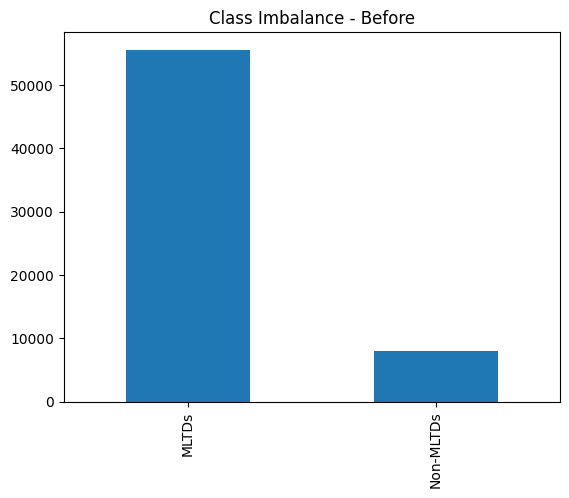

In [70]:
an['actual_MLTD_label'].value_counts().plot(kind='bar')
plt.title('Class Imbalance - Before')
lables = ['MLTDs', 'Non-MLTDs']
plt.xticks([1, 0], lables[::-1], rotation='vertical');

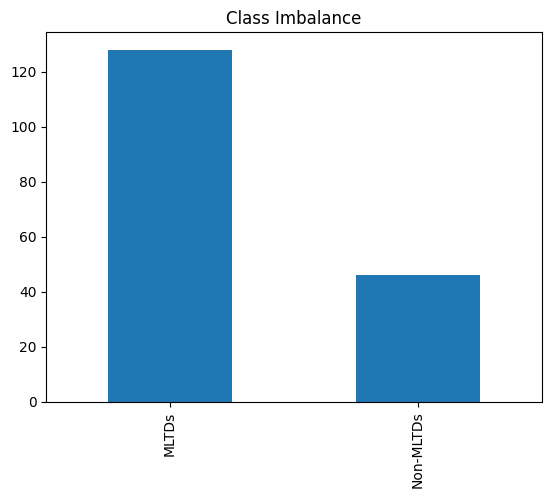

In [72]:
og['MLTD?'].value_counts().plot(kind='bar')
plt.title('Class Imbalance')
lables = ['MLTDs', 'Non-MLTDs']
plt.xticks([1, 0], lables[::-1], rotation='vertical');

TypeError: cannot unpack non-iterable Axes object

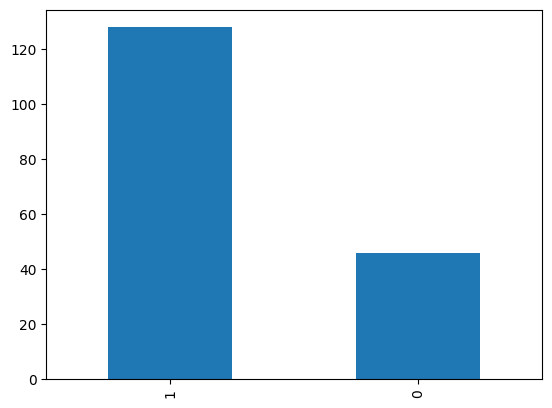

In [65]:
import matplotlib.pyplot as plt

fig, ax = og['MLTD?'].value_counts().plot(kind='bar')

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'MLTDs'
labels[2] = 'Non-MLTDs'

ax.set_xticklabels(labels)

plt.show()

In [165]:
unann = pd.read_csv('Unannotated_data.csv')
unann = unann[unann['GPT_4_Predicted_MLTD_label'].isnull()==True]

In [198]:
import random
unann = unann.loc[random.sample(unann.index.tolist(), 100), :]


In [200]:
unann['spaCy_Predicted_MLTD_label_BAL'] = ''
unann['spaCy_Predicted_MLTD_label_AAL'] = ''

In [204]:
for idx, row in unann.iterrows():
    comment = unann.loc[idx, 'Comment']
    doc_bal = bal(comment)
    doc_aal = aal(comment)
    preds_bal = sorted(doc_bal.cats.items(), key = lambda kv: -kv[1])[0][0]
    preds_aal = sorted(doc_aal.cats.items(), key = lambda kv: -kv[1])[0][0]
    unann.loc[idx, 'spaCy_Predicted_MLTD_label_BAL'] = preds_bal
    unann.loc[idx, 'spaCy_Predicted_MLTD_label_AAL'] = preds_aal

In [206]:
unann.to_csv('final_result.csv', index=False)

In [226]:
from sklearn.metrics import classification_report



In [227]:
unann = pd.read_csv('final_result.csv')
res = unann[['actual_MLTD_label', 'spaCy_Predicted_MLTD_label_BAL', 'spaCy_Predicted_MLTD_label_AAL']]

In [228]:
res['actual_MLTD_label'] = res['actual_MLTD_label'].replace('Yes', '1').replace('No', '0').astype(int)

/var/folders/3q/dw048hjx6d775m1t6pn8lf5h0000gs/T/ipykernel_97118/2163398972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['actual_MLTD_label'] = res['actual_MLTD_label'].replace('Yes', '1').replace('No', '0').astype(int)


In [229]:
res['spaCy_Predicted_MLTD_label_BAL'] = res['spaCy_Predicted_MLTD_label_BAL'].replace('Yes', '1').replace('No', '0').astype(int)
res['spaCy_Predicted_MLTD_label_AAL'] = res['spaCy_Predicted_MLTD_label_AAL'].replace('Yes', '1').replace('No', '0').astype(int)

/var/folders/3q/dw048hjx6d775m1t6pn8lf5h0000gs/T/ipykernel_97118/3208835895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['spaCy_Predicted_MLTD_label_BAL'] = res['spaCy_Predicted_MLTD_label_BAL'].replace('Yes', '1').replace('No', '0').astype(int)
/var/folders/3q/dw048hjx6d775m1t6pn8lf5h0000gs/T/ipykernel_97118/3208835895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['spaCy_Predicted_MLTD_label_AAL'] = res['spaCy_Predicted_MLTD_label_AAL'].replace('Yes', '1').replace('No', '0').astype(int

In [230]:
res

actual_MLTD_label  spaCy_Predicted_MLTD_label_BAL  \
0                   0                               1   
1                   1                               1   
2                   1                               1   
3                   1                               1   
4                   1                               1   
..                ...                             ...   
95                  1                               1   
96                  1                               1   
97                  1                               1   
98                  1                               1   
99                  1                               1   

    spaCy_Predicted_MLTD_label_AAL  
0                                1  
1                                1  
2                                1  
3                                1  
4                                1  
..                             ...  
95                               1  
96                               1  
97                               1  
98                               1  
99                               1  

[100 rows x 3 columns]

In [231]:
print(classification_report(res['actual_MLTD_label'], res['spaCy_Predicted_MLTD_label_BAL']))

              precision    recall  f1-score   support

           0       0.40      0.17      0.24        12
           1       0.89      0.97      0.93        88

    accuracy                           0.87       100
   macro avg       0.65      0.57      0.58       100
weighted avg       0.84      0.87      0.85       100



In [232]:
print(classification_report(res['actual_MLTD_label'], res['spaCy_Predicted_MLTD_label_AAL']))

              precision    recall  f1-score   support

           0       0.29      0.17      0.21        12
           1       0.89      0.94      0.92        88

    accuracy                           0.85       100
   macro avg       0.59      0.55      0.56       100
weighted avg       0.82      0.85      0.83       100

